In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

2025-06-18 22:03:28.266640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 22:03:28.273930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750251808.281588   70081 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750251808.283977   70081 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750251808.290342   70081 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [40]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 100
BATCH_SIZE = 256

GENERATE_LEN = 50

In [4]:
# Load the data
file_list = glob.glob("data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

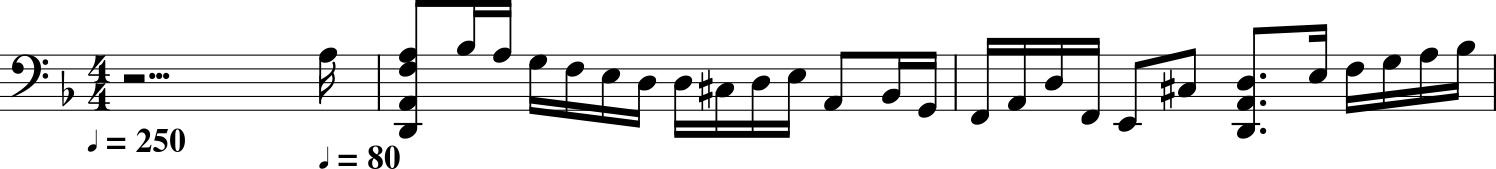

In [9]:
example_score.show()

In [10]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x76f722e269e0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.75} <music21.tempo.MetronomeMark andantino Quarter=80>
    {3.75} <music21.chord.Chord A3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord D2 A2 F3 A3>
    {0.5} <music21.chord.Chord B-3>
    {0.75} <music21.chord.Chord A3>
    {1.0} <music21.chord.Chord G3>
    {1.25} <music21.chord.Chord F3>
    {1.5} <music21.chord.Chord E3>
    {1.75} <music21.chord.Chord D3>
    {2.0} <music21.chord.Chord D3>
    {2.25} <music21.chord.Chord C#3>
    {2.5} <music21.chord.Chord D3>
    {2.75} <music21.chord.Chord E3>
    {3.0} <music21.chor

In [11]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()


1 Parsing data/cs6-6gig.mid


/tmp/ipykernel_70081/1308860806.py:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


1172 notes parsed
2 Parsing data/cs2-2all.mid
1865 notes parsed
3 Parsing data/cs5-2all.mid
2557 notes parsed
4 Parsing data/cs4-2all.mid
3612 notes parsed
5 Parsing data/cs4-6gig.mid
4583 notes parsed
6 Parsing data/cs5-4sar.mid
4802 notes parsed
7 Parsing data/cs1-3cou.mid
5622 notes parsed
8 Parsing data/cs4-5bou.mid
6946 notes parsed
9 Parsing data/cs3-2all.mid
7683 notes parsed
10 Parsing data/cs2-1pre.mid
8321 notes parsed
11 Parsing data/cs1-5men.mid
8968 notes parsed
12 Parsing data/cs1-2all.mid
9889 notes parsed
13 Parsing data/cs6-4sar.mid
10224 notes parsed
14 Parsing data/cs6-2all.mid
10909 notes parsed
15 Parsing data/cs2-5men.mid
11436 notes parsed
16 Parsing data/cs5-1pre.mid
12745 notes parsed
17 Parsing data/cs1-1pre.mid
13403 notes parsed
18 Parsing data/cs2-3cou.mid
14144 notes parsed
19 Parsing data/cs4-4sar.mid
14464 notes parsed
20 Parsing data/cs3-6gig.mid
15425 notes parsed
21 Parsing data/cs2-4sar.mid
15762 notes parsed
22 Parsing data/cs3-4sar.mid
16103 notes 

In [12]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D3 C#3 D3 E3 F#3 F#3 E3 F#3 G3 A3 A3 B3 A3 G3 A3 F#3 A2 B2 C#3 D3 E3 F#3 G3 A3 B3 C4 D4 B3 A3 B3 E3 F#3 G3 E3 C#3 B2 C#3 D3 E3 A2 G2 F#2 G2 E2 F#2 A3 G3 F#3 E3 D3 E3 ...

Duration string
 0.25 0.25 0.25 0.25 0.5 0.25 0.25 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.5 0.5 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0.25 0.25 0.25 0.25 0.25 0.25 ...


In [13]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

I0000 00:00:1750253215.443147   70081 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13822 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-06-18 22:26:55.798213: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-18 22:26:56.153407: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         4         2
        25         2
         4         2
         8         2
        12         3
        12         2
         8         2
        12         2
         2         2
         3         3
         3         3


In [15]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


In [16]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [17]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[17,  9,  3, ..., 12,  8,  7],
       [ 9,  3, 15, ...,  8,  7, 17],
       [ 3, 15,  7, ...,  7, 17, 22],
       ...,
       [ 9,  4,  8, ...,  8,  2, 12],
       [ 4,  8, 12, ...,  2, 12,  8],
       [ 8, 12,  9, ..., 12,  8,  4]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9,  3, 15, ...,  8,  7, 17],
       [ 3, 15,  7, ...,  7, 17, 22],
       [15,  7, 17, ..., 17, 22, 21],
       ...,
       [ 4,  8, 12, ...,  2, 12,  8],
       [ 8, 12,  9, ..., 12,  8,  4],
       [12,  9, 10, ...,  8,  4,  8]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 6, ..., 2, 2, 2],
       ...,

In [18]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

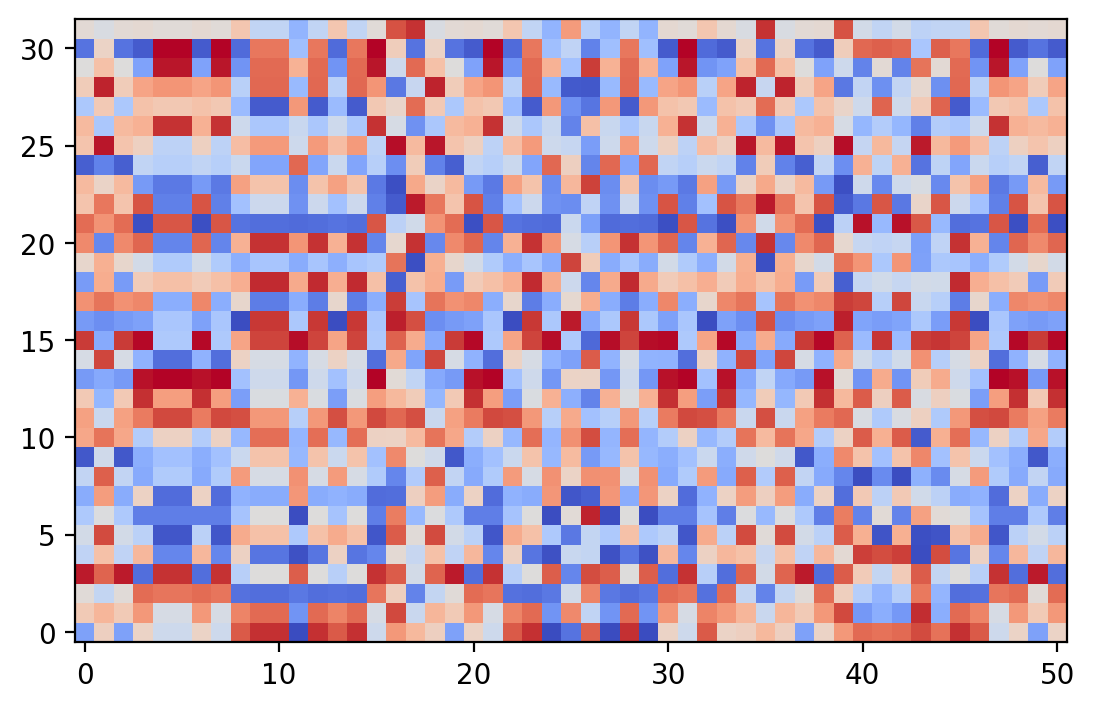

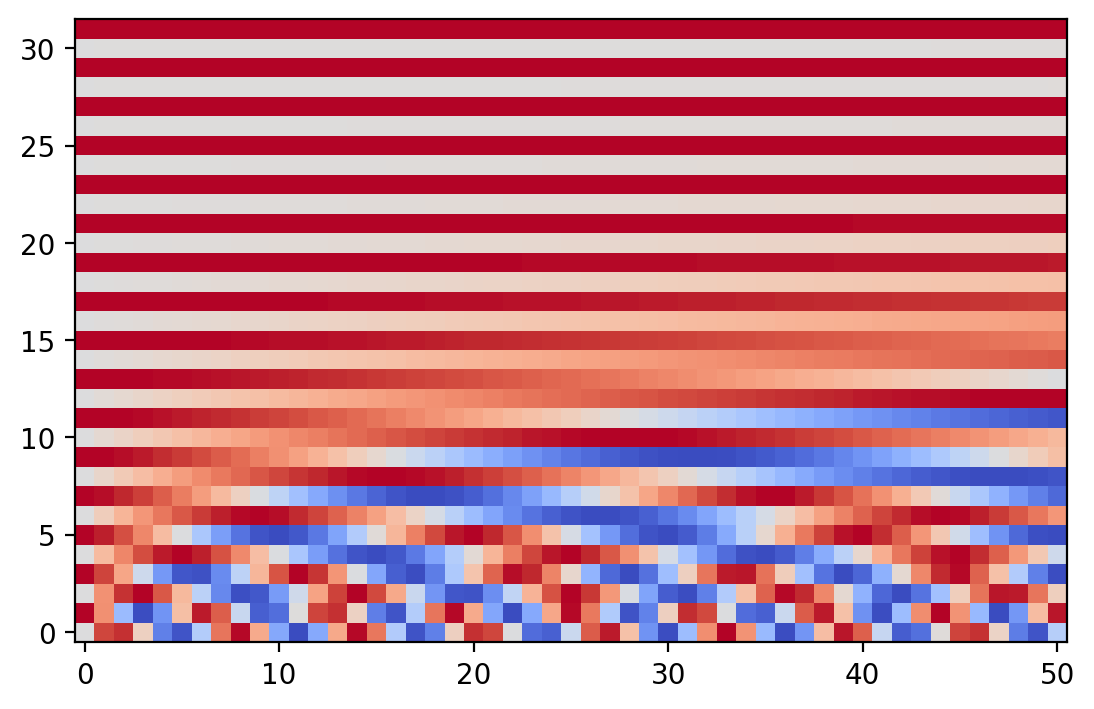

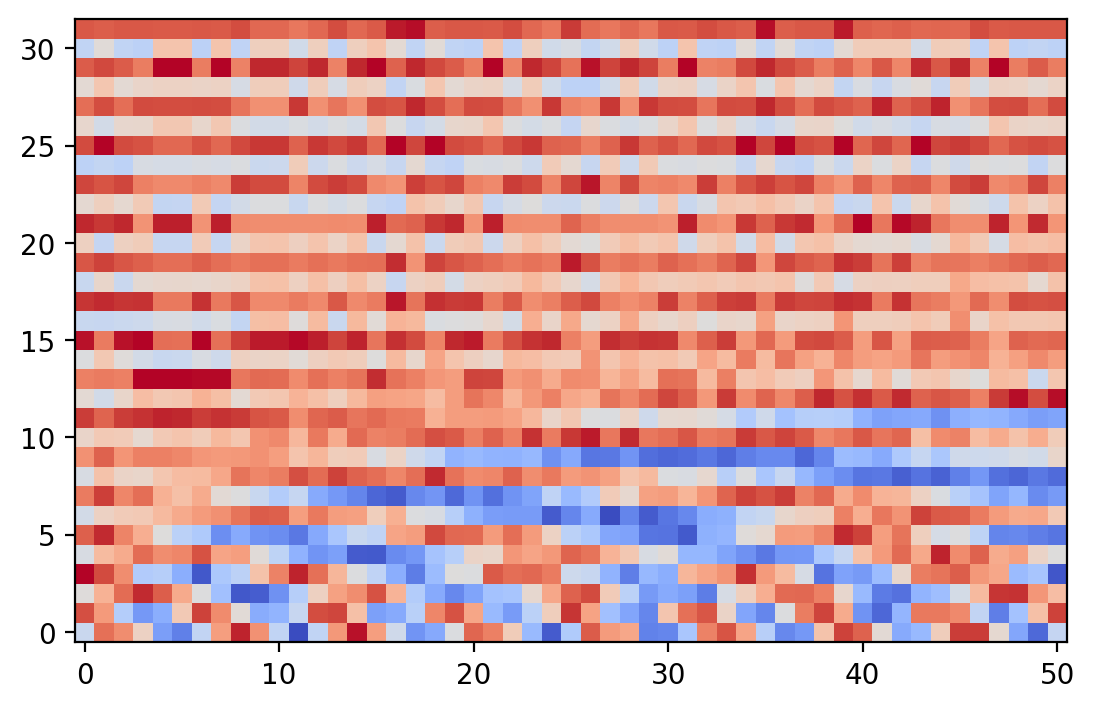

In [22]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [23]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      7,552 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      3,072 │ input_layer_1[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate[0][0] │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 59)  │     15,163 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 24)  │      6,168 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        os.makedirs("output", exist_ok=True)  # 追加: ディレクトリがなければ作成
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [35]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5105 - loss: 2.3632 - note_outputs_loss: 1.8526[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E-3'), np.str_('C3'), np.str_('B-2'), np.str_('A2'), np.str_('G2'), np.str_('F2'), np.str_('E2'), np.str_('G#3'), np.str_('A3'), np.str_('F3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('E3'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2'), np.str_('F3'), np.str_('B2')], ['0.0', np.str_('0.0'), np.str_('0.0'), np.str_('1.0'), np.str_('1.0'), np.str_('1.0'), np.str_('1.0'), np.str_('1.0'), np.s

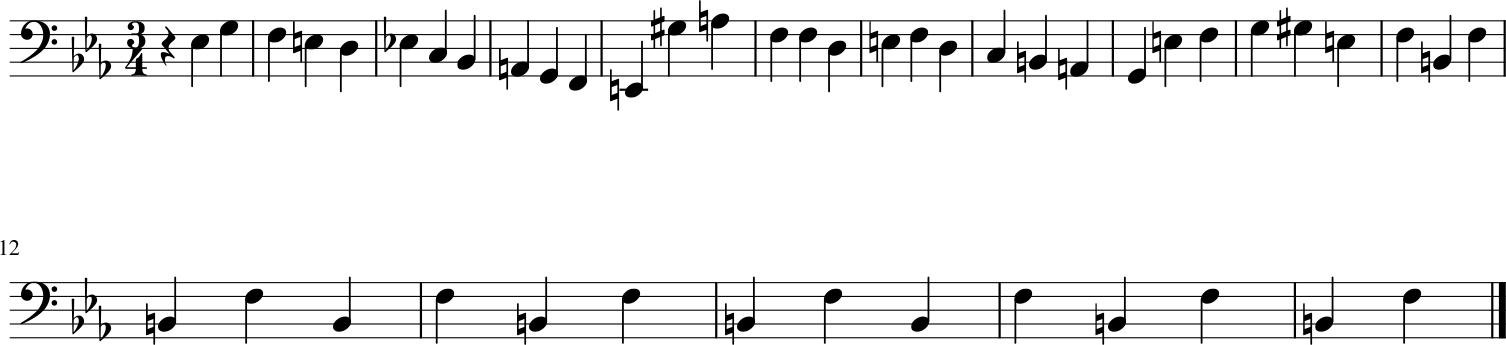

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5111 - loss: 2.3645 - note_outputs_loss: 1.8534
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5315 - loss: 2.3608 - note_outputs_loss: 1.8293[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('B-2'), np.str_('G2'), np.str_('B-2'), np.str_('E-2'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('G3'), np.str_('C4'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.st

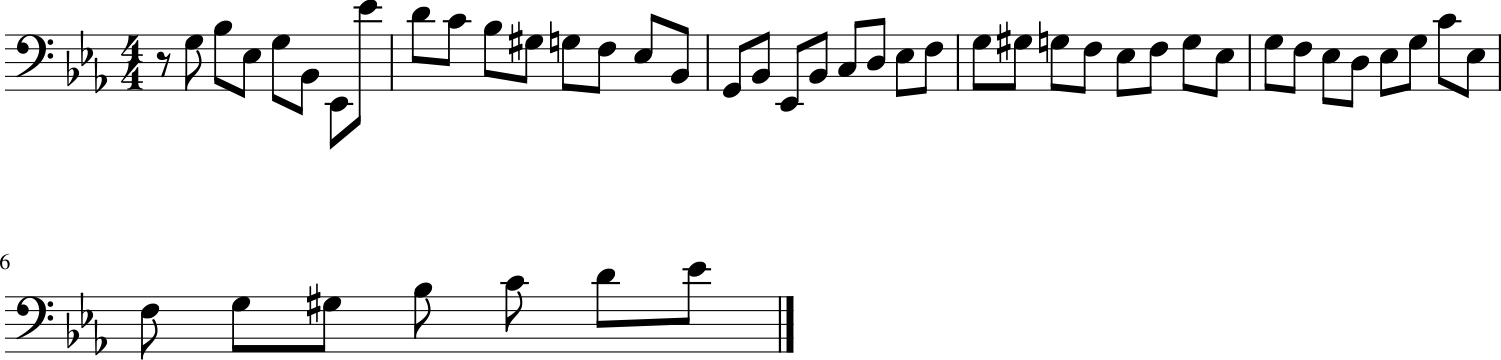

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5316 - loss: 2.3614 - note_outputs_loss: 1.8298
Epoch 3/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5727 - loss: 2.4264 - note_outputs_loss: 1.8537[['START', np.str_('E-:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.s

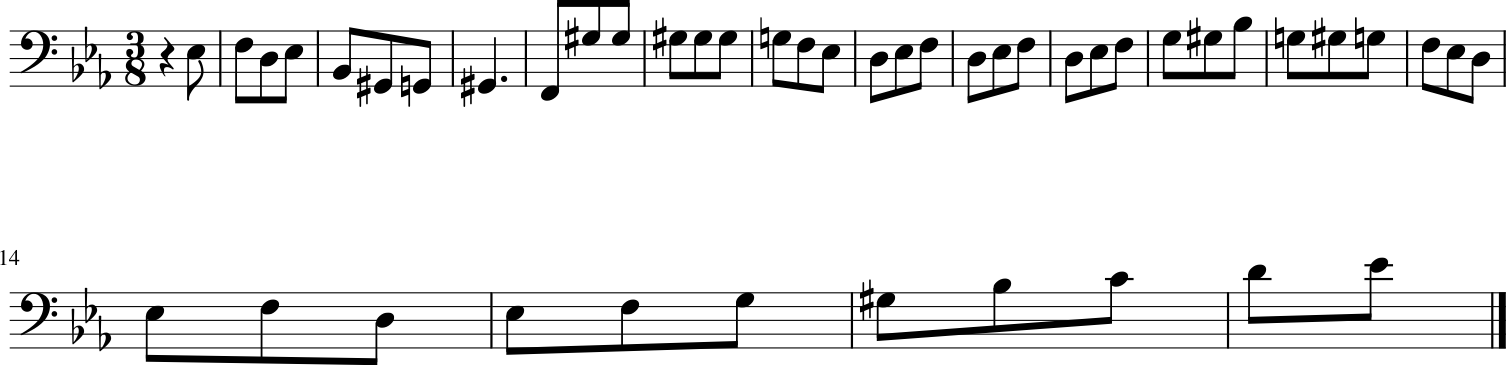

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5721 - loss: 2.4259 - note_outputs_loss: 1.8539
Epoch 4/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5308 - loss: 2.3050 - note_outputs_loss: 1.7742[['START', np.str_('D:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('F#4'), np.str_('F#4'), np.str_('A4'), np.str_('A4'), np.str_('A4'), np.str_('A4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('D4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('E4'), np.str_('F

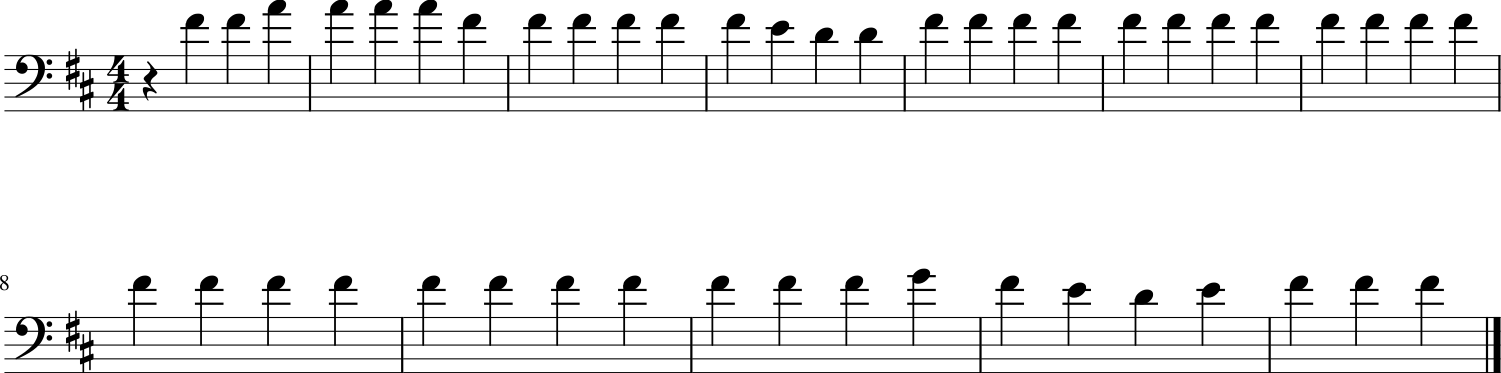

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5309 - loss: 2.3058 - note_outputs_loss: 1.7750
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5804 - loss: 2.4188 - note_outputs_loss: 1.8384[['START', np.str_('D:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('A4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('G4'), np.str_('F#4'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('C#4'), np.str_('A3'), np.str_('A3'), np.str_('A3'), np.str_('B3'), np.str_('C#

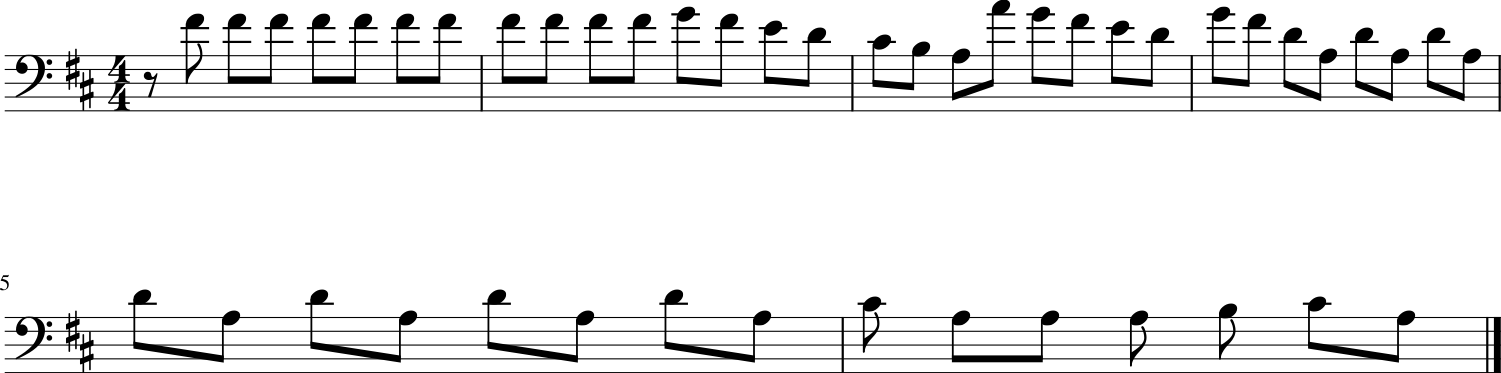

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5800 - loss: 2.4183 - note_outputs_loss: 1.8383
Epoch 6/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4783 - loss: 2.2425 - note_outputs_loss: 1.7642[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('E-4'), np.str_('E-4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('E-4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.

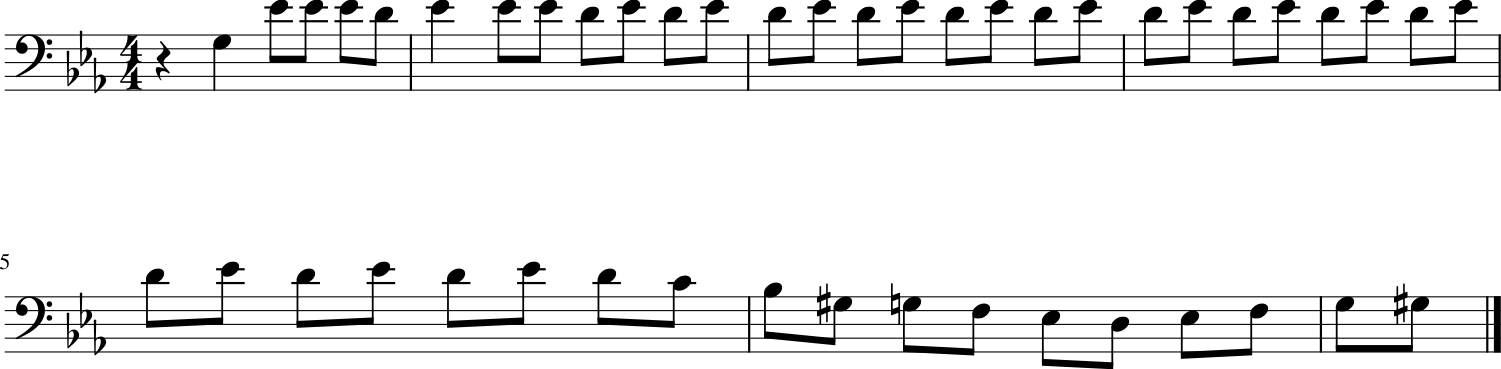

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.4793 - loss: 2.2439 - note_outputs_loss: 1.7646
Epoch 7/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5778 - loss: 2.3354 - note_outputs_loss: 1.7576[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('C4'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('F4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str

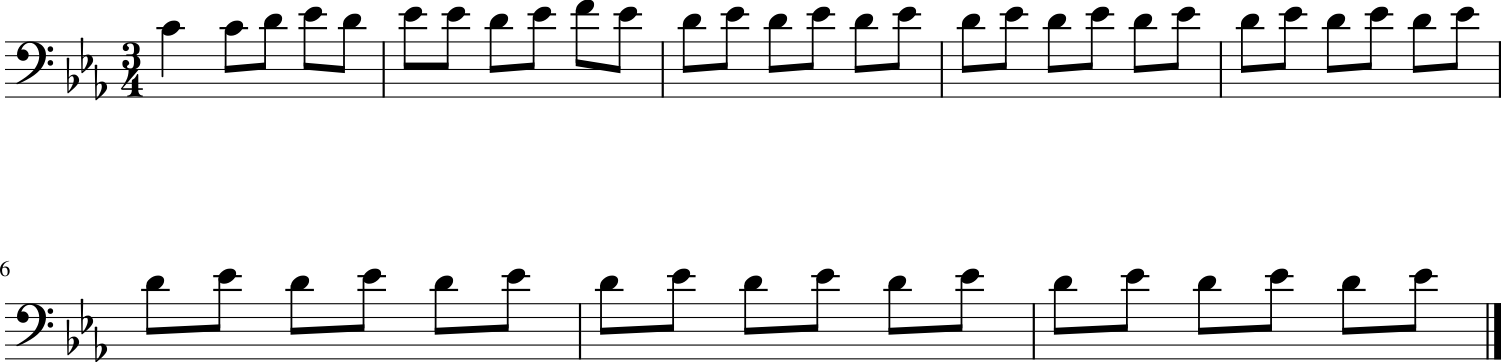

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5771 - loss: 2.3347 - note_outputs_loss: 1.7576
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5363 - loss: 2.2375 - note_outputs_loss: 1.7012[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('G3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('C3'), np.str_('C2'), np.str_('C3'), np.str_('E3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3')], ['0.0', np.s

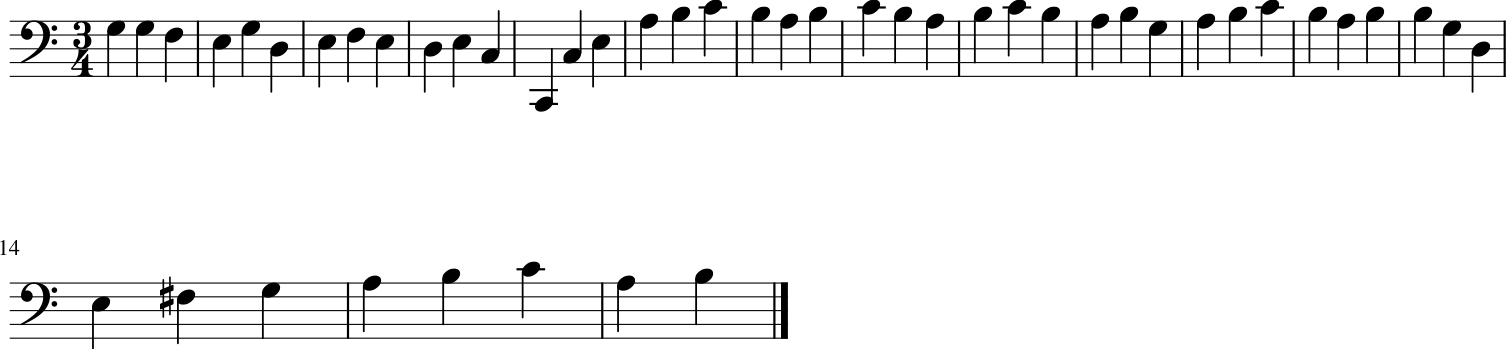

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5363 - loss: 2.2380 - note_outputs_loss: 1.7016
Epoch 9/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - duration_outputs_loss: 0.4976 - loss: 2.1773 - note_outputs_loss: 1.6797[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('G3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('G2'), np.str_('F2'), np.str_('E-2'), np.str_('C4'), np.str_('G2'), np.str_('B3'), np.str_('C2'), np.str_('G2'), np.str_('C2'), np.str_('D2'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('G2'), np.str_('A2')]

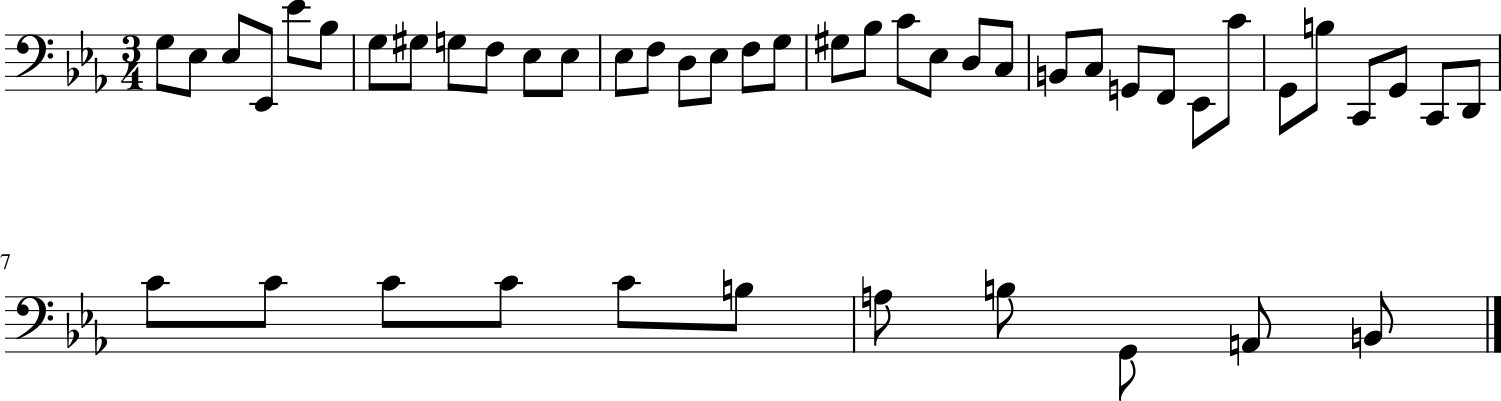

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.4986 - loss: 2.1795 - note_outputs_loss: 1.6810
Epoch 10/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4815 - loss: 2.1629 - note_outputs_loss: 1.6814[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('B-3'), np.str_('C3'), np.str_('G#2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('C3'), np.str_('D3'), np.str_('G#2'), np.str_('B2'), np.str_('E3'), np.str_('G#3'), np.str_('B3'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B2'), np.str_('A2'), np.str_('B2'), np.str_('D3'), np.str_('B3'), np.str_('D3'), np.str_('F#3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('A3'), np.str_('E-3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('E2'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('E3')], ['

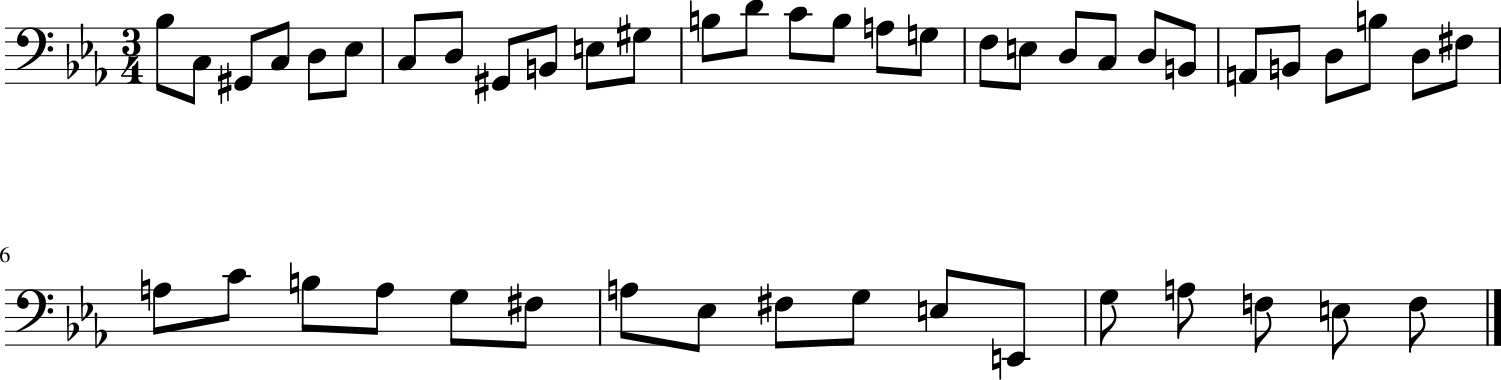

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.4824 - loss: 2.1644 - note_outputs_loss: 1.6820
Epoch 11/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5315 - loss: 2.2169 - note_outputs_loss: 1.6854[['START', np.str_('D:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('F#4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('D4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('E4'), np.str_('F#4'), np.str_('A3'), np.str_('G4'), np.str_('D4'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('D4'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('D4'), np.str_('E4'), np.str_('F#4'), np.str_('A3'), np.str_('B3'), np.str_('C#4'), np.str_('D4'), np.str_('A3'), np.str_('B3'), np.str_('D4'), np.str_('E4'), np.str_('F#4'), np.str_('A3'), np.str_

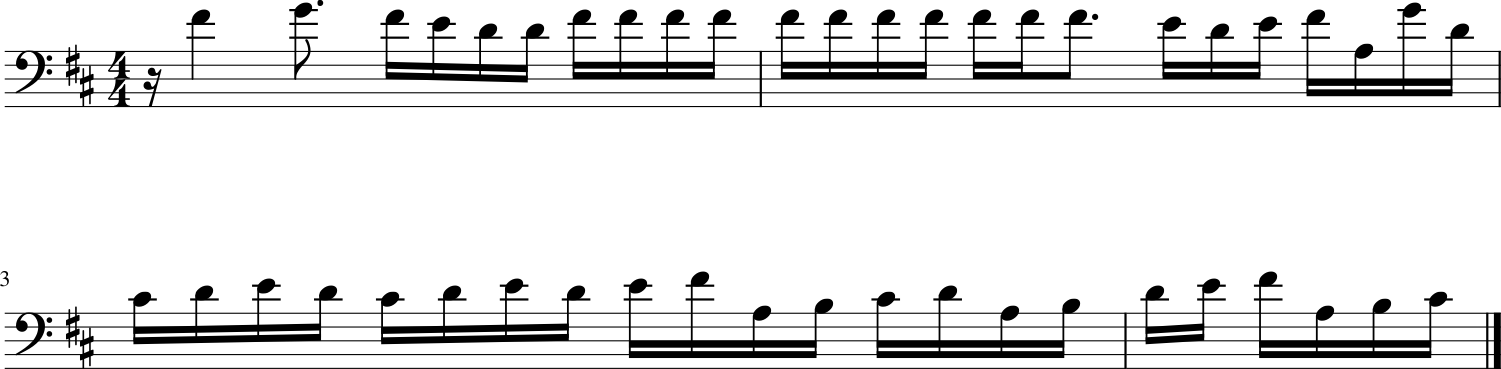

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5316 - loss: 2.2169 - note_outputs_loss: 1.6853
Epoch 12/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5020 - loss: 2.1220 - note_outputs_loss: 1.6200[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('C4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.s

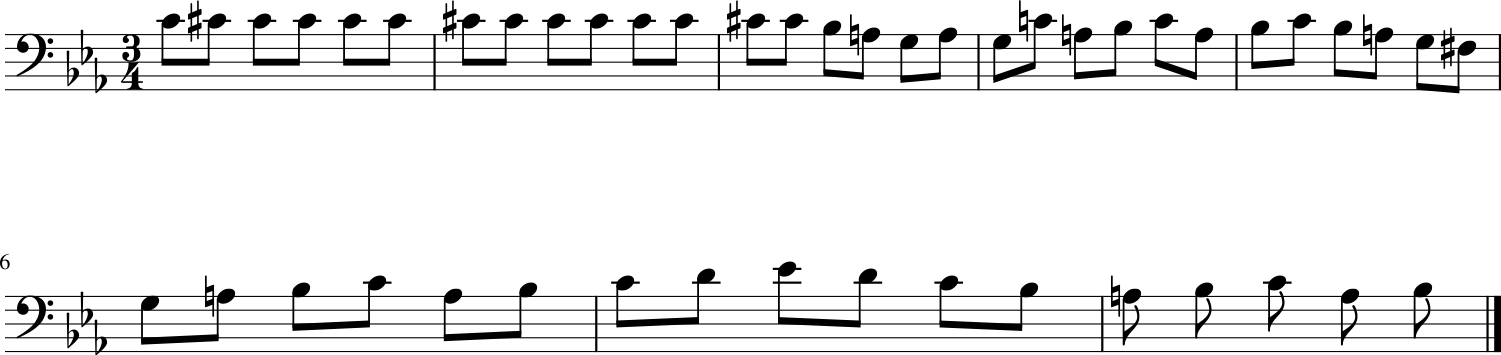

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5028 - loss: 2.1243 - note_outputs_loss: 1.6215
Epoch 13/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4673 - loss: 2.0967 - note_outputs_loss: 1.6294[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('B2'), np.str_('C3'), np.str_('E3'), np.str_('F#3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('B2'), np.str_('G3'), np.str_('A3'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3')], ['0.0', n

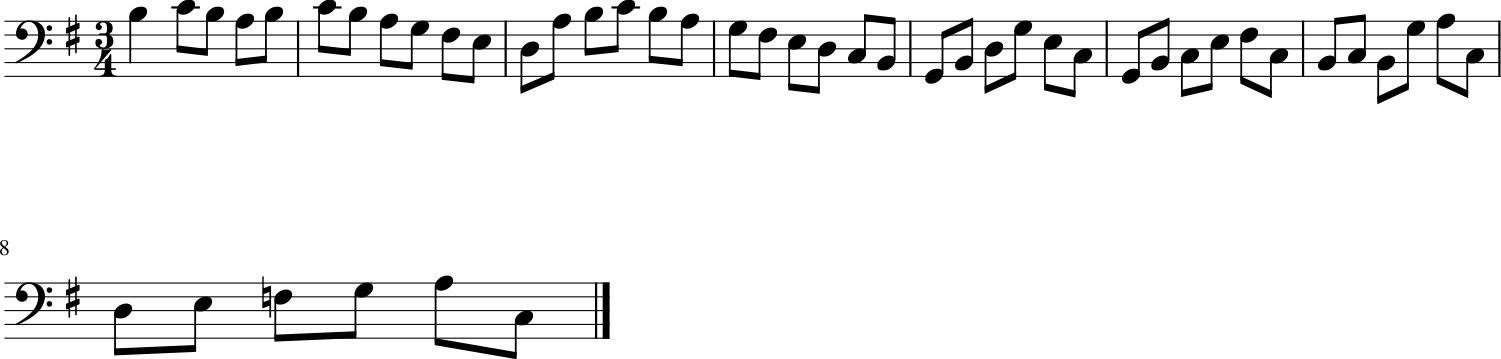

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.4686 - loss: 2.0985 - note_outputs_loss: 1.6300
Epoch 14/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5435 - loss: 2.1214 - note_outputs_loss: 1.5779[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('D3'), np.str_('B3'), np.str_('D3'), np.str_('G2'), np.str_('D3'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('G3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('C3')], ['0.0', n

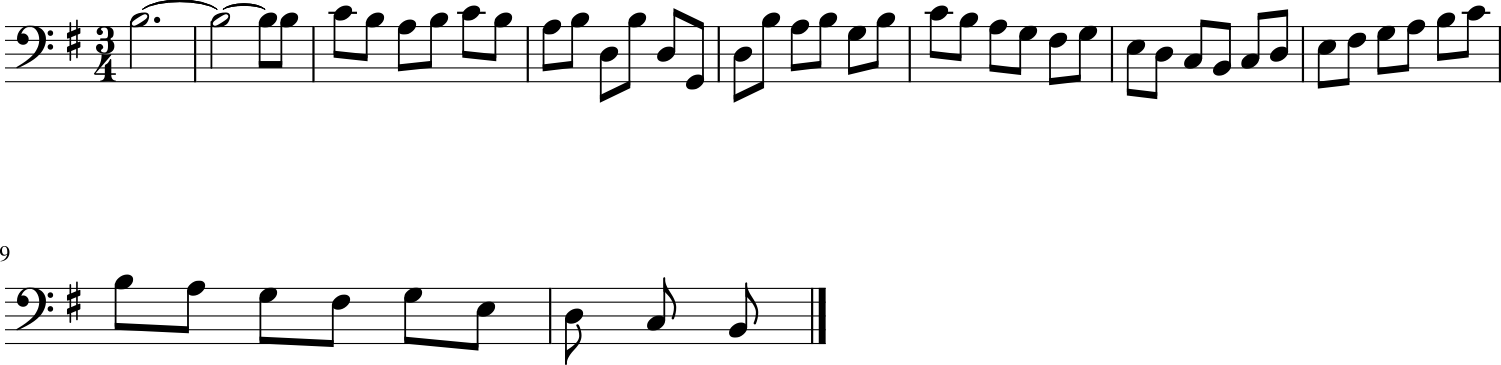

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5435 - loss: 2.1218 - note_outputs_loss: 1.5783
Epoch 15/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5019 - loss: 2.1022 - note_outputs_loss: 1.6003[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('D3'), np.str_('E-3'), np.str_('G2'), np.str_('F2'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_(

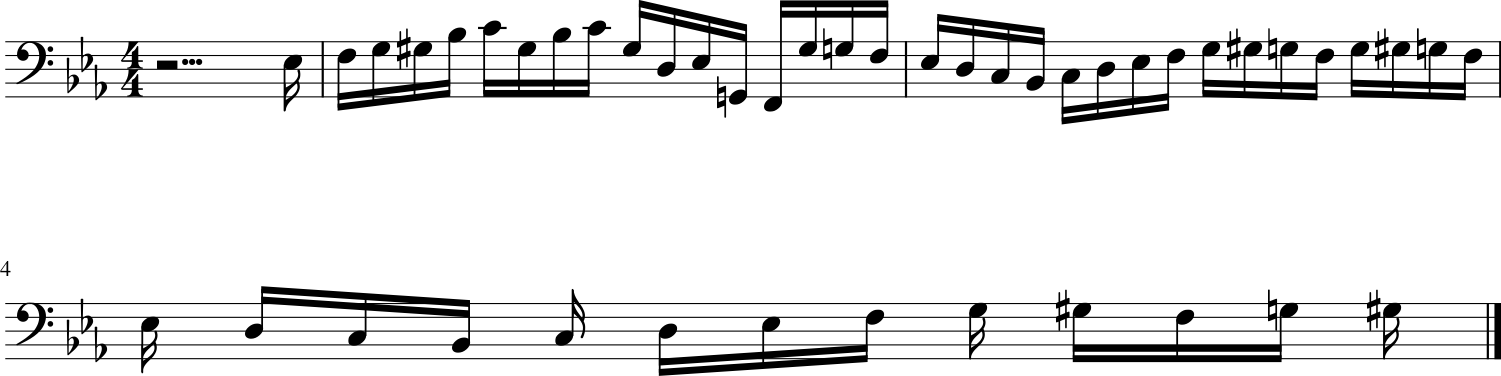

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.5025 - loss: 2.1032 - note_outputs_loss: 1.6008
Epoch 16/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5465 - loss: 2.1381 - note_outputs_loss: 1.5915[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('G#3'), np.str_('E-4'), np.str_('C4'), np.str_('D4'), np

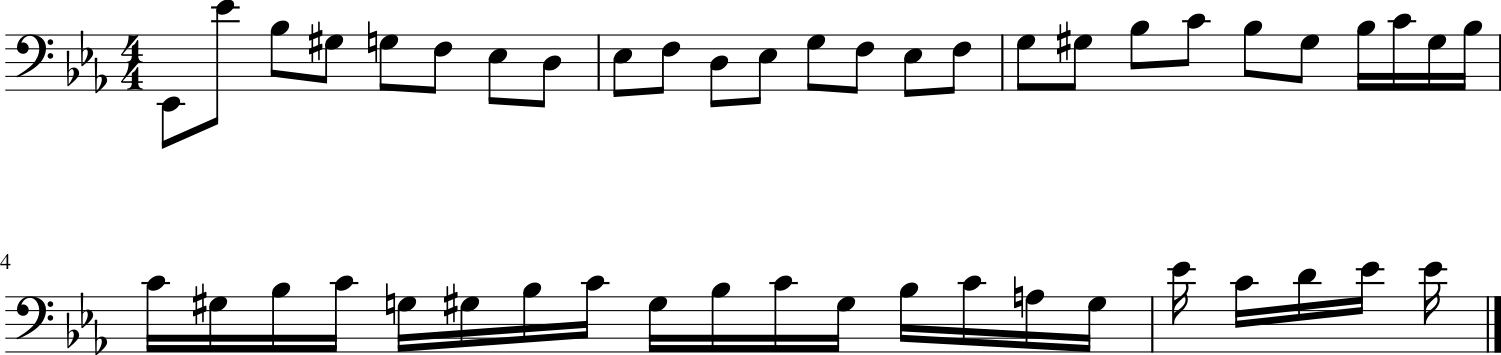

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5464 - loss: 2.1383 - note_outputs_loss: 1.5919
Epoch 17/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5213 - loss: 2.0570 - note_outputs_loss: 1.5356[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('C3'), np.str_('G2'), np.str_('F2'), np.str_('G#2'), np.str_('E-2'), np.str_('D2'), np.str_('F2'), np.str_('G#3'), np.st

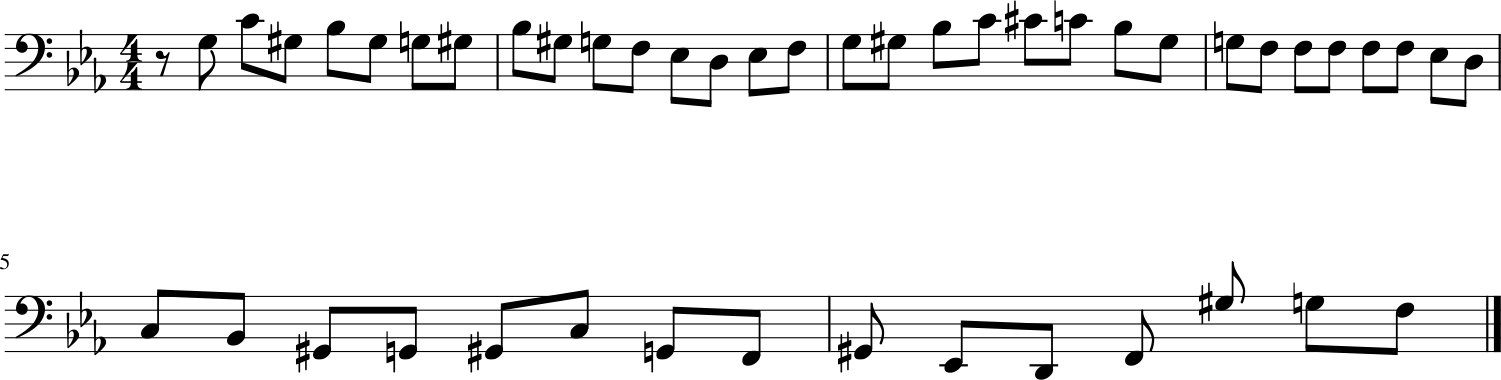

107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - duration_outputs_loss: 0.5216 - loss: 2.0583 - note_outputs_loss: 1.5367
Epoch 18/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - duration_outputs_loss: 0.5330 - loss: 2.0867 - note_outputs_loss: 1.5537[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('G3'), np.str_('E-3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('B-3'), np.str_('G3'), np.str_('E-3'), np.str_('E-2'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('

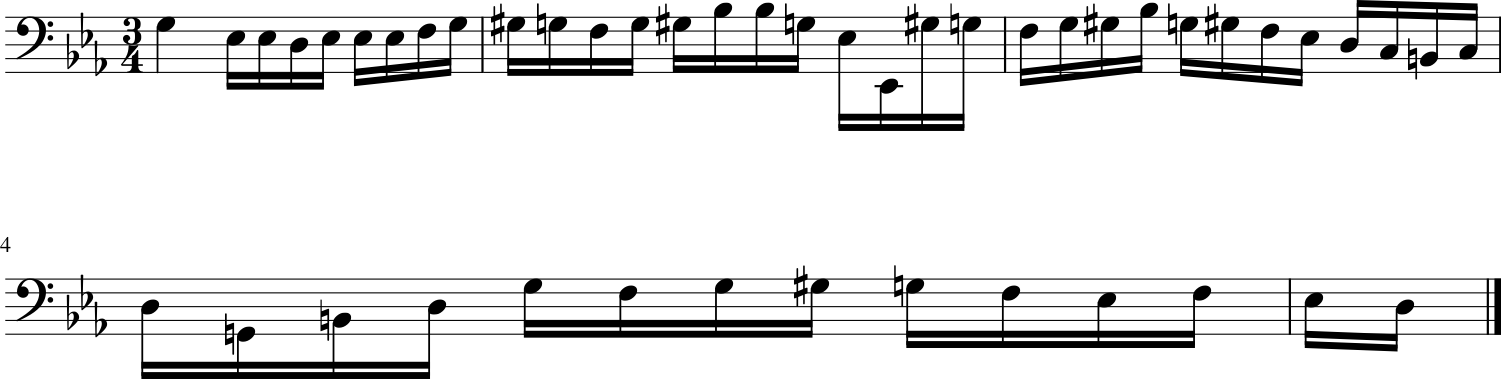

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.5330 - loss: 2.0868 - note_outputs_loss: 1.5539
Epoch 19/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5683 - loss: 2.0680 - note_outputs_loss: 1.4997[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('F#3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G#2'), np.str_('G2'), np.str_('F2'), np.str_('E-2'), np.str_('F2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np.str_('G#3'), np

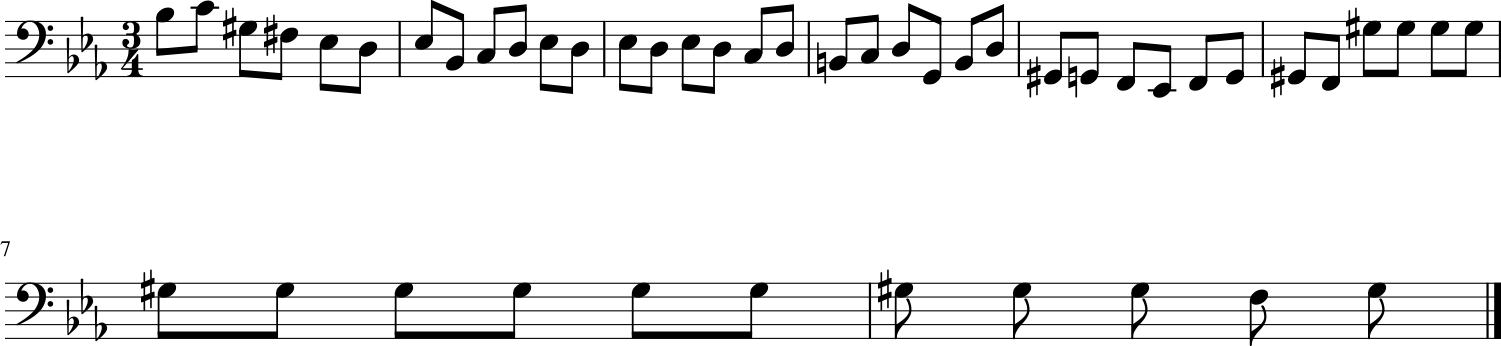

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.5675 - loss: 2.0685 - note_outputs_loss: 1.5010
Epoch 20/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5018 - loss: 2.0074 - note_outputs_loss: 1.5055[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('B-2'), np.str_('G2'), np.str_('B-2'), np.str_('E-2'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('F3'), np.str_('B-3'), np.str_('F3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np

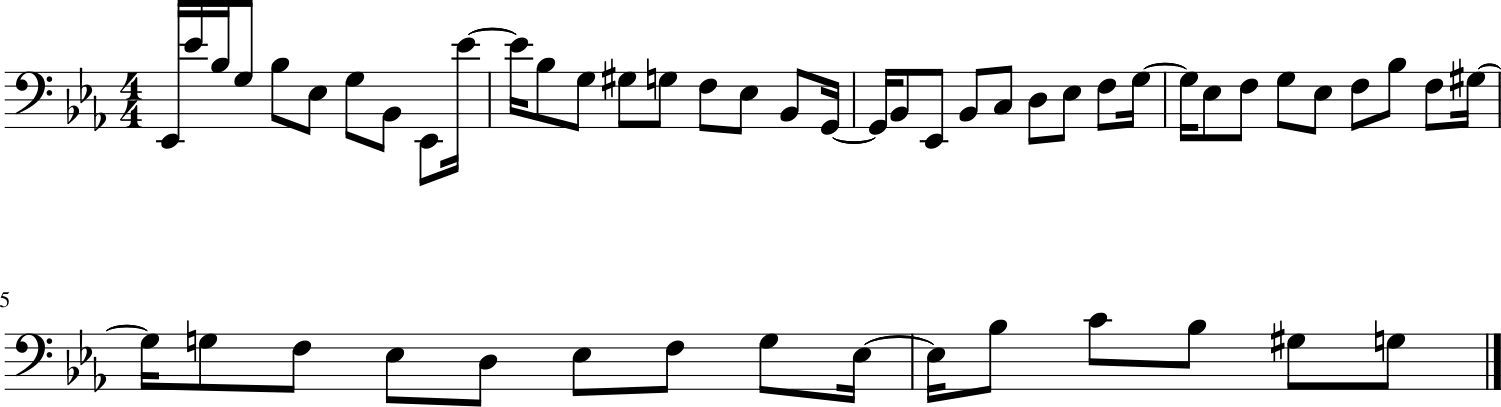

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5021 - loss: 2.0080 - note_outputs_loss: 1.5059
Epoch 21/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5290 - loss: 2.0195 - note_outputs_loss: 1.4904[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('G3'), np.str_('E-4'), np.str_('E-4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('A3'), np.str_('C3'), np.str_('E-4'), np.str_('rest'), np.str_('A3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('E3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('C#3'), np.str_('D3'), np.str_('F#3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('C#3'), np.str_('D3'), np.str_('E3')

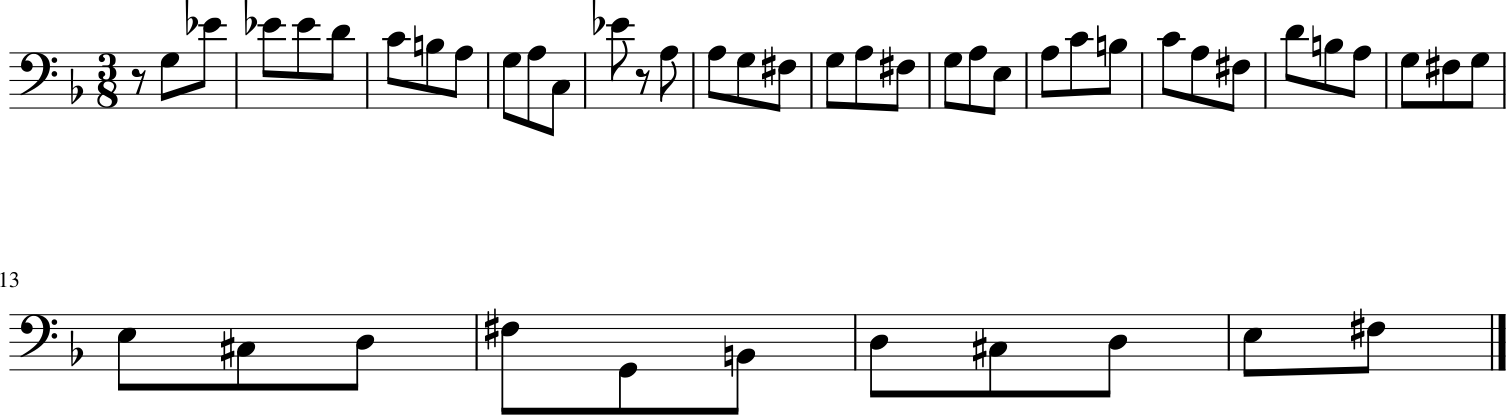

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5291 - loss: 2.0197 - note_outputs_loss: 1.4906
Epoch 22/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5617 - loss: 2.0051 - note_outputs_loss: 1.4434[['START', np.str_('D:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('D4'), np.str_('C#4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('D4'), np.str_('D4'), np.str_('D4'), np.str_('C#4'), np.str_('E4'), np.str_('E4'), np.str_('E4'), np.str_('E4'), np.str_('E4'), np.str_('G4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'

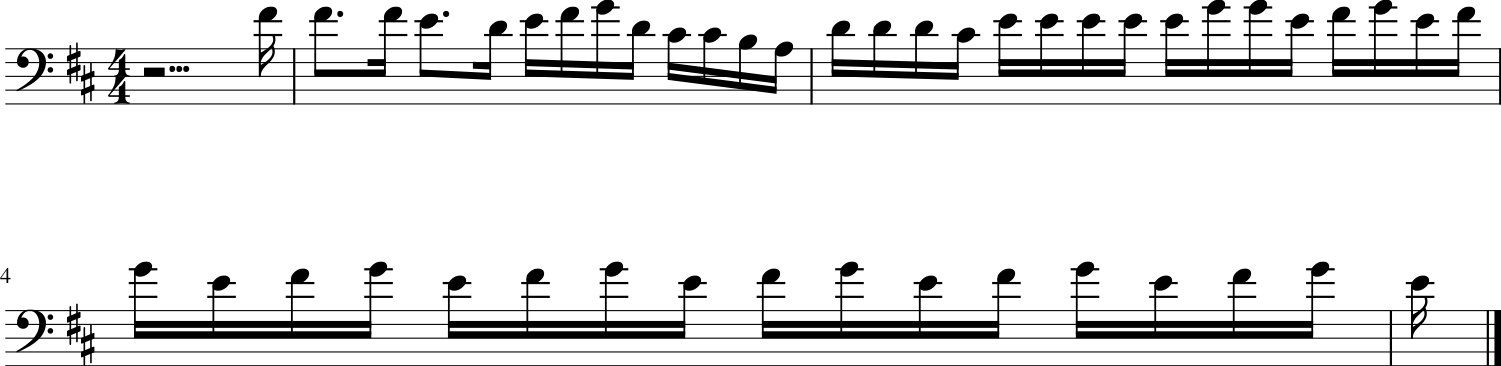

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5612 - loss: 2.0057 - note_outputs_loss: 1.4445
Epoch 23/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5135 - loss: 1.9931 - note_outputs_loss: 1.4797[['START', np.str_('G:major'), np.str_('6/8TS'), np.str_('rest'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('D3'), np.str_('F#3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('E3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('D3'), np.str_('E3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3')], ['0.0'

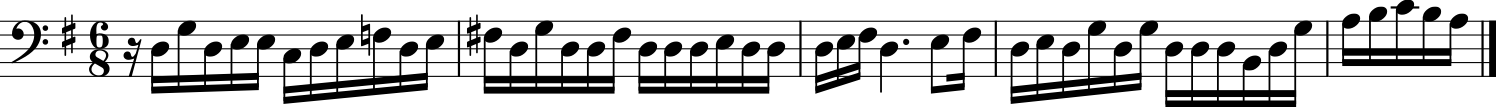

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5137 - loss: 1.9935 - note_outputs_loss: 1.4799
Epoch 24/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5184 - loss: 1.9659 - note_outputs_loss: 1.4475[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('A2'), np.str_('G2'), np.str_('F3'), np.str_('E3'), np.str_('C2'), np.str_('F2'), np.str_('A3'), np.str_('F3'), np.str_('F3'), np.str_('C#3'), np.str_('D3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('E-4')], ['0.

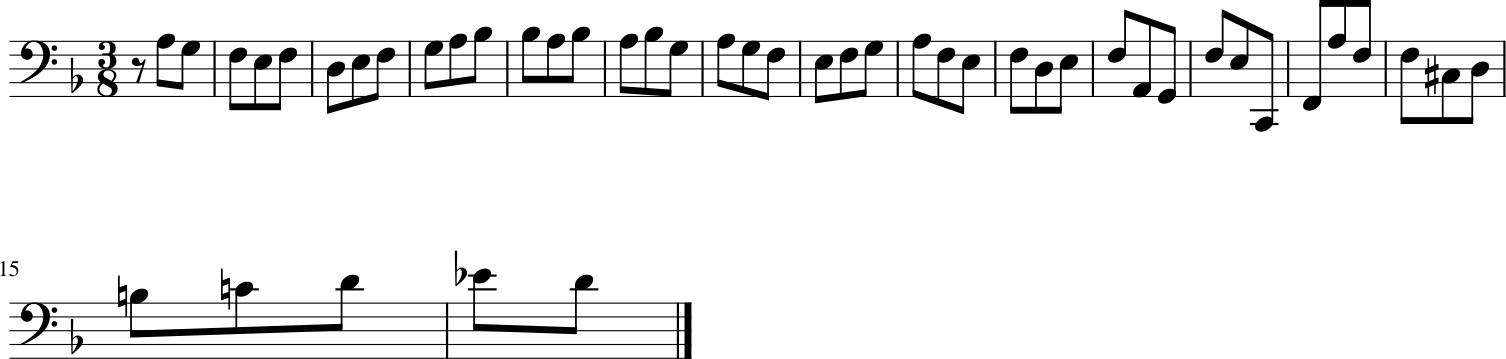

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5185 - loss: 1.9664 - note_outputs_loss: 1.4478
Epoch 25/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5174 - loss: 1.9270 - note_outputs_loss: 1.4097[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('A3'), np.str_('C#4'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('D3'), np.str_('F4'), np.str_('G3'), np.str_('E4'), np.str_('A3'), np.str_('G3'), np.str_('F3'),

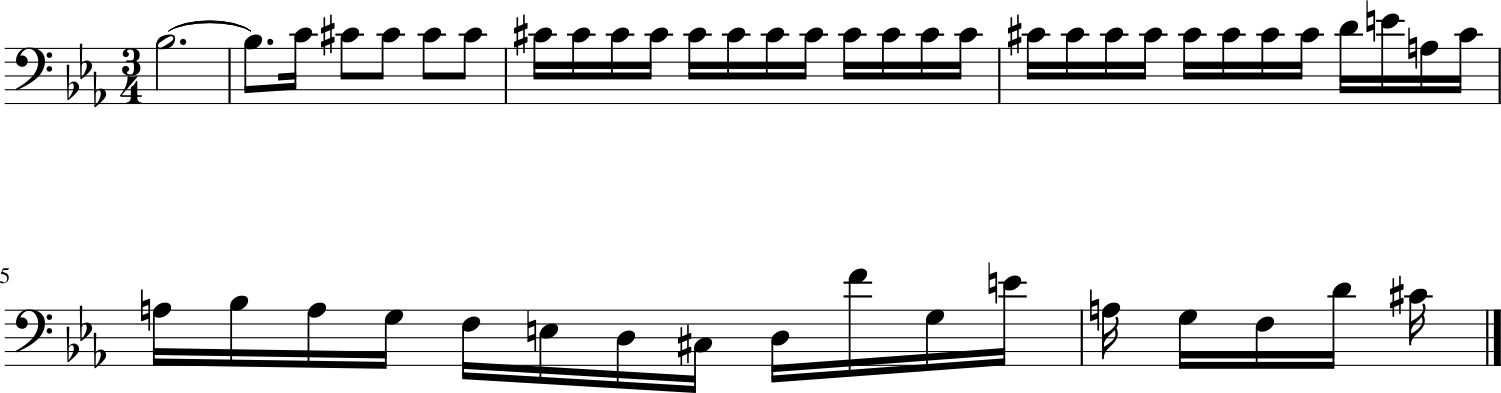

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5177 - loss: 1.9284 - note_outputs_loss: 1.4106
Epoch 26/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5002 - loss: 1.9146 - note_outputs_loss: 1.4144[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('A2'), np.str_('C3'), np.str_('B-2'), np.str_('G3'), np.str_('A2'), np.str_('G2'), np.str_('F2'), np.str_('E2'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('A2'), np.str_('B-2'), np.str_('G2'), np.str_('F2'), np.str_('A2'), np.str_('D3'), np.str_('F2'), np.str_('E2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('C4')], ['0.0

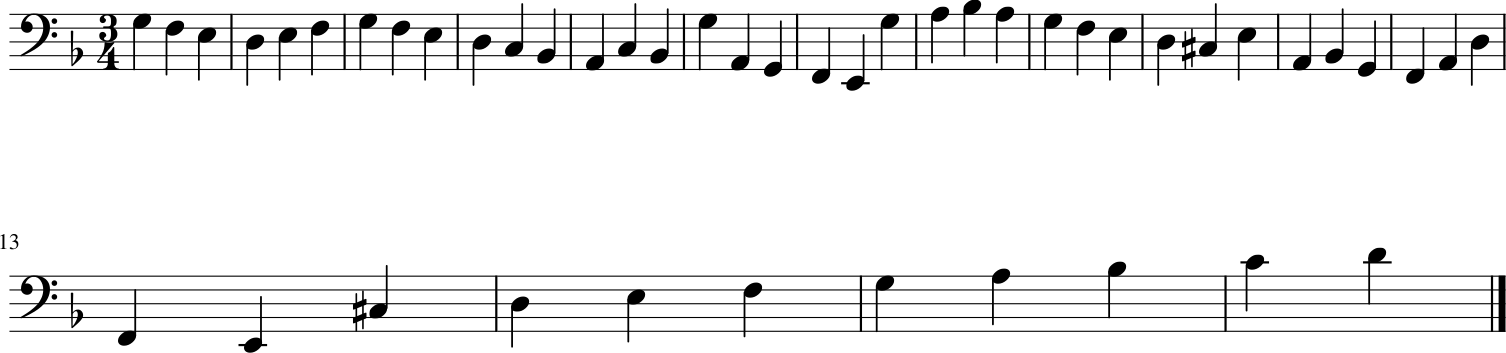

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5008 - loss: 1.9161 - note_outputs_loss: 1.4153
Epoch 27/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5055 - loss: 1.8943 - note_outputs_loss: 1.3889[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('A3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('D3'), np.str_('E-3'), np.str_('C4'), np.str_('F3'), np.str_('A3'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('C3'), np.str_('C2'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('G#2'), np.str_('F3'), np.str_('B-2'), np.str_('D3')

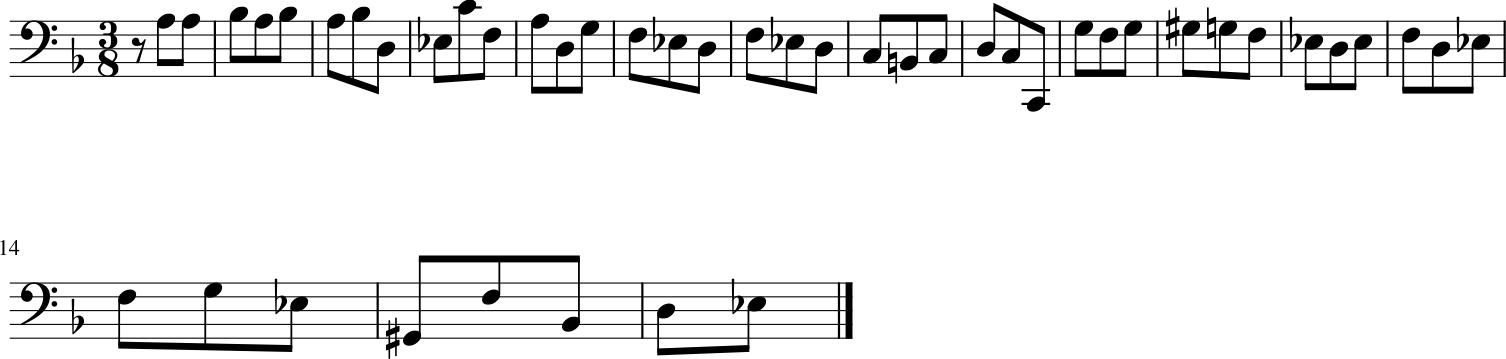

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5060 - loss: 1.8958 - note_outputs_loss: 1.3898
Epoch 28/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5237 - loss: 1.9431 - note_outputs_loss: 1.4194[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('F2'), np.str_('E2'), np.str_('D2'), np.str_('F2'), np.str_('A2'), np.str_('D3'), np.str_('F3'), np.str_('A3'), np.str_('D4'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('D3'), np.str_('B-2'), np.str_('C3'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('C#4')], 

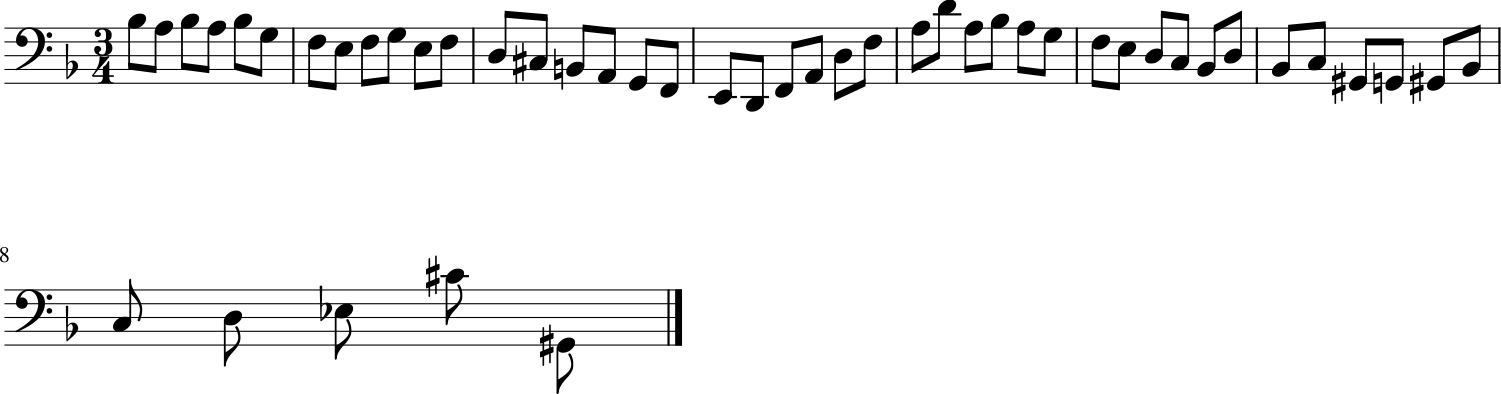

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5238 - loss: 1.9433 - note_outputs_loss: 1.4195
Epoch 29/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5516 - loss: 1.9311 - note_outputs_loss: 1.3795[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('F4'), np.str_('G#3'), np.str_('F4'), np.str_('F4'), np.str_('E-4'), np.str_('C4'), np.str_('E-4'), np.str_('A3'), np.str_('F3'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('D4'), np.str_('B-3'), np.str_('D4'), np.str_('G3'), np.str_('D4'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_(

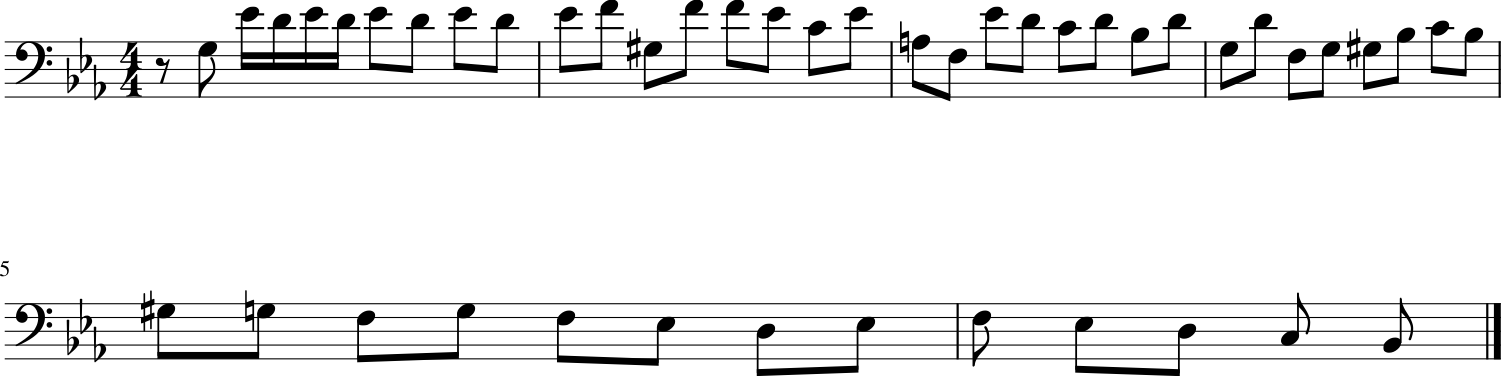

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5513 - loss: 1.9318 - note_outputs_loss: 1.3805
Epoch 30/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5349 - loss: 1.9081 - note_outputs_loss: 1.3732[['START', np.str_('E-:major'), np.str_('12/8TS'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str

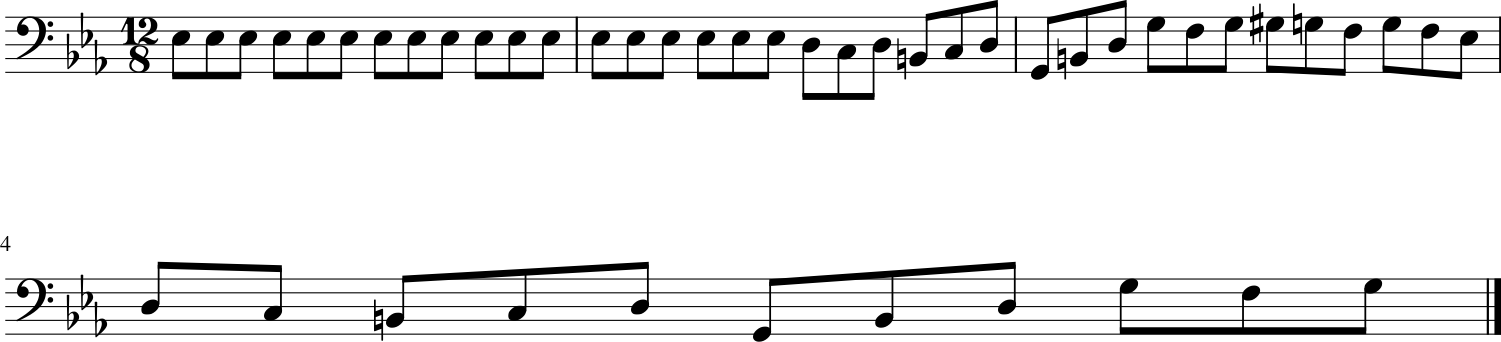

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5349 - loss: 1.9083 - note_outputs_loss: 1.3735
Epoch 31/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5588 - loss: 1.9267 - note_outputs_loss: 1.3679[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('B3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('F#3'), np.str_('D3'), np.str_('G2'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('G2'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('B2'), np.str_('B2'), np.str_('G2'), np.str_('E2'), np.str_('E2'), np.str_('E2'), np.str_('B2'), np.str_('G3'), np.str_('F#3')], ['0.0

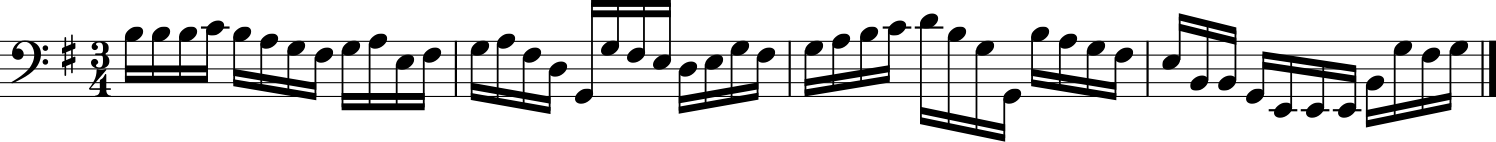

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5583 - loss: 1.9269 - note_outputs_loss: 1.3687
Epoch 32/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5482 - loss: 1.8922 - note_outputs_loss: 1.3441[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('F3'), np.str_('B-3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('C3'), np.str_('C2'), np.str_('E-3'), np.str_('D3')],

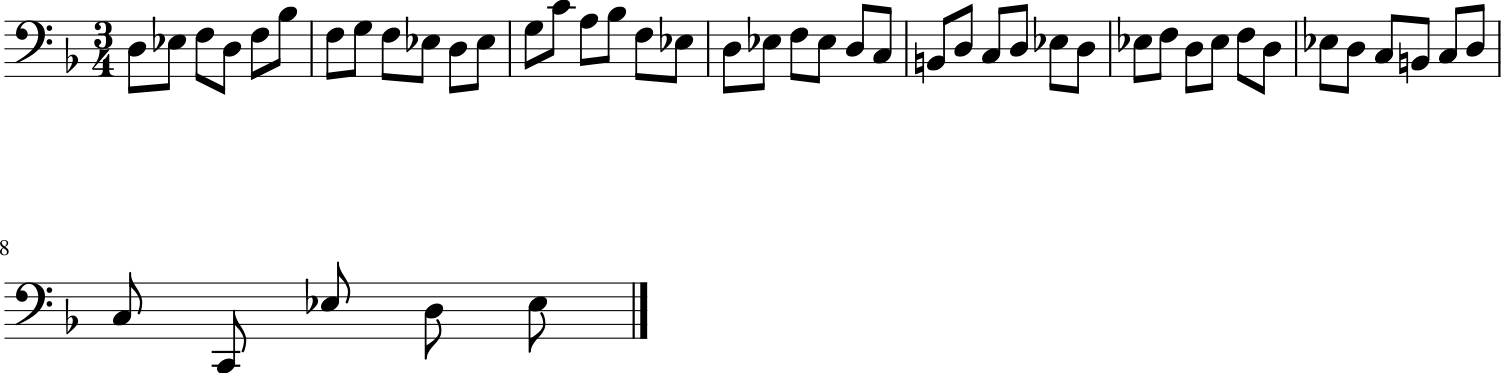

107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - duration_outputs_loss: 0.5480 - loss: 1.8929 - note_outputs_loss: 1.3449
Epoch 33/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5389 - loss: 1.8631 - note_outputs_loss: 1.3242[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('G2'), np.str_('C2'), np.str_('D2'), np.str_('E2'), np.str_('F2'), np.str_('G2'), np.str_('A2'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('D3'), np.str_('F3'), np.str_('A3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3')], ['0.0', n

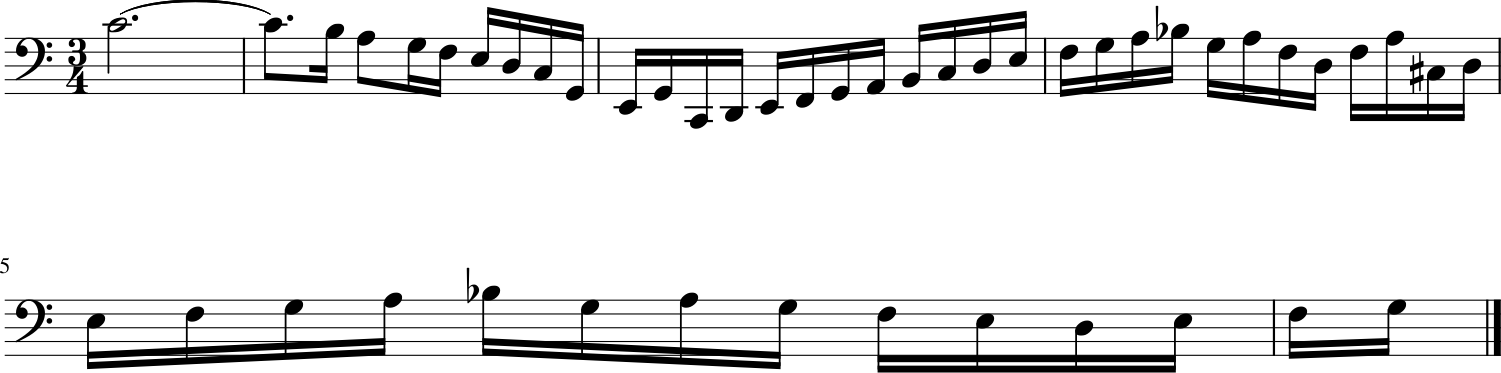

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5389 - loss: 1.8634 - note_outputs_loss: 1.3246
Epoch 34/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5159 - loss: 1.8155 - note_outputs_loss: 1.2996[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('G2'), np.str_('F2'), np.str_('G2'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('G3'), np.str_('B-2'), np.str_('D3'), np.str_('G2'), np.str_('F2'), np.str_('E-2'), np.str_('G2'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('F3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('

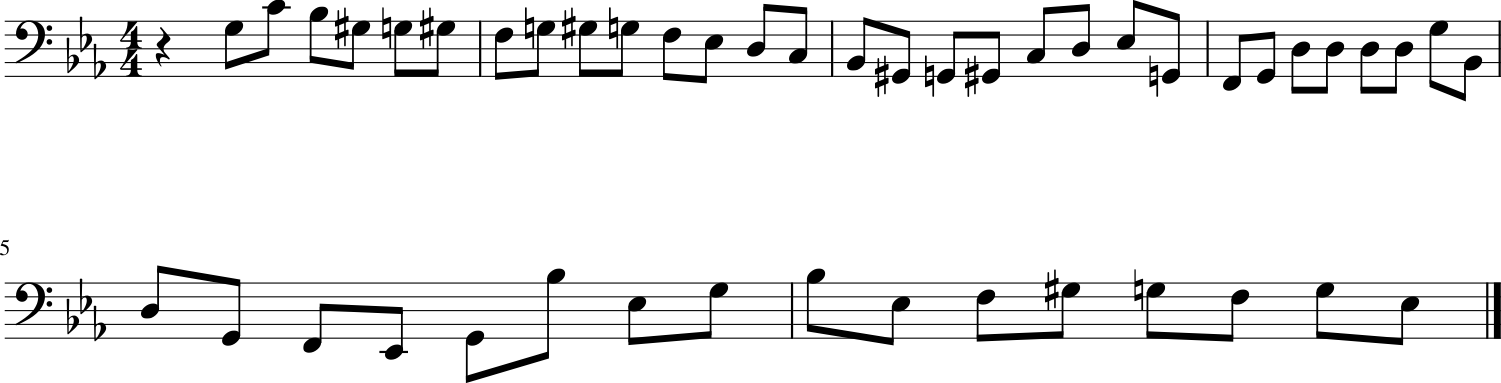

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5162 - loss: 1.8168 - note_outputs_loss: 1.3006
Epoch 35/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4828 - loss: 1.8401 - note_outputs_loss: 1.3573[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str

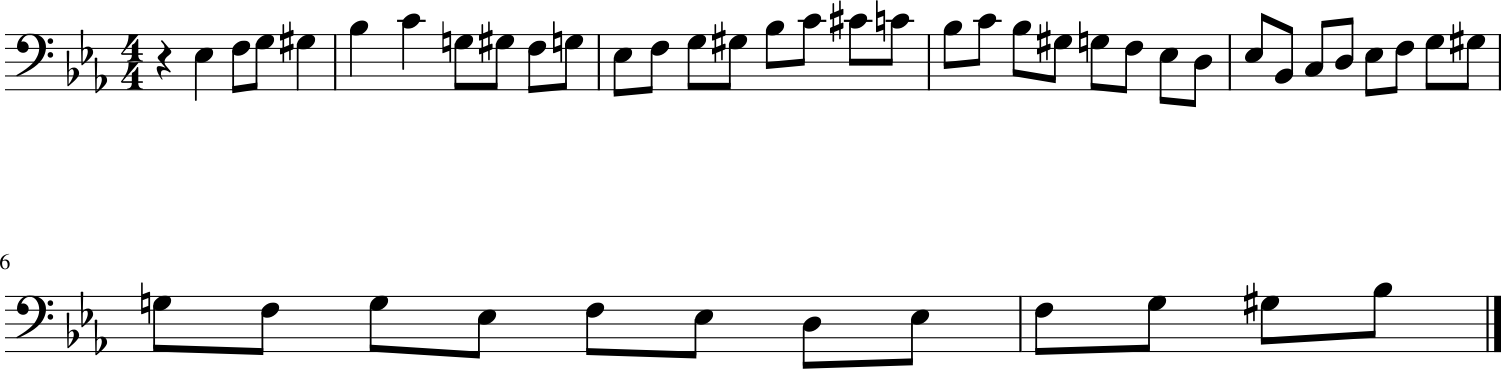

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.4838 - loss: 1.8411 - note_outputs_loss: 1.3573
Epoch 36/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5362 - loss: 1.8697 - note_outputs_loss: 1.3336[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.

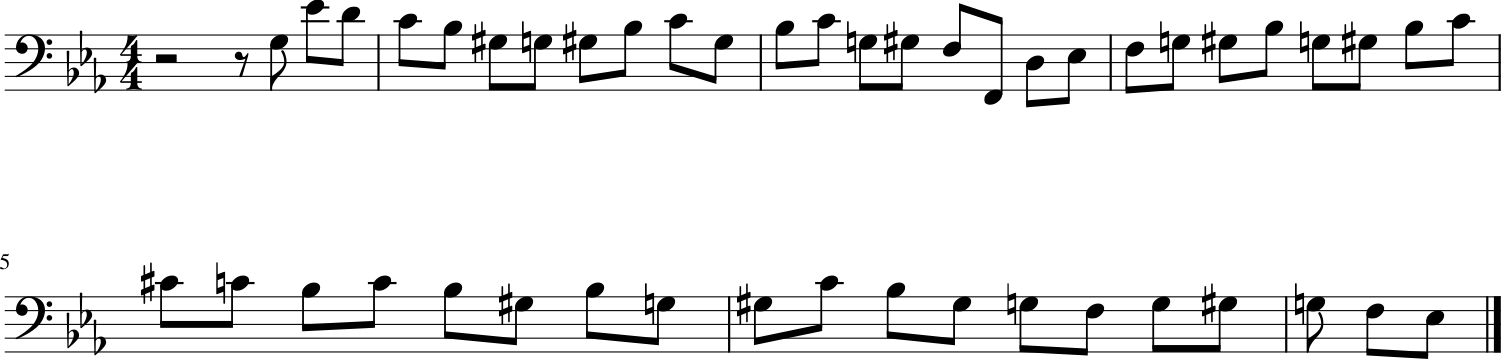

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - duration_outputs_loss: 0.5362 - loss: 1.8699 - note_outputs_loss: 1.3337
Epoch 37/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - duration_outputs_loss: 0.5297 - loss: 1.8354 - note_outputs_loss: 1.3058[['START', np.str_('D:major'), np.str_('3/2TS'), np.str_('F#4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str_('C#4'), np.str_('D4'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('E4'), np.str_('D4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('C#4'), np.str_('B3'), np.str_('D4'), np.str_('D4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C#4'), np.str_('D4'), np.str_('C#4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('E4'), np.str_('C#4'), np.str_('B3'), np.str_('E4'), np.str_('C#4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('E4'), np.str

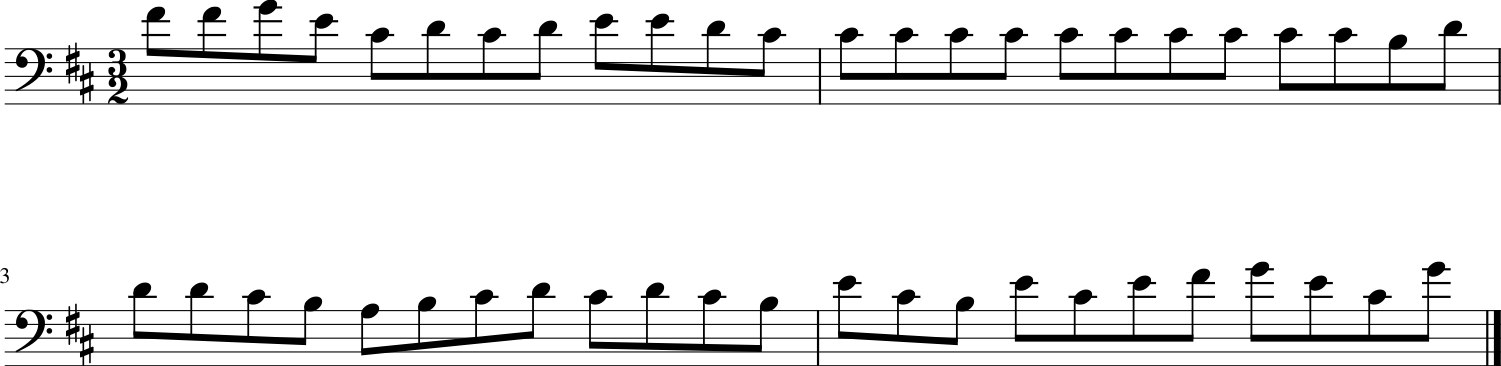

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5298 - loss: 1.8362 - note_outputs_loss: 1.3064
Epoch 38/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5498 - loss: 1.8091 - note_outputs_loss: 1.2593[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('C4'), np.str_('F3'), np.str_('C4'), np.str_('F3'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('F2'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('B-2'), np.str_

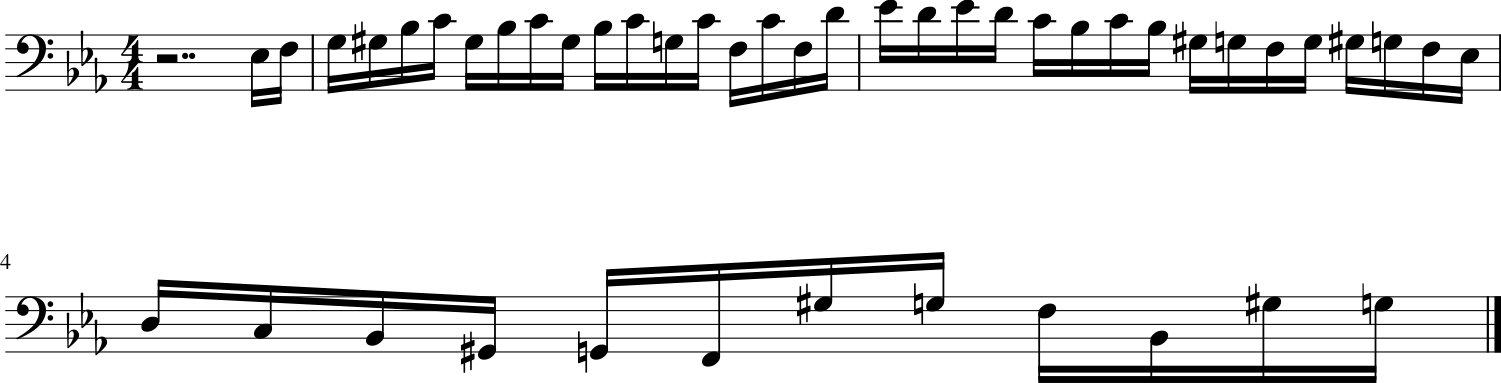

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5494 - loss: 1.8100 - note_outputs_loss: 1.2605
Epoch 39/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - duration_outputs_loss: 0.5152 - loss: 1.8122 - note_outputs_loss: 1.2970[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G2'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('F4'), np.str_('D3'), np.str_('F4'), np.str_('D3'), np.str_('B3'), np.str_('D3'), np.str_('E3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('E4'), np.str_('C4'), np.str_('B3')], 

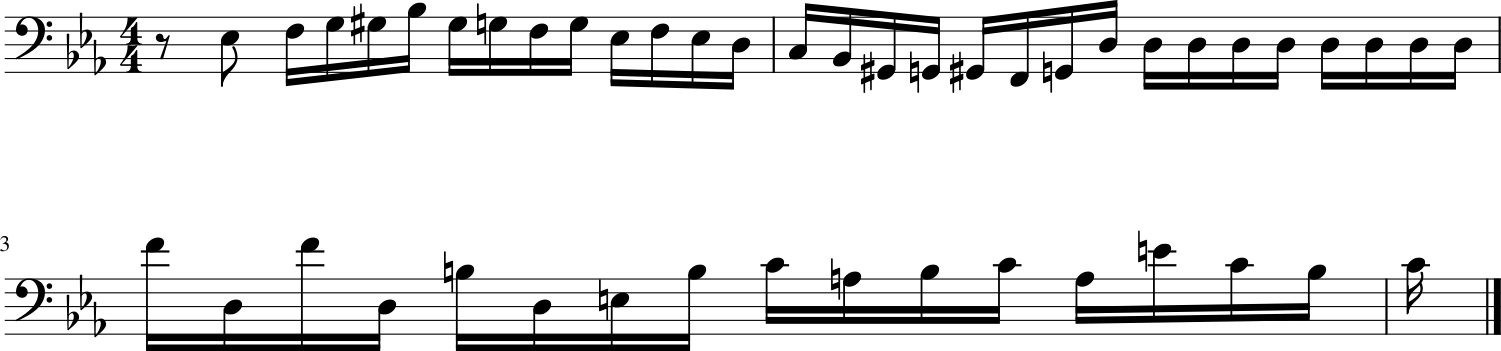

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5156 - loss: 1.8130 - note_outputs_loss: 1.2974
Epoch 40/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5573 - loss: 1.8797 - note_outputs_loss: 1.3223[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('A3'), np.str_('A2'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('F2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G#2'), np.str_('D3'), np.str_('C3'), np.str_('C3'), np.str_('C3

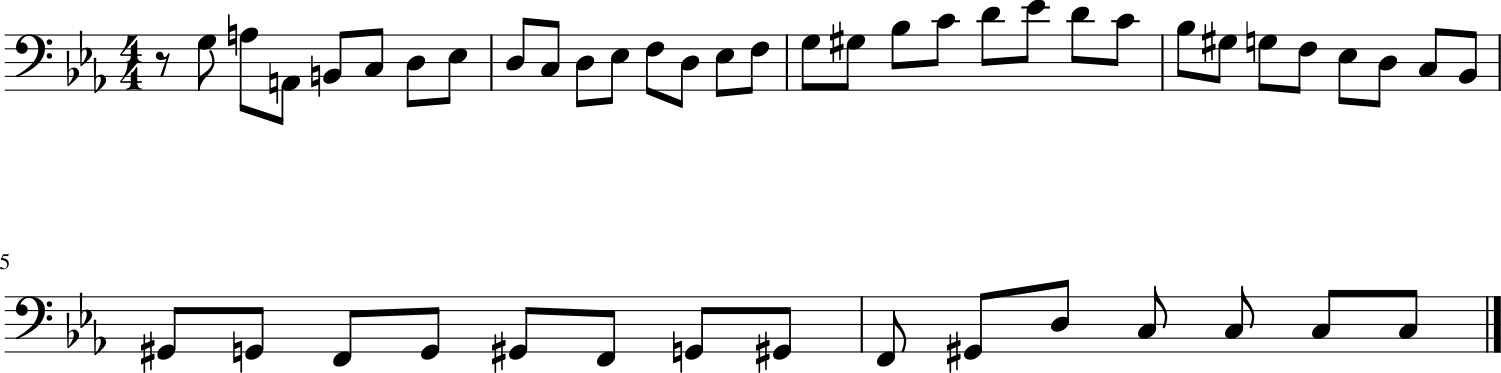

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5571 - loss: 1.8794 - note_outputs_loss: 1.3222
Epoch 41/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4928 - loss: 1.7470 - note_outputs_loss: 1.2541[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B2'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('F3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('G#2'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('C3'), np.str_('F3')], ['0.0', np.

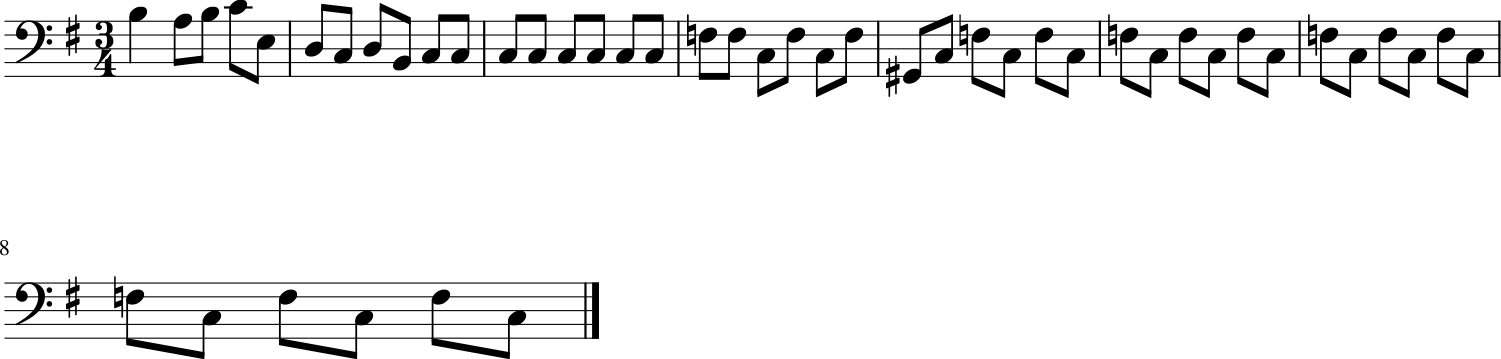

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.4936 - loss: 1.7486 - note_outputs_loss: 1.2550
Epoch 42/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5357 - loss: 1.7914 - note_outputs_loss: 1.2557[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('D3'), np.str_('G2'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2')], ['0.0',

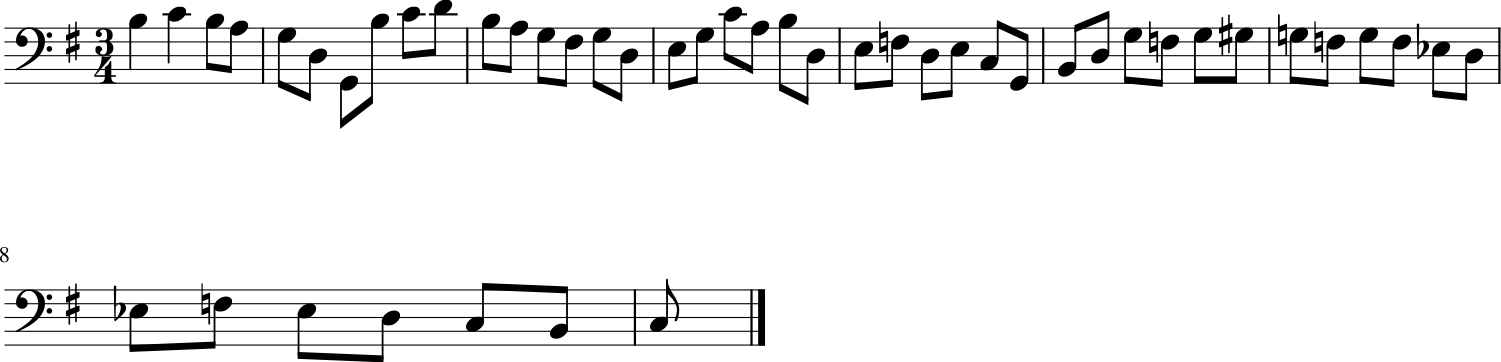

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5357 - loss: 1.7917 - note_outputs_loss: 1.2560
Epoch 43/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5338 - loss: 1.8022 - note_outputs_loss: 1.2684[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('A3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('F2'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('C#3'), np.str_('D3'), np.str_('B-2'), np.str_('A2'), np.str_('G2'), np.str_('A2'), np.str_('F2'), np.str_('E2')], ['0.0

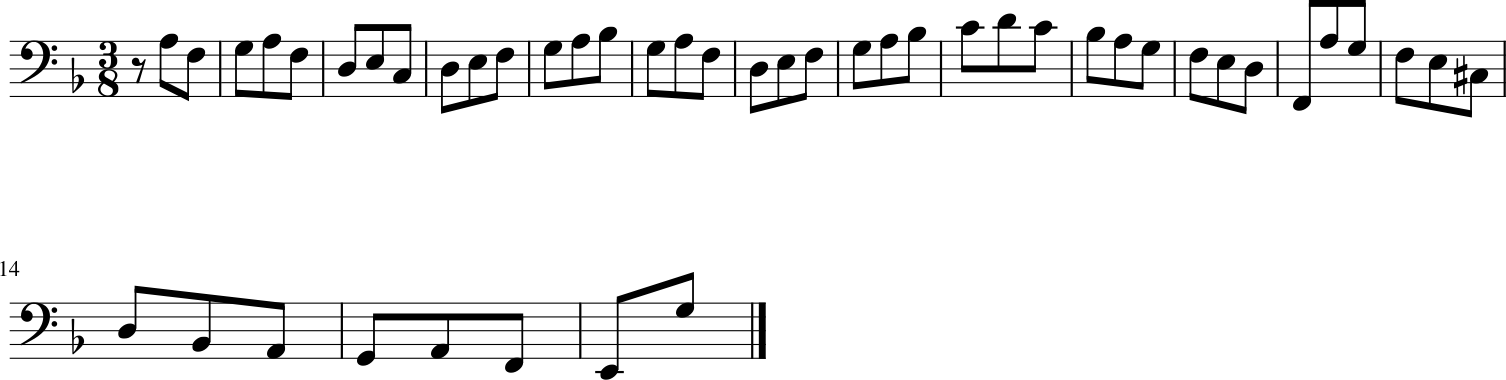

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.5338 - loss: 1.8025 - note_outputs_loss: 1.2687
Epoch 44/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5528 - loss: 1.7753 - note_outputs_loss: 1.2224[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('E-3'), np.str_('B-2'), np.str_('C3'), np.str_('G#2'), np.str_('C3'), np.str_('G2'), np.str_('F2'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('C3'), np.str_('G2'), np.str_('F2'), np.str_('G#2'), np.str_('D3'), np.str_('F3'), np.str_('G#3'), np.str_('C3'), np.str_('B2'), np.str_('D3'), np.str_('G#3'), np.str_('B-2'), np.str_('D3'), np.str_('F3'), np.str_('E-2'), np.str_('

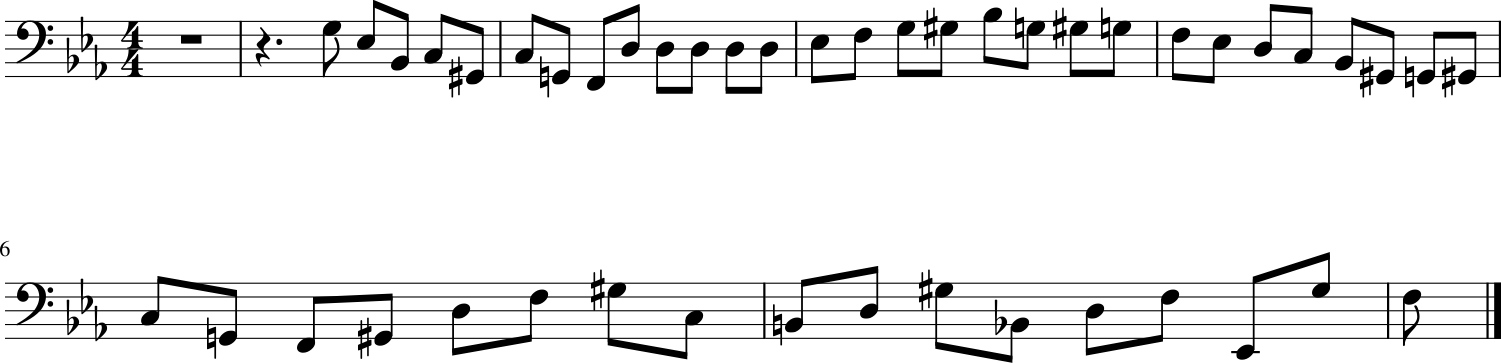

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5527 - loss: 1.7756 - note_outputs_loss: 1.2230
Epoch 45/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5437 - loss: 1.7924 - note_outputs_loss: 1.2487[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C#4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C4'), np.str_('G#3'), np.str_('E-3'), np.str_('F2'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('G#3'), np.str_('G3')

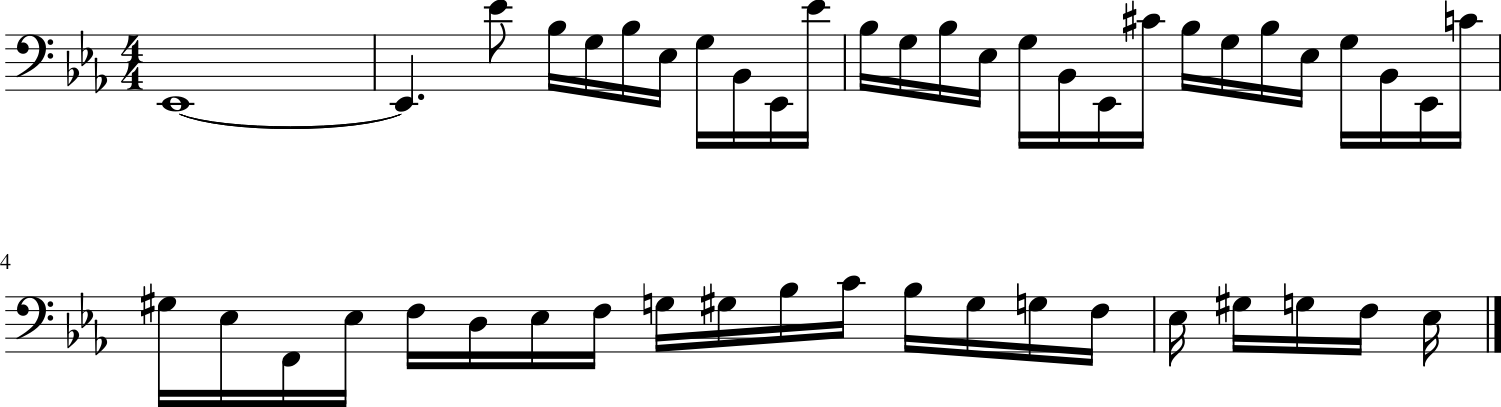

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5435 - loss: 1.7926 - note_outputs_loss: 1.2491
Epoch 46/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5039 - loss: 1.6966 - note_outputs_loss: 1.1928[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('G3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('F#3'), np.str_('B2'), np.str_('D3'), np.str_('G#3'), np.str_('A3'), np.str_('B3'), np.str_('D4'), np.str_('A2'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('E-3'), np.str_('F#3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3')], ['0

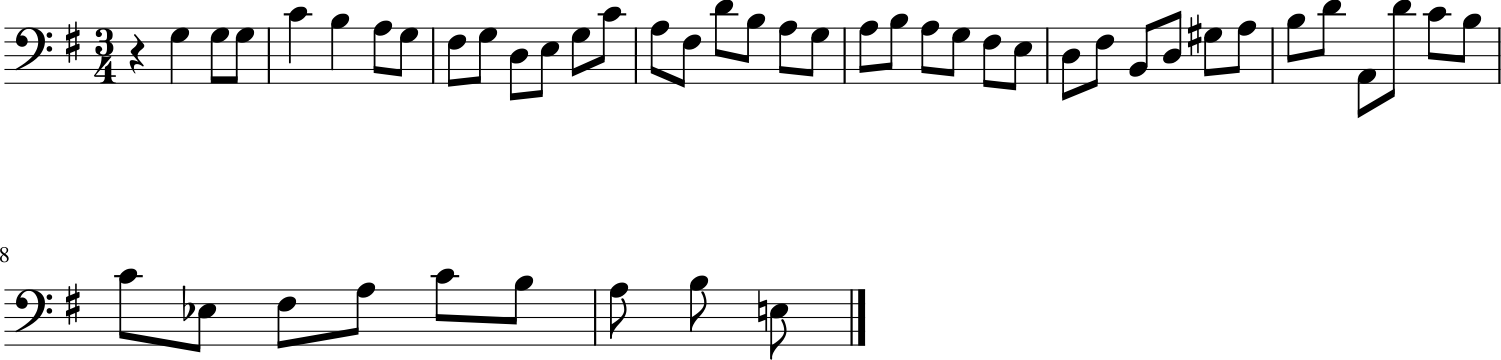

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - duration_outputs_loss: 0.5041 - loss: 1.6975 - note_outputs_loss: 1.1934
Epoch 47/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5099 - loss: 1.7340 - note_outputs_loss: 1.2241[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('G3'), np.str_('D3'), np.str_('G2'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('E-3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('E-4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'

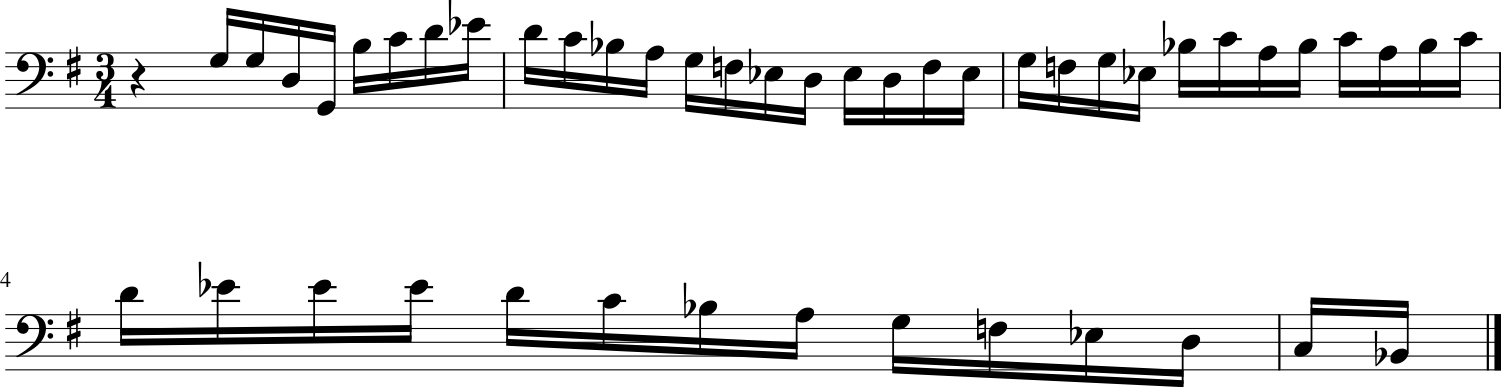

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5101 - loss: 1.7344 - note_outputs_loss: 1.2243
Epoch 48/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - duration_outputs_loss: 0.5694 - loss: 1.7420 - note_outputs_loss: 1.1725[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('G2'), np.str_('A3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('B3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('G3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('C3'), np.str_('B2'), np.str_('E3'), np.str_('F3'), np.str_('A2'), np.str_('G2'), np.str_('E3'), np.str_('F3'), np.str_('F2'), np.str_('E2'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('E3')], ['0.0', np.s

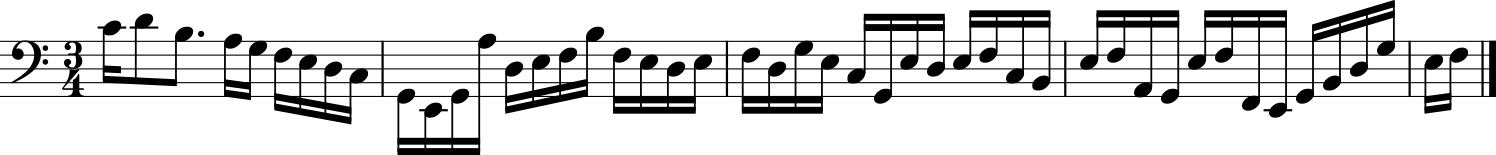

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5684 - loss: 1.7433 - note_outputs_loss: 1.1749
Epoch 49/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5471 - loss: 1.7214 - note_outputs_loss: 1.1742[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('G3'), np.str_('G2'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('G3'), np.str_('G2'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('G3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('G2'), np.str_('B3'), np.str_('G2'), np.str_('G2'), np.str_('G2'), np.str_('G2')], ['0.0', np

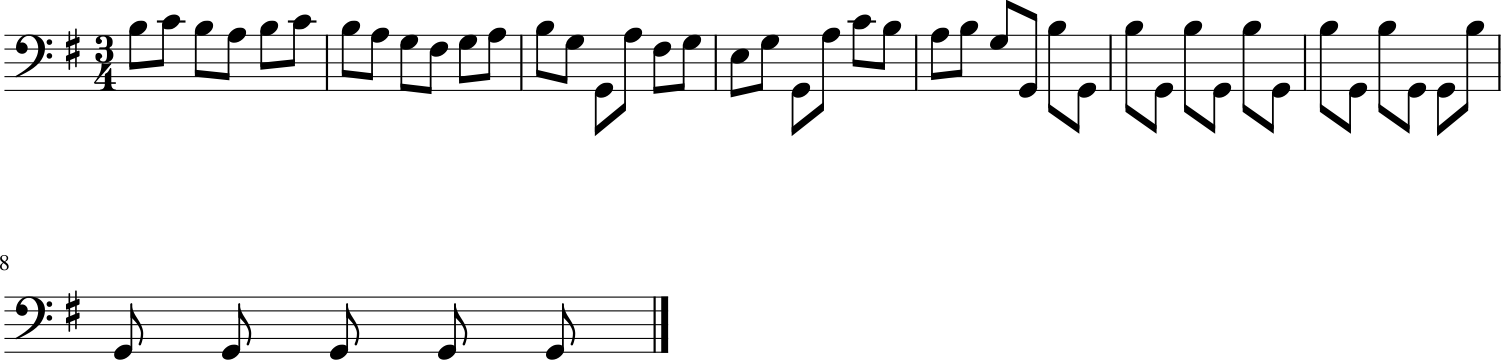

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5470 - loss: 1.7219 - note_outputs_loss: 1.1748
Epoch 50/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5170 - loss: 1.7016 - note_outputs_loss: 1.1846[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('F#3'), np.str_('D3'), np.str_('F#3'), np.str_('B2'), np.str_('D3'), np.str_('G2'), np.str_('D3'), np.str_('F#3'), np.str_('A3'), np.str_('B3'), np.str_('D3'), np.str_('F#3'), np.str_('D3'), np.str_('B3'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('D3'), np.str_('B3'), np.str_('C3'), np.str_('C2'), np.str_('D3'), np.str_('F3'), np.str_('D3'), np.str_('F3'), np.str_('D3'), np.str_('E3')], ['0.0',

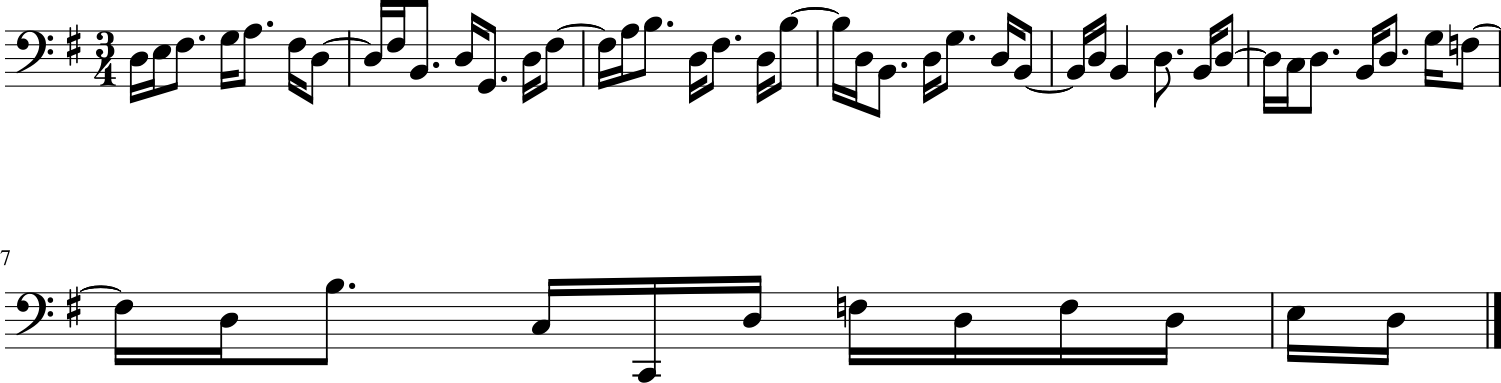

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5172 - loss: 1.7024 - note_outputs_loss: 1.1852
Epoch 51/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5242 - loss: 1.7008 - note_outputs_loss: 1.1766[['START', np.str_('G:major'), np.str_('6/8TS'), np.str_('rest'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('D3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('C#3'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('A3'), np.str_('G4'), np.str_('D3'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('F#4')], ['0

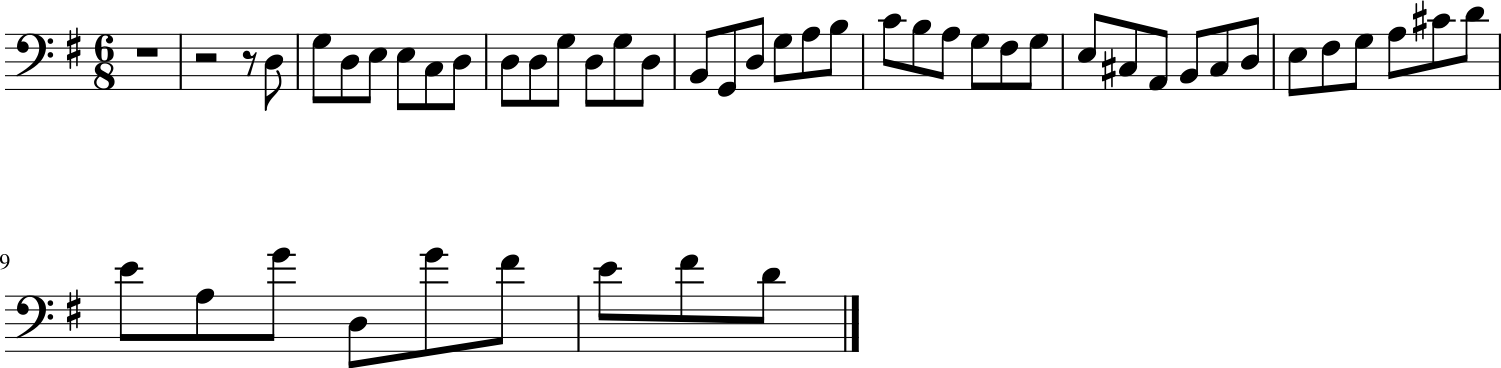

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5243 - loss: 1.7014 - note_outputs_loss: 1.1771
Epoch 52/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5295 - loss: 1.6886 - note_outputs_loss: 1.1591[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('C#4'), np.str_('D4'), np.str_('A3'), np.str_('F3'), np.str_('D3'), np.str_('D3'), np.str_('F3'), np.str_('D3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('G3'), np.str_('D4')], [

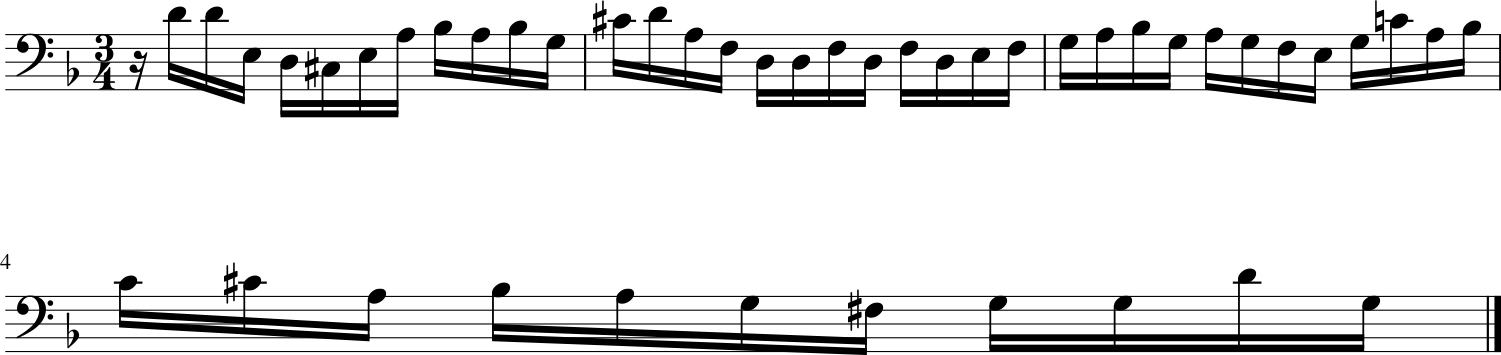

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - duration_outputs_loss: 0.5295 - loss: 1.6891 - note_outputs_loss: 1.1596
Epoch 53/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - duration_outputs_loss: 0.5443 - loss: 1.7223 - note_outputs_loss: 1.1780[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('A3'), np.str_('B-3'), np.str_('B-3'), np.str_('G#3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('C2'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'

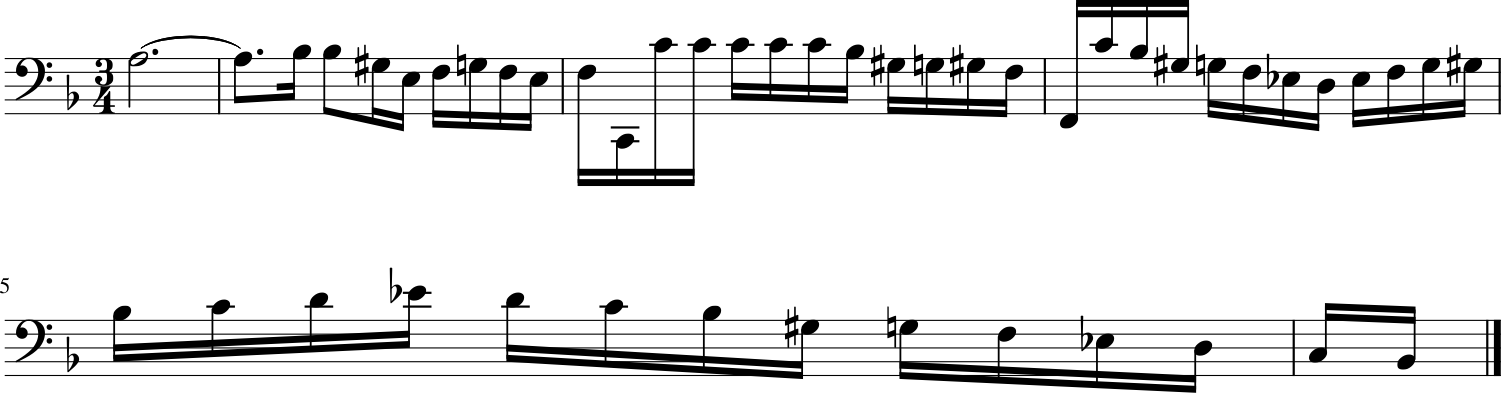

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5442 - loss: 1.7225 - note_outputs_loss: 1.1783
Epoch 54/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5227 - loss: 1.7102 - note_outputs_loss: 1.1875[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('G3'), np.str_('D3'), np.str_('G2'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('F3

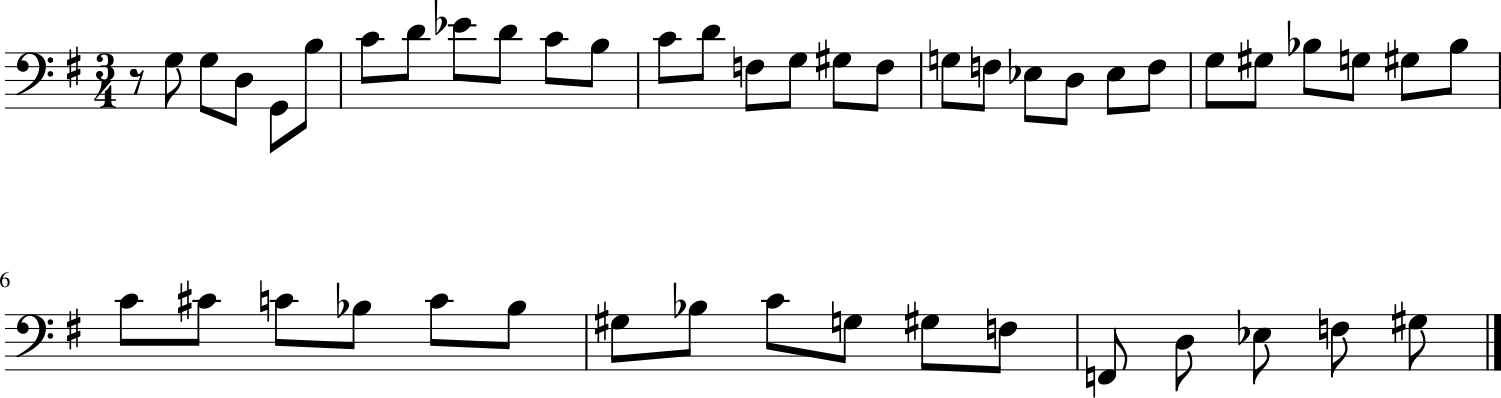

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step - duration_outputs_loss: 0.5228 - loss: 1.7105 - note_outputs_loss: 1.1877
Epoch 55/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5513 - loss: 1.6701 - note_outputs_loss: 1.1187[['START', np.str_('G:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('B3'), np.str_('B3'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('A2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('C#2')

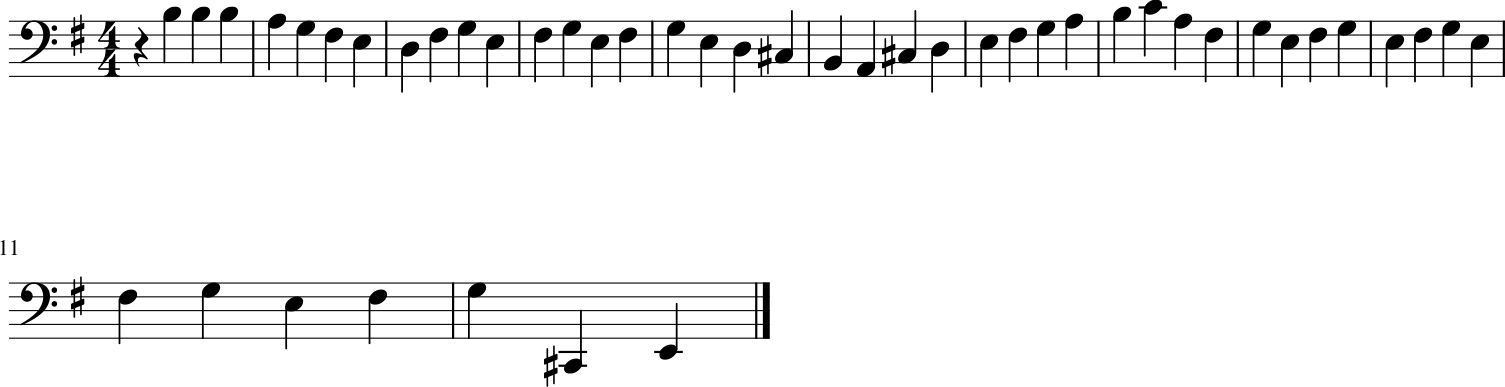

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5512 - loss: 1.6707 - note_outputs_loss: 1.1195
Epoch 56/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5121 - loss: 1.7018 - note_outputs_loss: 1.1897[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str

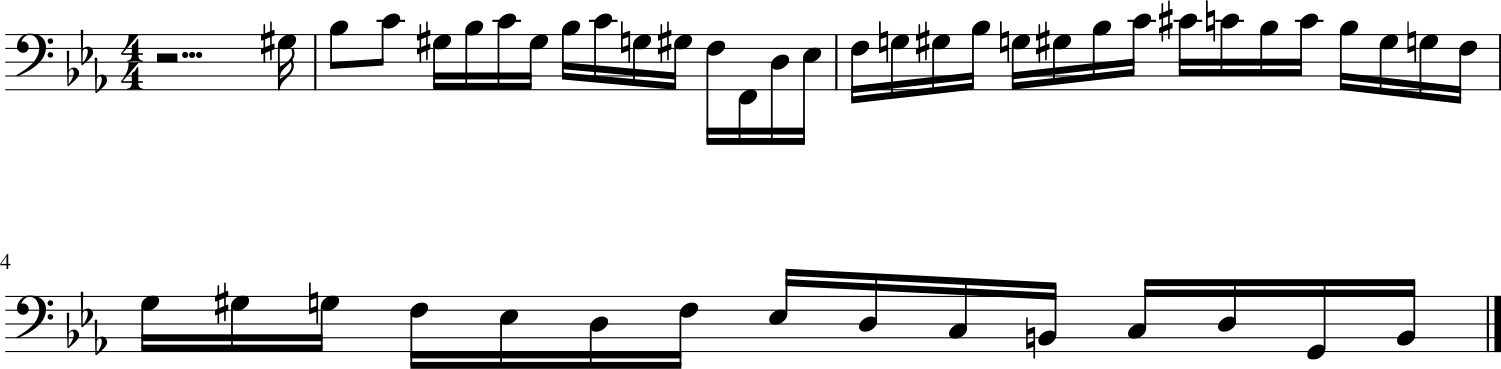

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5124 - loss: 1.7025 - note_outputs_loss: 1.1901
Epoch 57/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5065 - loss: 1.7053 - note_outputs_loss: 1.1988[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('E-2'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('C#3'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('C#4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('A2'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D4')], ['

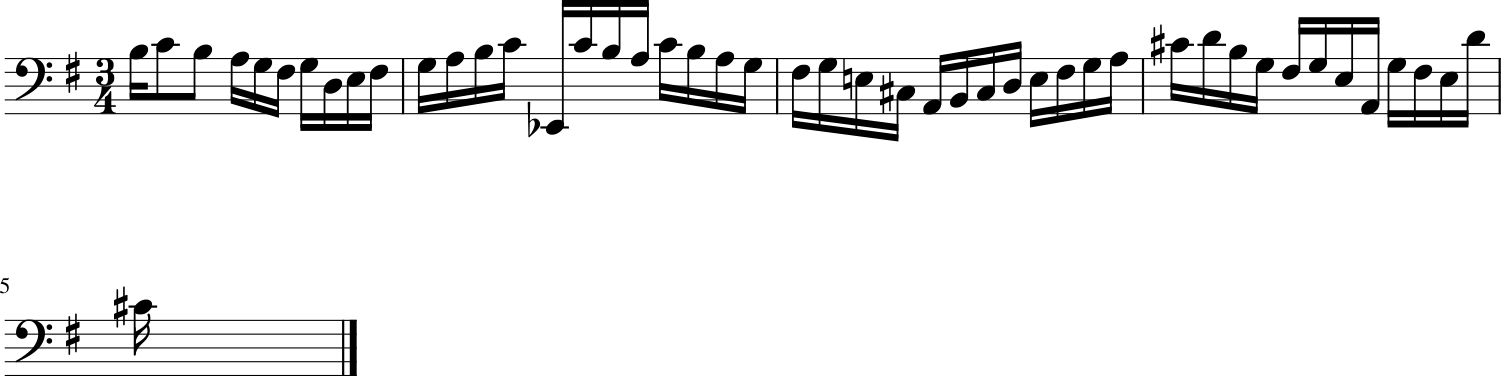

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - duration_outputs_loss: 0.5067 - loss: 1.7055 - note_outputs_loss: 1.1988
Epoch 58/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5322 - loss: 1.6965 - note_outputs_loss: 1.1644[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('A2'), np.str_('G2'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('G3'), np.str_('E3'), np.str_('D3')], ['0.0', np.

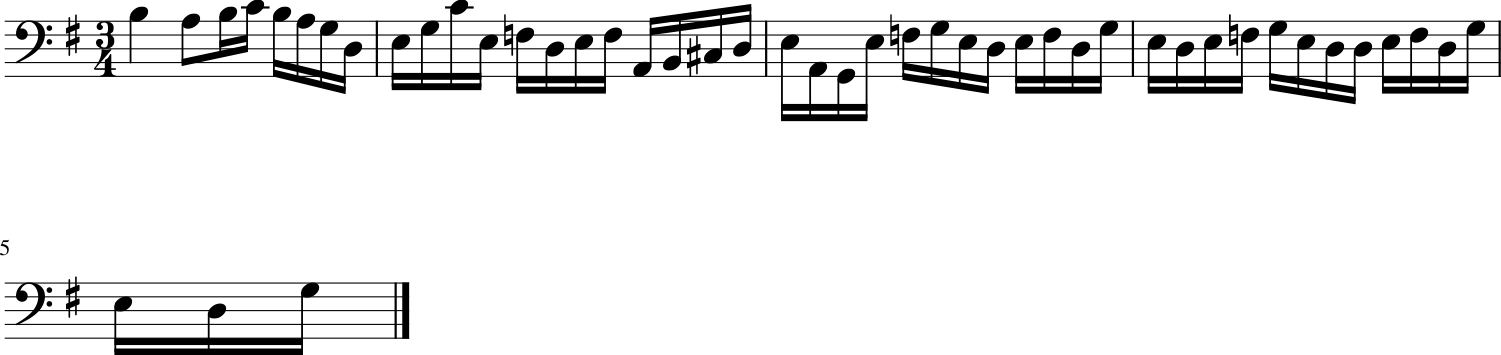

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.5322 - loss: 1.6969 - note_outputs_loss: 1.1647
Epoch 59/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5195 - loss: 1.6890 - note_outputs_loss: 1.1695[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('B2'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G#3'), np.str_('A3'), np.str_('F#3'), np.str_('G#3'), np.str_('F#3'), np.str_('E3')],

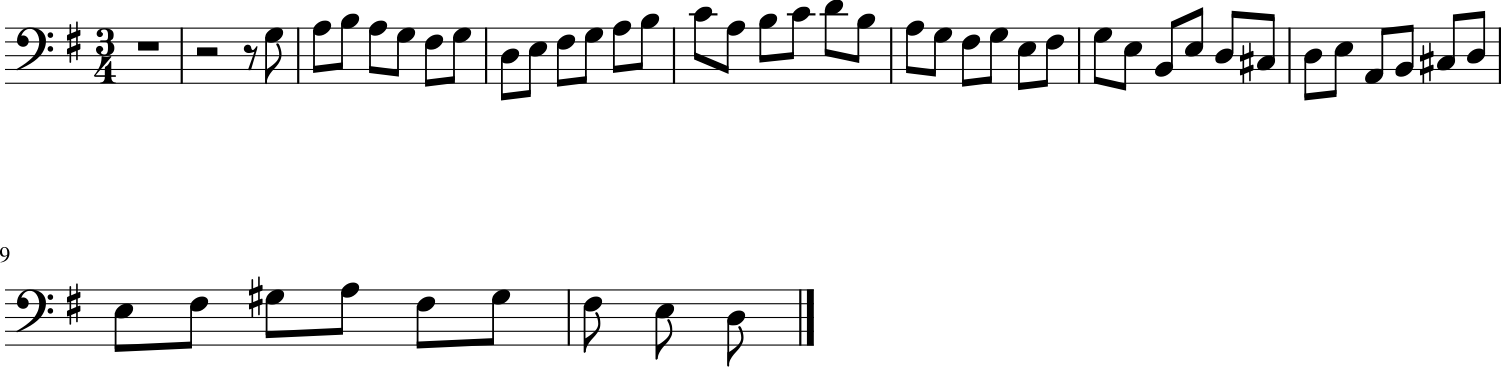

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5198 - loss: 1.6895 - note_outputs_loss: 1.1698
Epoch 60/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5282 - loss: 1.6649 - note_outputs_loss: 1.1367[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('A3'), np.str_('A3'), np.str_('D3'), np.str_('B-3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('A2'), np.str_('A3'), np.str_('B-3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('A3')], [

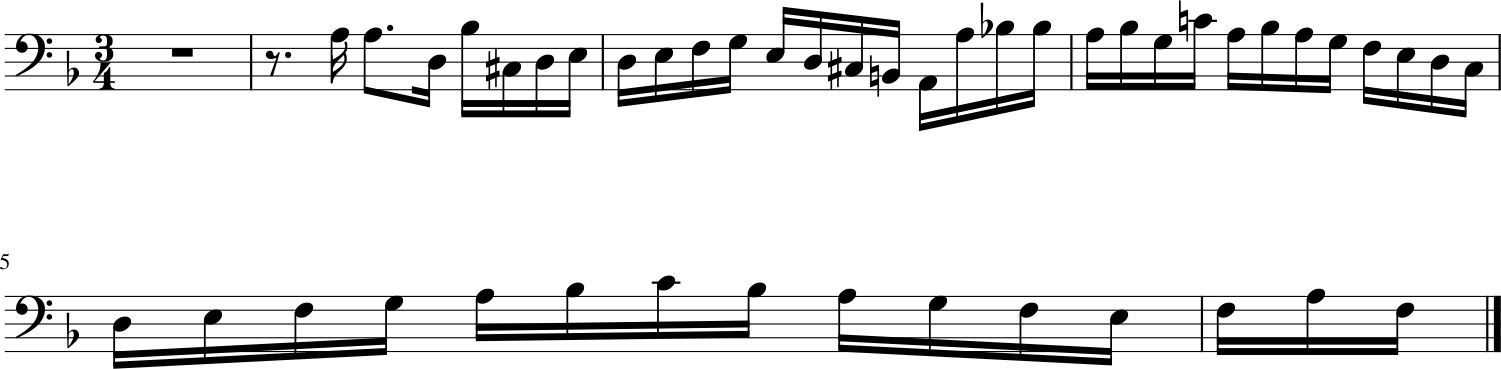

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5283 - loss: 1.6658 - note_outputs_loss: 1.1374
Epoch 61/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4996 - loss: 1.6483 - note_outputs_loss: 1.1487[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('G3'), np.str_('D3'), np.str_('G2'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('F#2'), np.str_('A2'), np.str_('D3'), np.str_('C3'), np.str_('A2'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('F#2'), np.str_('G2'), np.str_('E2'), np.str_('C#3'), np.str_('B2'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('A2'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('C#3'), np.str_('A2'), np.str_('F#3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('G3')], [

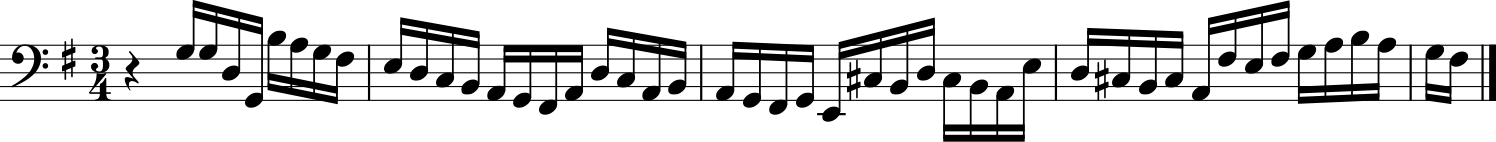

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5003 - loss: 1.6494 - note_outputs_loss: 1.1491
Epoch 62/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - duration_outputs_loss: 0.5338 - loss: 1.6742 - note_outputs_loss: 1.1404[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('C4'), np.str_('G3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('C2'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('F2'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('C2'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('G#3')], ['0.0', n

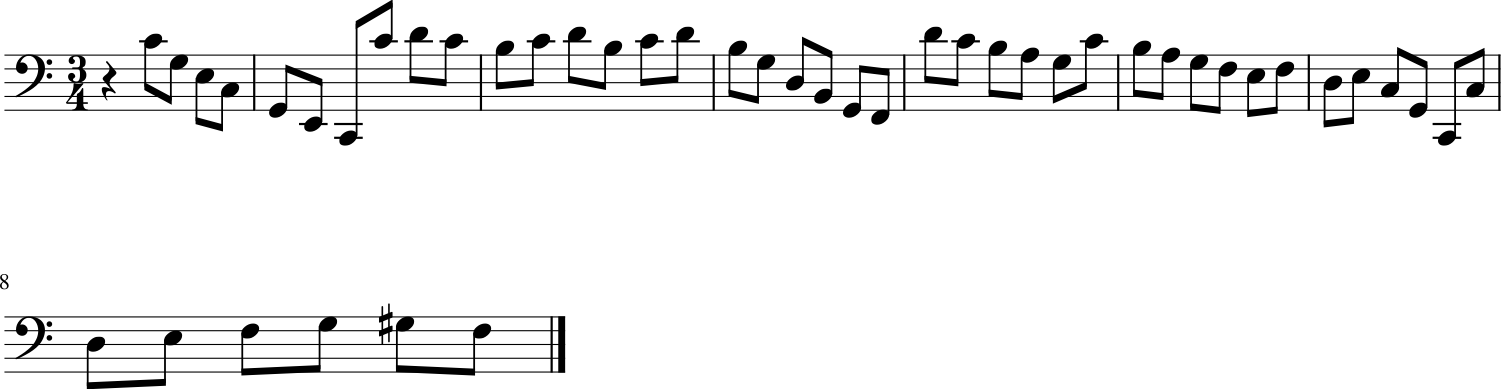

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5338 - loss: 1.6747 - note_outputs_loss: 1.1410
Epoch 63/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5407 - loss: 1.6515 - note_outputs_loss: 1.1108[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('C4'), np.str_('G3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('C2'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('F2'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('F#3'), np.str_('C3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2'), np.str_('G3'), np.str_('D3')], ['0.0', 

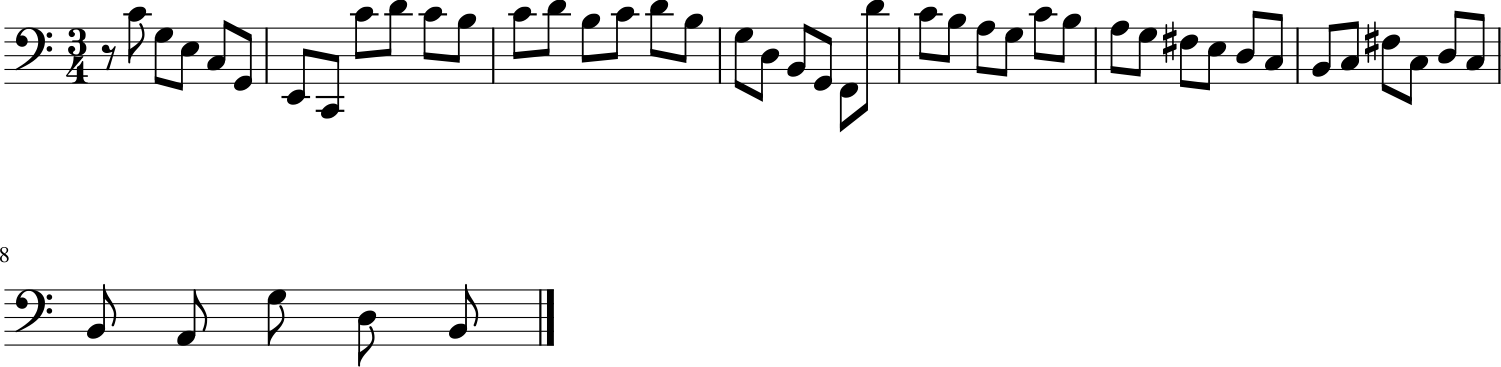

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5406 - loss: 1.6519 - note_outputs_loss: 1.1113
Epoch 64/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5659 - loss: 1.6995 - note_outputs_loss: 1.1337[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('G3'), np.str_('

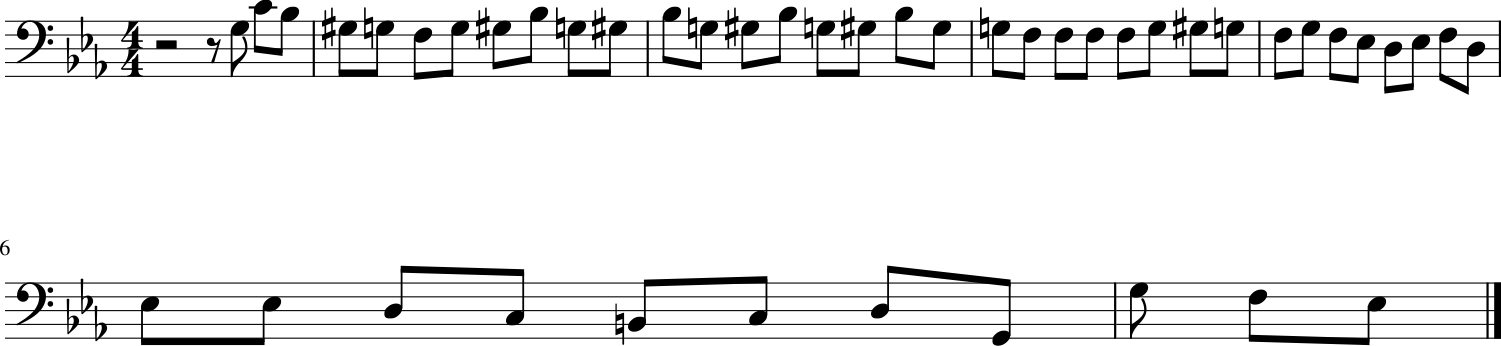

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5653 - loss: 1.6996 - note_outputs_loss: 1.1343
Epoch 65/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5597 - loss: 1.6980 - note_outputs_loss: 1.1383[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str

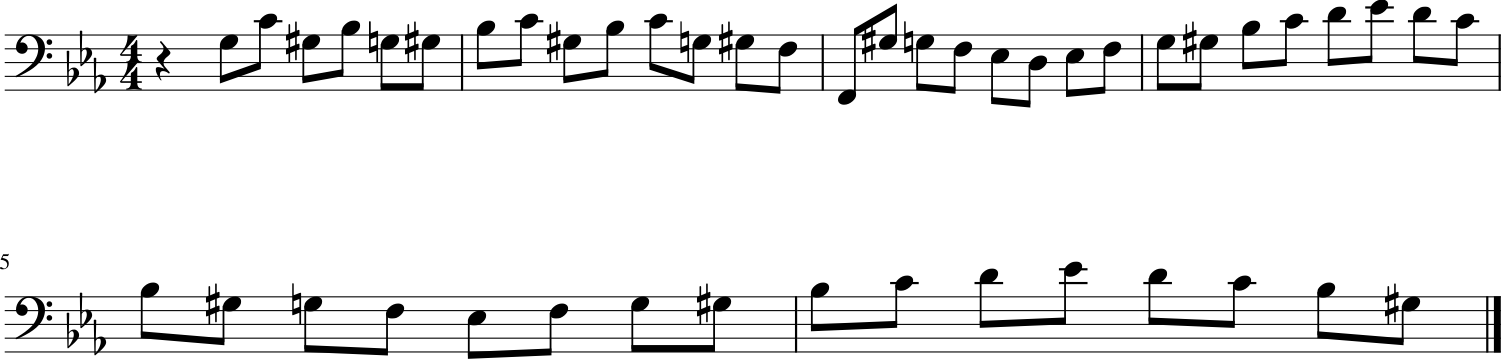

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5592 - loss: 1.6978 - note_outputs_loss: 1.1386
Epoch 66/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5219 - loss: 1.6638 - note_outputs_loss: 1.1419[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('B

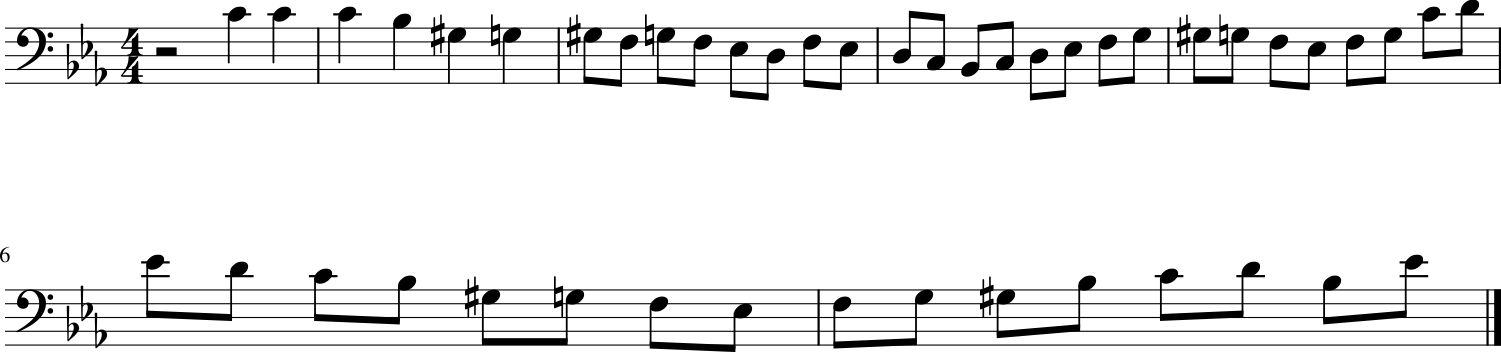

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - duration_outputs_loss: 0.5222 - loss: 1.6642 - note_outputs_loss: 1.1420
Epoch 67/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4814 - loss: 1.5691 - note_outputs_loss: 1.0877[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G#3'), np.str_('E-4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G2'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('C3'), np.str_('C3'), np.str_('G2'), np.str_('F2'), np.str_('E-2'), np.str_('F2'), np.str_('G2'), np.str_('C4'), np.str_('rest')], ['0.0', np.str_('0.0'), np.str_('0.0'), np.str_('1.0'), np.str_('0.25'), np.str_('0.25'), np.str_('

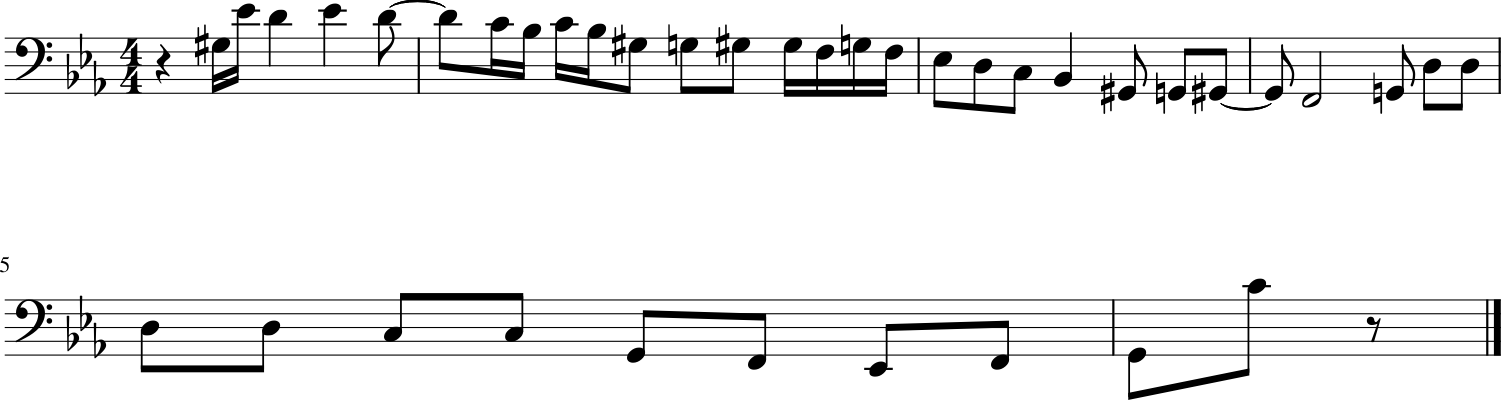

107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - duration_outputs_loss: 0.4819 - loss: 1.5702 - note_outputs_loss: 1.0883
Epoch 68/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - duration_outputs_loss: 0.5307 - loss: 1.6208 - note_outputs_loss: 1.0901[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('A3'), np.str_('F3'), np.str_('E-3'), np.str_('E-3'), np.str_('C3'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('C4'), np.str_('G3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3

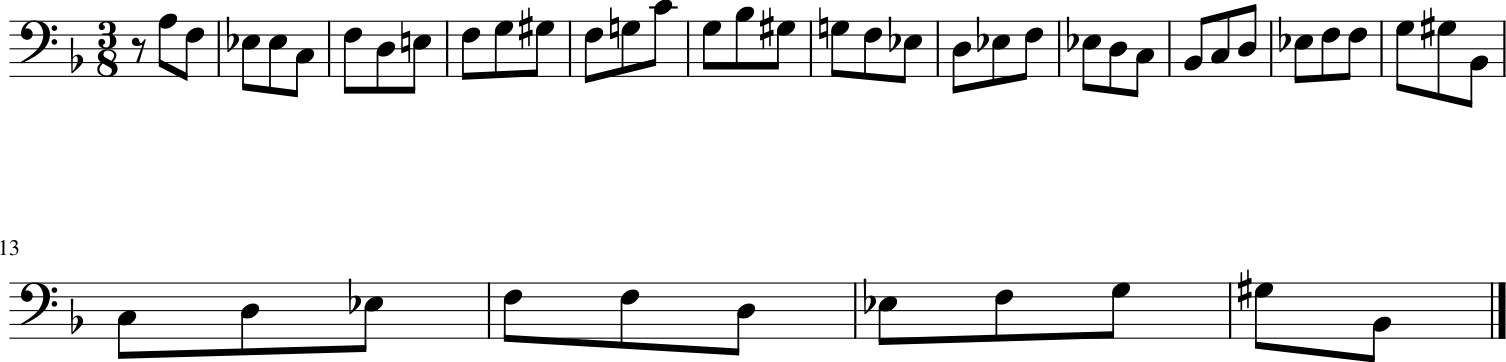

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5307 - loss: 1.6212 - note_outputs_loss: 1.0906
Epoch 69/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5818 - loss: 1.6978 - note_outputs_loss: 1.1160[['START', np.str_('F:major'), np.str_('3/8TS'), np.str_('rest'), np.str_('A3'), np.str_('F3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3')], ['0.0',

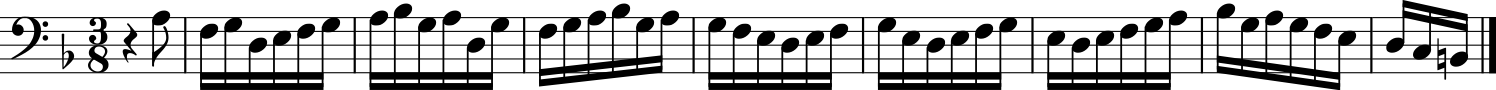

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - duration_outputs_loss: 0.5808 - loss: 1.6973 - note_outputs_loss: 1.1164
Epoch 70/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5520 - loss: 1.6179 - note_outputs_loss: 1.0659[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('G2'), np.str_('C2'), np.str_('D2'), np.str_('E2'), np.str_('F2'), np.str_('G2'), np.str_('A2'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('F2'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('C3'), np.str_('B-2'), np.str_('A2'), np.str_('G2'), np.str_('F#2'), np.str_('A2'), np.str_('C3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4')], ['0.0',

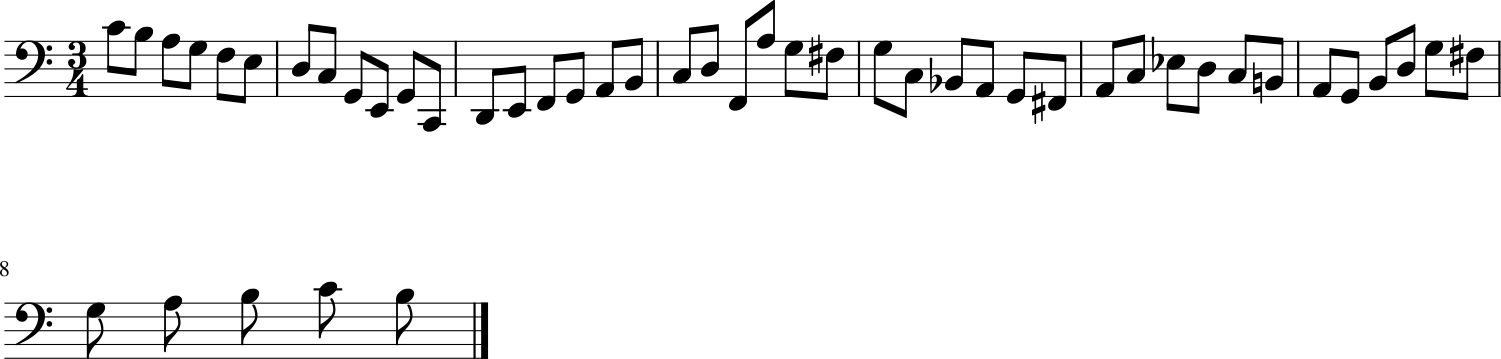

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.5518 - loss: 1.6182 - note_outputs_loss: 1.0664
Epoch 71/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5415 - loss: 1.6370 - note_outputs_loss: 1.0955[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('F3'), np.str_('G3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('E3'), np.str_('D3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('G2'), np.str_('B3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2')], ['0.0', n

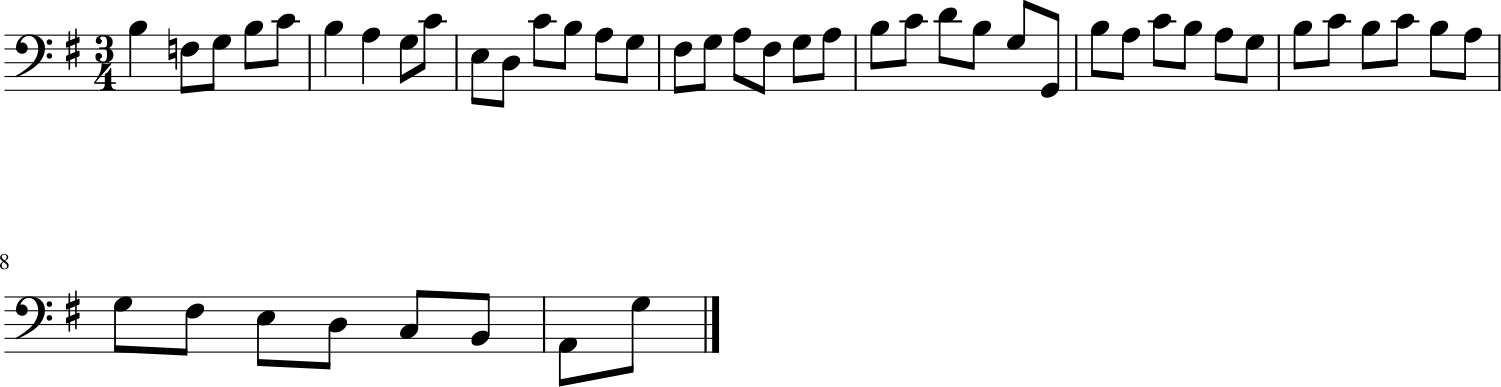

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5414 - loss: 1.6372 - note_outputs_loss: 1.0958
Epoch 72/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5011 - loss: 1.5955 - note_outputs_loss: 1.0944[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('B2'), np.str_('E-3'), np.str_('E2'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('G3'), np.str_('C#3'), np.str_('G#2'), np.str_('G2'), np.str_('G#2'), np.str_('B-2'), np.str_('E3'), np.str_('F3'), np.str_('C3'), np.str_('F3'), np.str_('G#2'), np.str_('C3'), np.str_('F3'), np.str_('G#2'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('B-2'), np.str_('E3'), np.str_('C#3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('C3'), np.str_('F3'), np.str_('G#2'), np.str_('B-2'

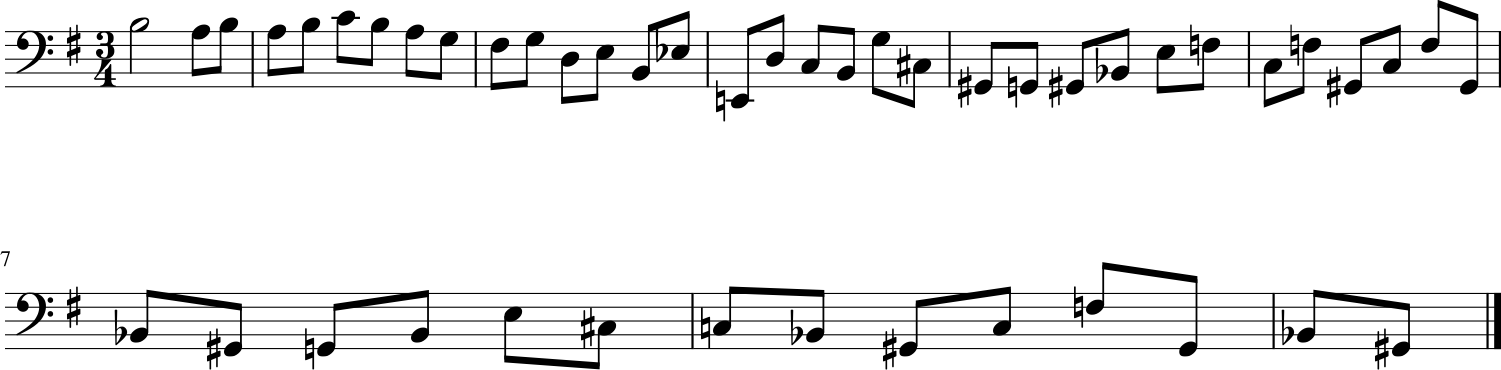

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - duration_outputs_loss: 0.5013 - loss: 1.5960 - note_outputs_loss: 1.0947
Epoch 73/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5093 - loss: 1.5823 - note_outputs_loss: 1.0730[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_

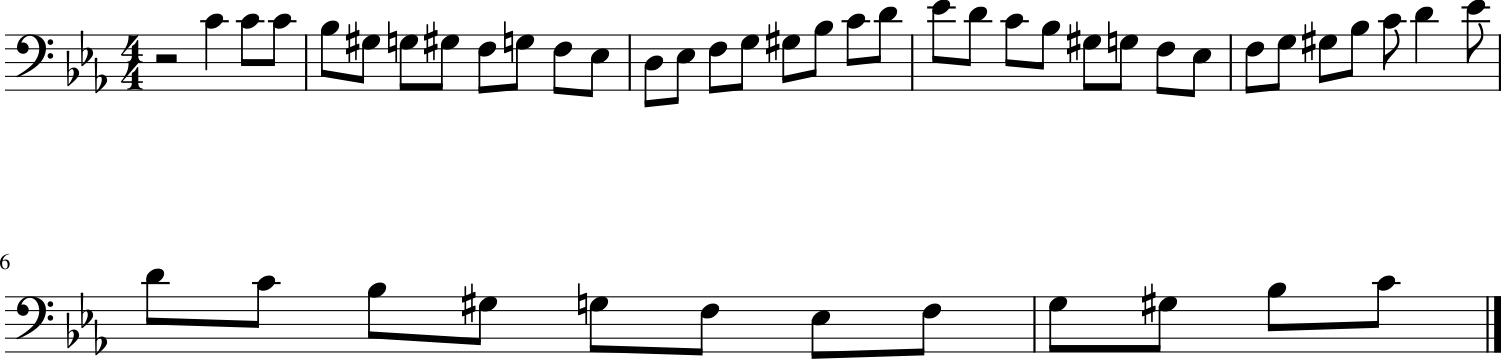

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5098 - loss: 1.5834 - note_outputs_loss: 1.0737
Epoch 74/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5113 - loss: 1.6103 - note_outputs_loss: 1.0991[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('E-3'), np.str_('B-2'), np.str_('C3'), np.str_('G#2'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('E-2'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_

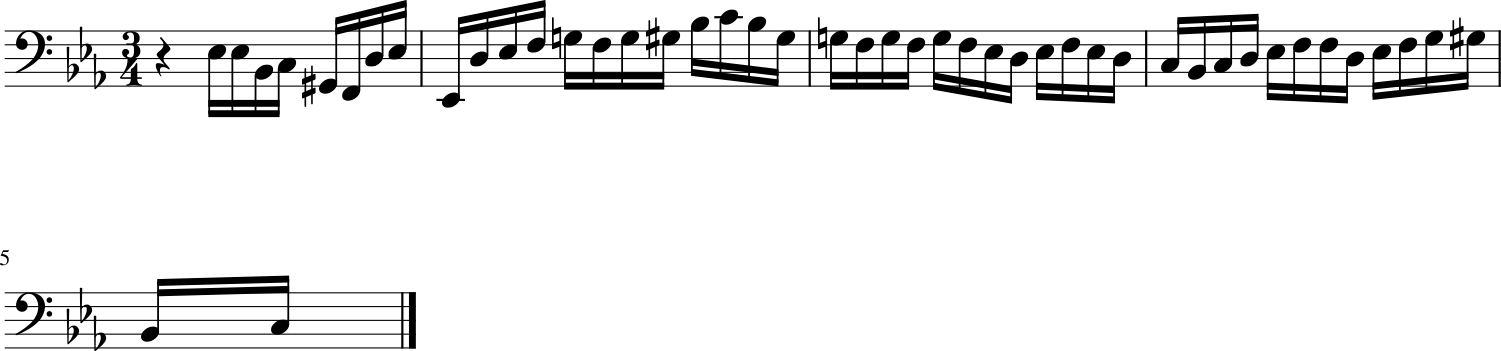

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.5117 - loss: 1.6111 - note_outputs_loss: 1.0994
Epoch 75/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4902 - loss: 1.5629 - note_outputs_loss: 1.0726[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C#4')

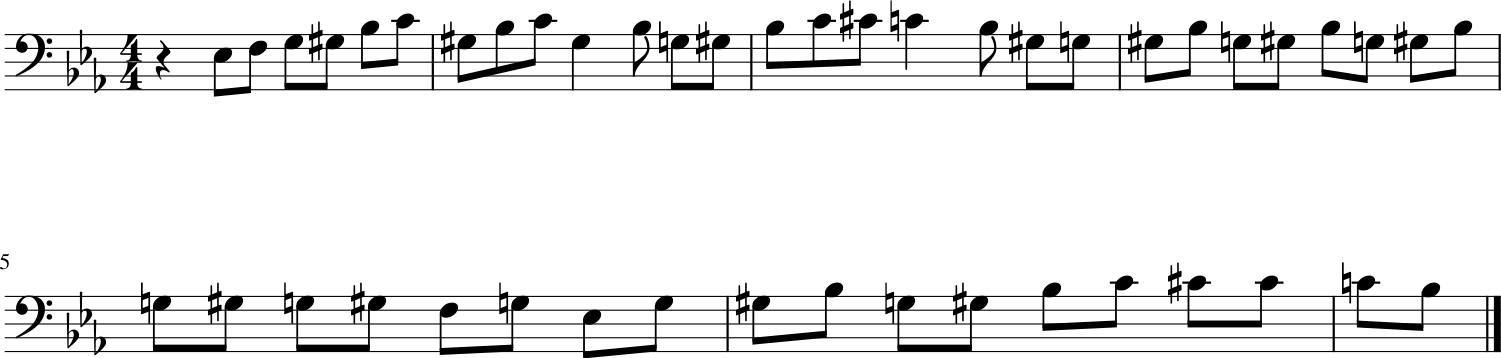

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.4910 - loss: 1.5645 - note_outputs_loss: 1.0735
Epoch 76/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5322 - loss: 1.5893 - note_outputs_loss: 1.0571[['START', np.str_('C:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('G3'), np.str_('E3'), np.str_('C3'), np.str_('G2'), np.str_('E2'), np.str_('C2'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('F2'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('F#2'), np.str_('A2'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('D3')], ['0.0',

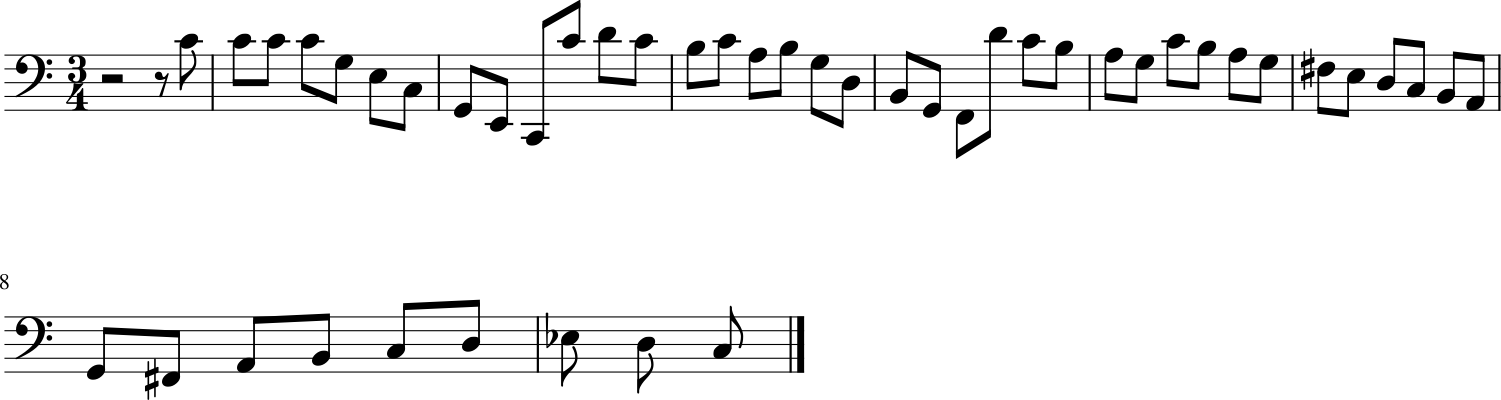

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5323 - loss: 1.5903 - note_outputs_loss: 1.0580
Epoch 77/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4984 - loss: 1.5804 - note_outputs_loss: 1.0821[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('C3'), np.str_('G2'), np.str_('A2'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('C3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('B-3'), np.str_('G3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('C3'), np.str_('D3'), np.str_('F3'), np.str_('B-2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3

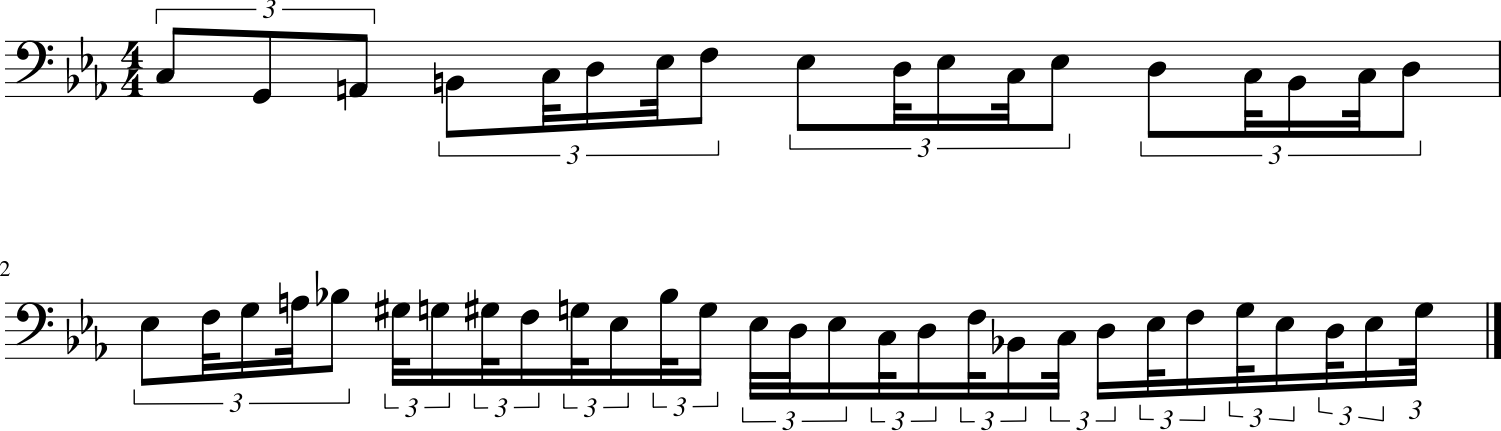

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.4987 - loss: 1.5810 - note_outputs_loss: 1.0823
Epoch 78/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5360 - loss: 1.6436 - note_outputs_loss: 1.1076[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('E-4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C#4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C#4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C#4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('E-2'), np.str_('C4'), np.str_('G#3'), np.str_('E-3'), np.str_('

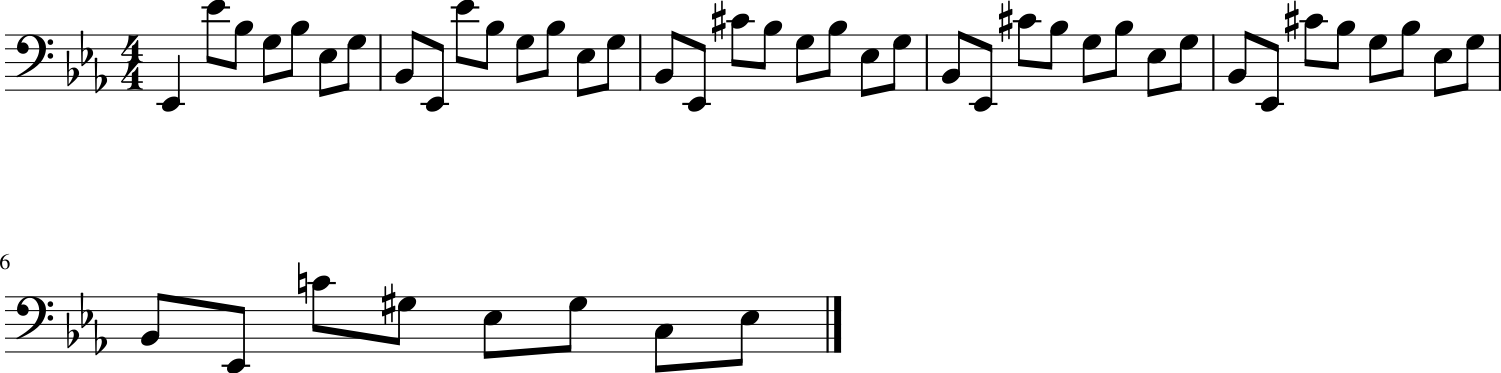

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5360 - loss: 1.6436 - note_outputs_loss: 1.1076
Epoch 79/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.4874 - loss: 1.5538 - note_outputs_loss: 1.0664[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('A2'), np.str_('F#3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('A2'), np.str_('F#3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('C4'), np.str_('B3')], ['0.0', 

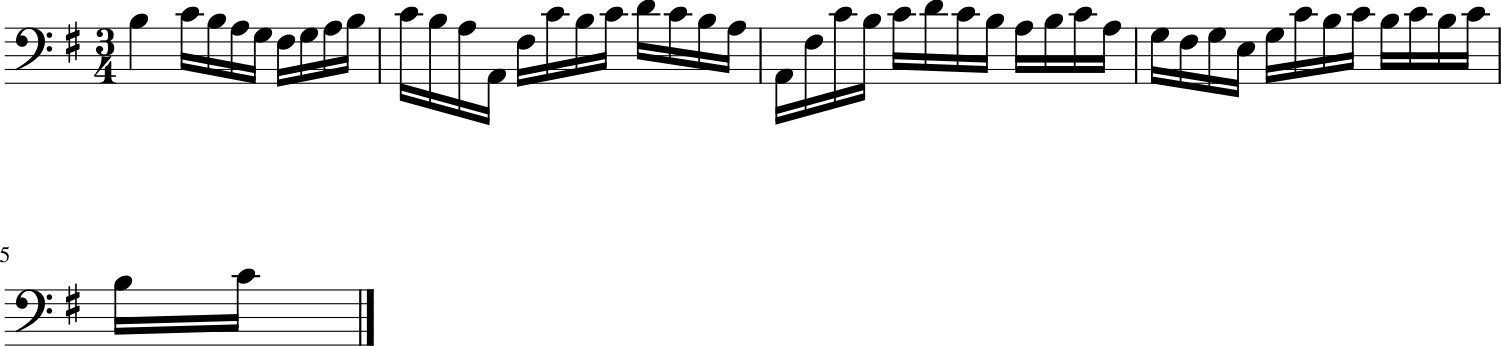

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - duration_outputs_loss: 0.4883 - loss: 1.5554 - note_outputs_loss: 1.0671
Epoch 80/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5162 - loss: 1.5988 - note_outputs_loss: 1.0826[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('A3'), np.str_('A2'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('B2'), np.str_('C#3'), np.str_('A2'), np.str_('G2'), np.str_('E3'), np.str_('F3'), np.str_('G2'), np.str_('F2'), np.str_('A2'), np.str_('D3'), np.str_('F2'), np.str_('E2'), np.str_('G2'), np.str_('C3'), np.str_('E2'), np.str_('D2'), np.str_('B2'), np.str_('C3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('D4'), np.str_('C4')], ['0.0'

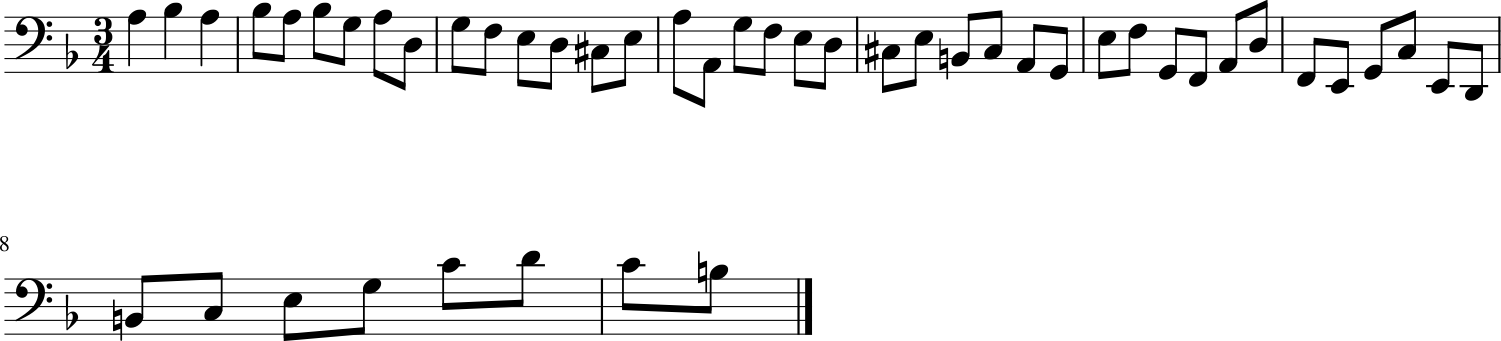

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - duration_outputs_loss: 0.5165 - loss: 1.5992 - note_outputs_loss: 1.0827
Epoch 81/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5116 - loss: 1.5794 - note_outputs_loss: 1.0678[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('E-3'), np.str_('B-2'), np.str_('C3'), np.str_('G#2'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('E-2'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('D3'), np.str_('E-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('G3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_

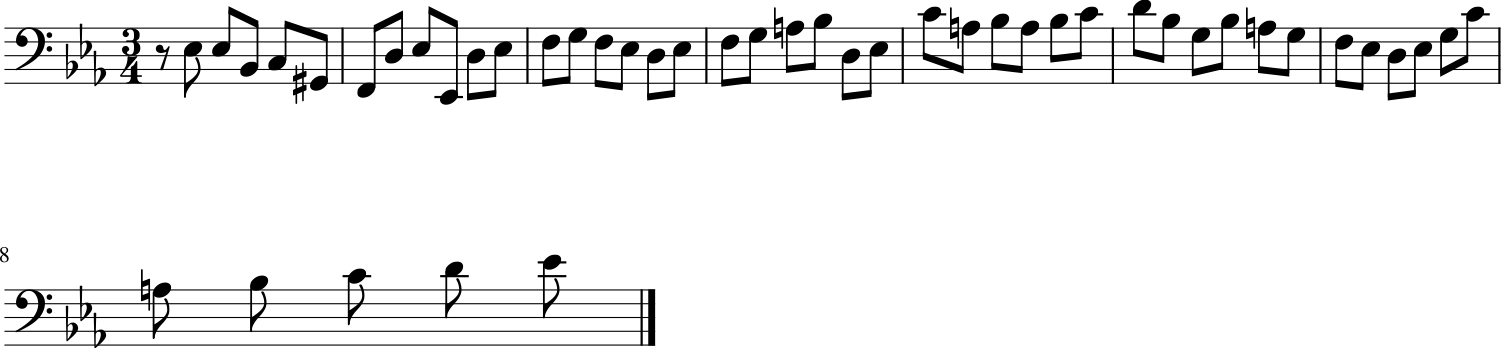

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5119 - loss: 1.5802 - note_outputs_loss: 1.0683
Epoch 82/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5366 - loss: 1.5920 - note_outputs_loss: 1.0554[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('G3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('A2'), np.str_('B-2'), np.str_('G2'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('G3'), np.str_('B-3'), np.str_('D4'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E-4'), np.str_('D4'), np.str_('C4')], [

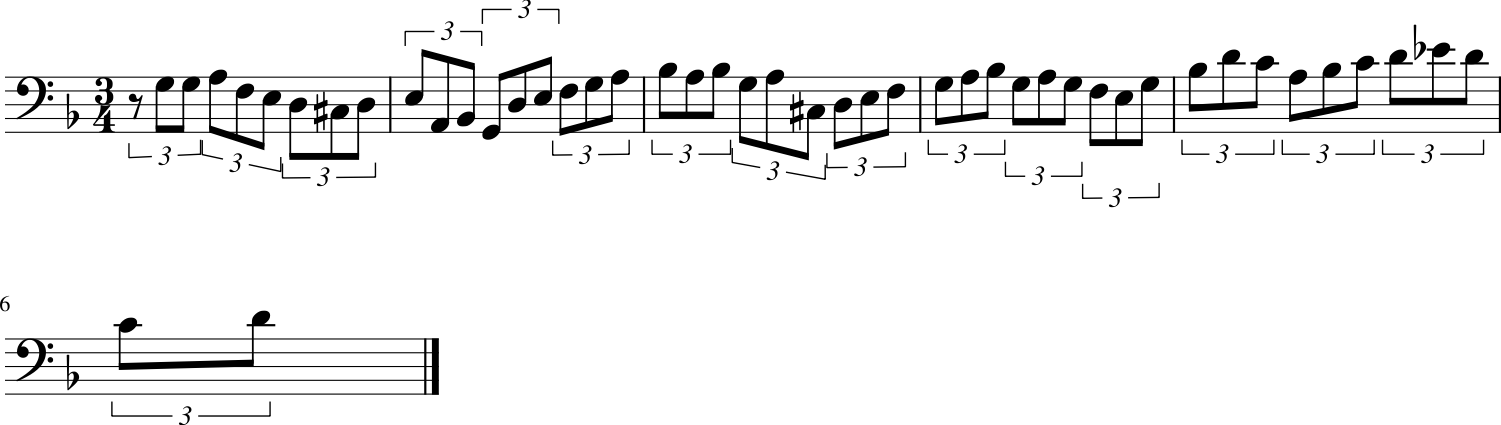

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - duration_outputs_loss: 0.5365 - loss: 1.5922 - note_outputs_loss: 1.0557
Epoch 83/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5179 - loss: 1.5631 - note_outputs_loss: 1.0452[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('D4'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('G2'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3')], ['

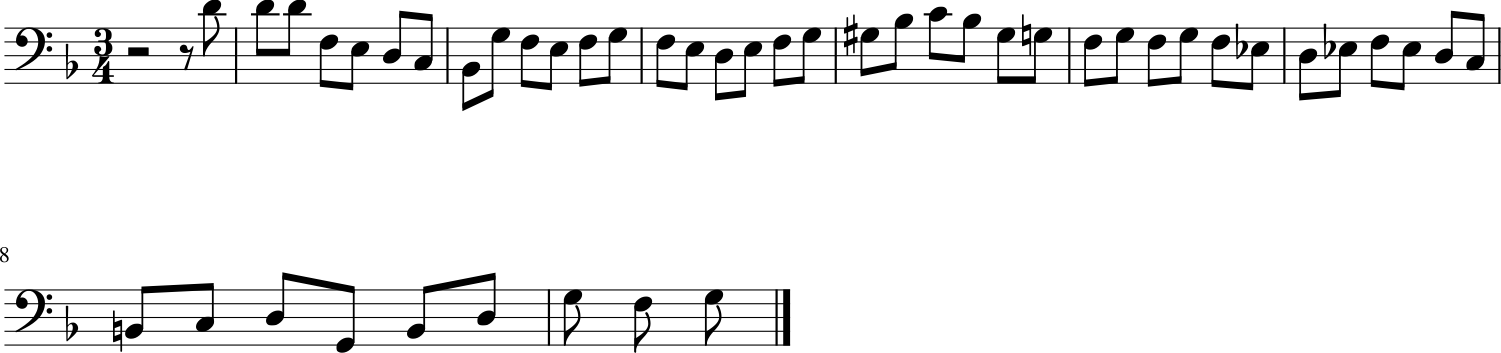

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5182 - loss: 1.5641 - note_outputs_loss: 1.0459
Epoch 84/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5716 - loss: 1.6642 - note_outputs_loss: 1.0926[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('C4'), np.str_('C4'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('G2'), np.str_('F2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G2'), np.str_('G#2'), np.str_('F2'), np.str_('G2'), np.str_('D3'), np.str_('D3'), np.str_('D3'), np.str_('C3'), np.str_('C3'), np.str_('C3'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('F3'), np.str_('D3'), np.str_('G3'), np.str_('B2'), np.str_('A2'), np.str_('G2'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('E4'), np.str_('C2'), np.str_('E4')], [

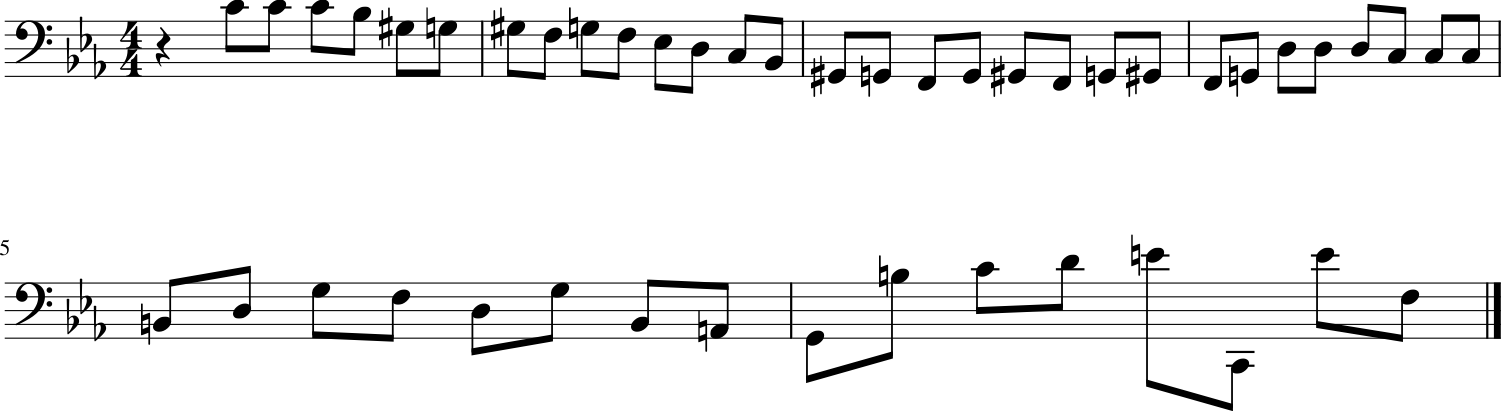

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5712 - loss: 1.6638 - note_outputs_loss: 1.0926
Epoch 85/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5316 - loss: 1.5837 - note_outputs_loss: 1.0521[['START', np.str_('C:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('B-3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('B-3'), np.str_('B-3'), np.str_('G3'), np.str_('D3'), np.str_('E-3'), np.str_('G3'), np.str_('B-2'), np.str_('C3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('E3'), np.str_('F3'), np.str_('C2'), np.str_('G2'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('F2'), np.str_('D3'), np.str_('E3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('F3')], [

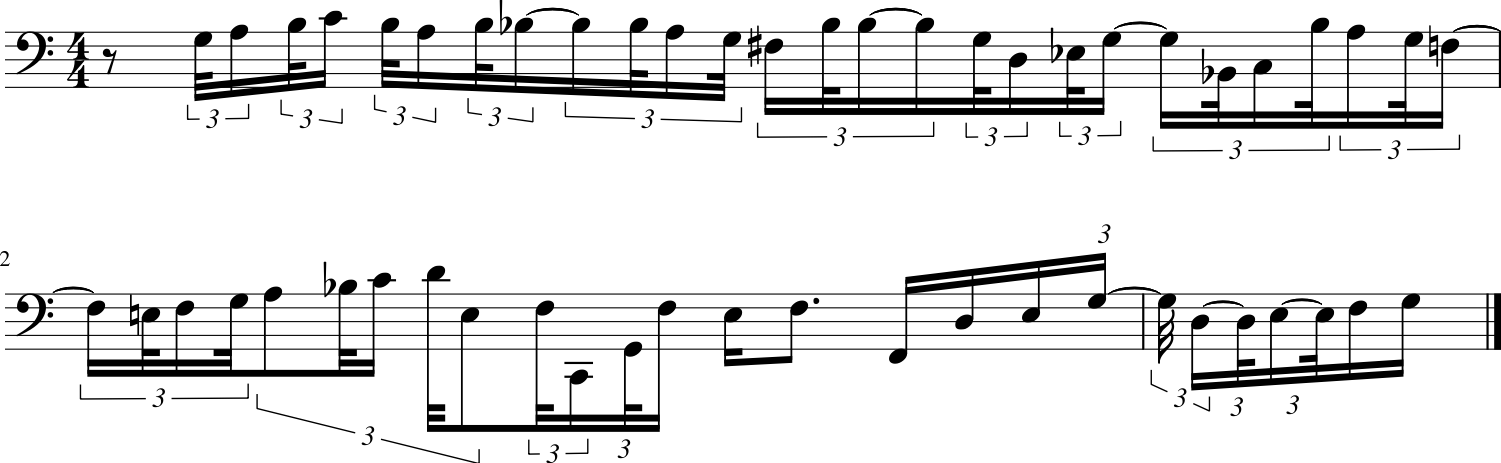

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - duration_outputs_loss: 0.5317 - loss: 1.5840 - note_outputs_loss: 1.0524
Epoch 86/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5275 - loss: 1.5566 - note_outputs_loss: 1.0291[['START', np.str_('G:major'), np.str_('6/8TS'), np.str_('rest'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('D3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('G#3'), np.str_('E3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('G#3'), np.str_('A3'), np.str_('E3'), np.str_('A3'), np.str_('E-3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('E3'), np.str_('A3'), np.str_('E3'), np.str_('A3'), np.str_('B3')], ['0.0',

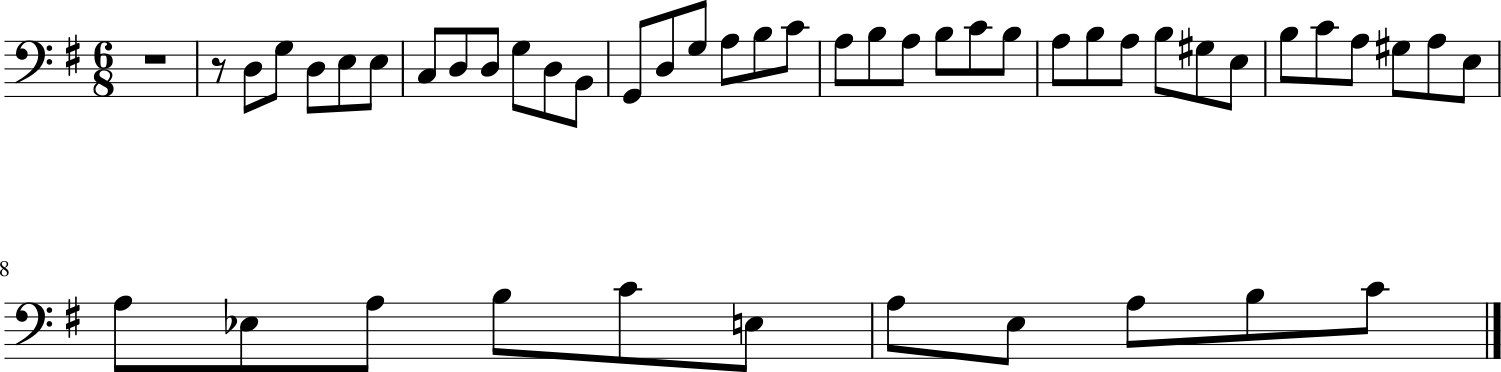

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - duration_outputs_loss: 0.5275 - loss: 1.5570 - note_outputs_loss: 1.0295
Epoch 87/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5173 - loss: 1.5304 - note_outputs_loss: 1.0131[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('C3'), np.str_('C2'), np.str_('G3'), np.str_('C4'), np.str_('G

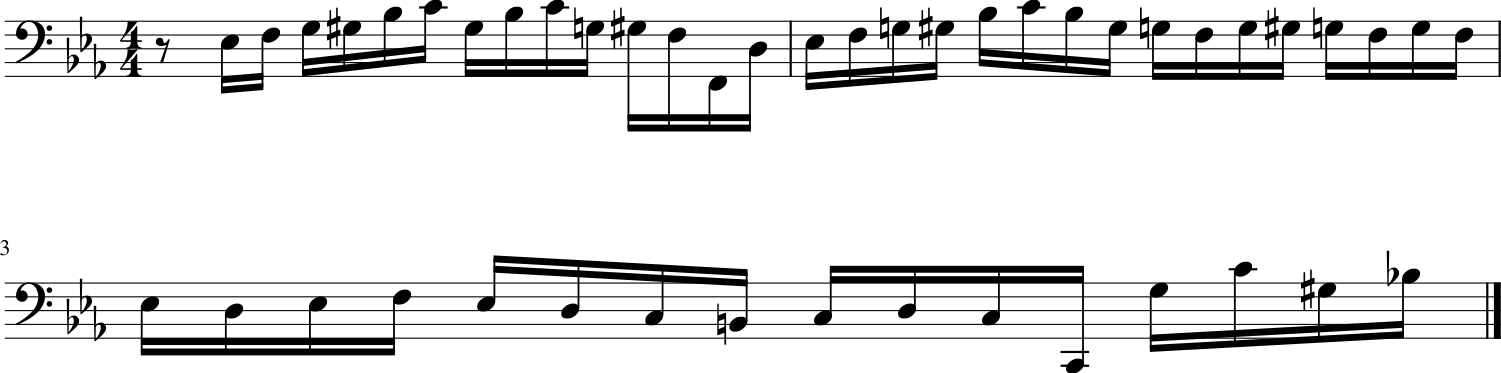

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - duration_outputs_loss: 0.5176 - loss: 1.5318 - note_outputs_loss: 1.0143
Epoch 88/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5354 - loss: 1.5898 - note_outputs_loss: 1.0544[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('F3'), np.str_('E-3'), np.str_('E-3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('D3'), np.str_('F3'), np.str_('G#3'), np.str_('F4'), np.str_('E-4'), np.str_('D4'), np.

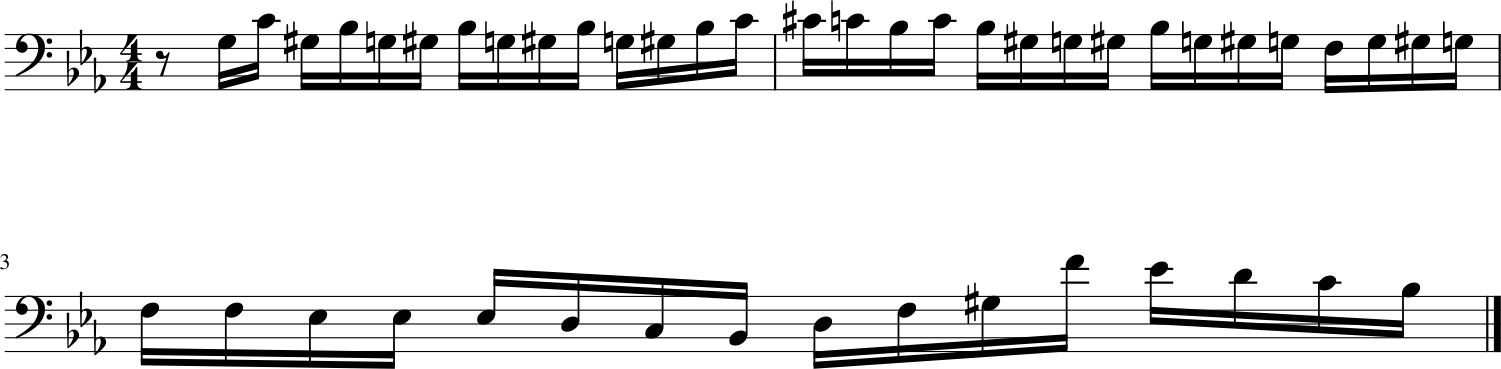

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - duration_outputs_loss: 0.5353 - loss: 1.5900 - note_outputs_loss: 1.0548
Epoch 89/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.4944 - loss: 1.4936 - note_outputs_loss: 0.9992[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('B3'), np.str_('D4'), np.str_('D4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('G3'), np.str_('C4'), np.str_('E3'), np.str_('D3'), np.str_('F4'), np.str_('E4'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('F2'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3')], ['0.0', np

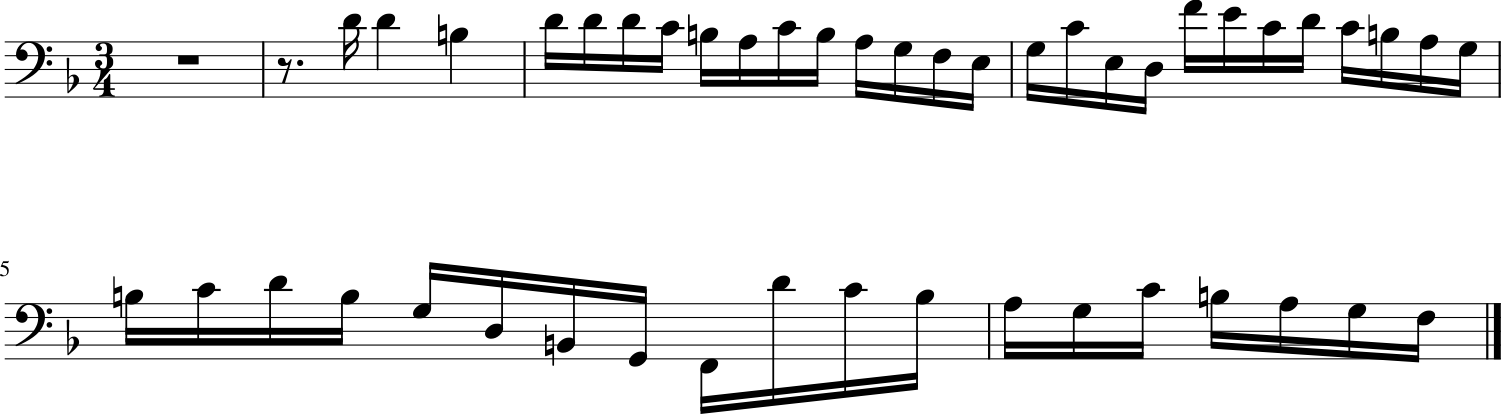

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.4948 - loss: 1.4946 - note_outputs_loss: 0.9998
Epoch 90/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5784 - loss: 1.6165 - note_outputs_loss: 1.0381[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('G3'), np.str_('B-3'), np.str_('C#3'), np.str_('E3'), np.str_('G2'), np.str_('F3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('G2'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('G3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('E3')], ['0.

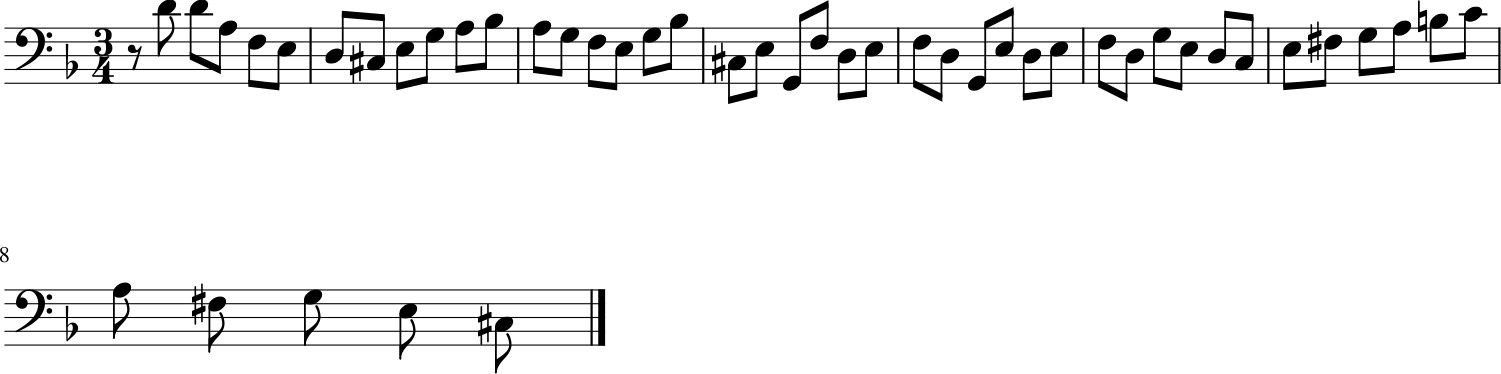

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5776 - loss: 1.6164 - note_outputs_loss: 1.0388
Epoch 91/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5178 - loss: 1.5306 - note_outputs_loss: 1.0128[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('D3'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('B2'), np.str_('E-3'), np.str_('G#3'), np.str_('A3'), np.str_('B3'), np.str_('E-3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('D3'), np.str_('G3'), np.str_('E-3'), np.str_('E3'), np.str_('A3'), np.str_('C4'), np.str_('D3'), np.str_('C3'), np.str_('C2'), np.str_('B-2'), np.str_('C3'), np.str_('D3')]

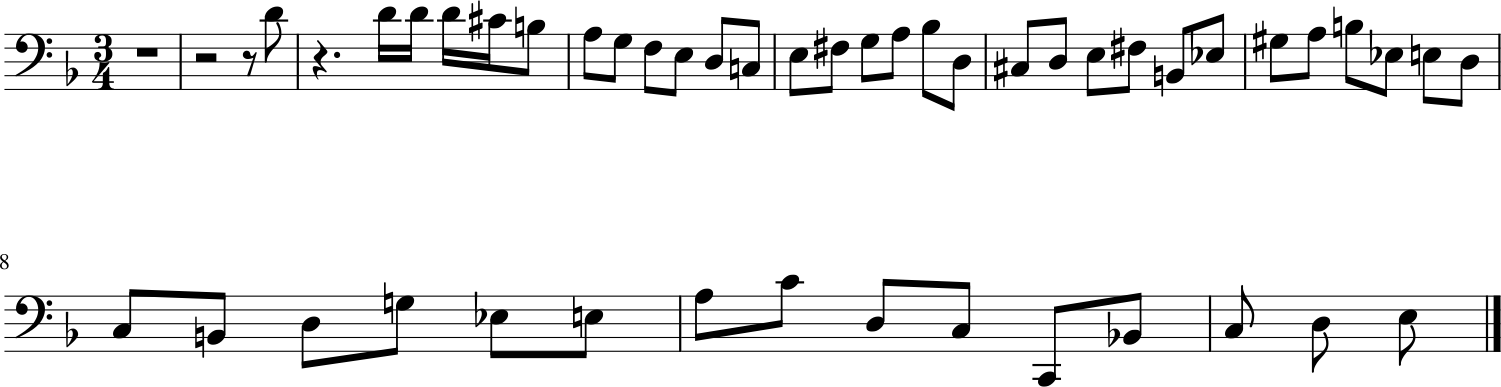

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - duration_outputs_loss: 0.5181 - loss: 1.5317 - note_outputs_loss: 1.0136
Epoch 92/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5585 - loss: 1.5944 - note_outputs_loss: 1.0359[['START', np.str_('D:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('F#4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('A3'), np.str_('A4'), np.str_('A4'), np.str_('A4'), np.str_('B4'), np.str_('A4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('F#4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('F#4'), np.str_('F#4'), np.str_('F#4'), np.str_('A4'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('D4'), np.str_('C#4'), np.str_('B3'), np.str_('C#4'), np.str_('B4'), np.str_('A4'), np.str_('G

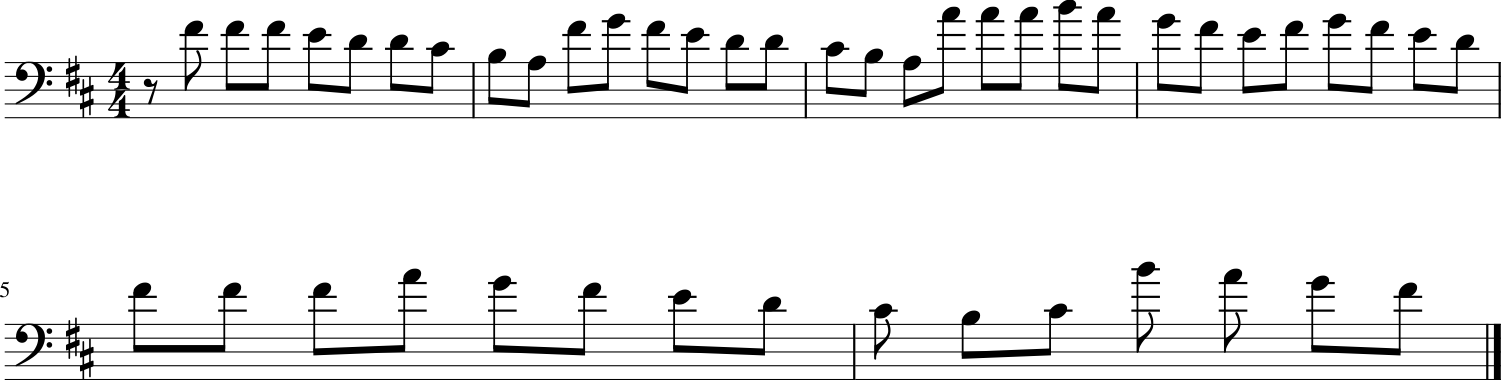

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5582 - loss: 1.5944 - note_outputs_loss: 1.0362
Epoch 93/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5037 - loss: 1.5649 - note_outputs_loss: 1.0612[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('A3'), np.str_('F3'), np.str_('A3'), np.str_('D3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('D3'), np.str_('A3'), np.str_('B-3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('A3'), np.str_('F3'), np.str_('B-3'), np.str_('F3'), np.str_('G3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('A3'), np.str_('G3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('D4'), np.str_('C4'), np.str_('C4'), np.str_('B-3'), np.str_('A3'), np.str_('G3')], [

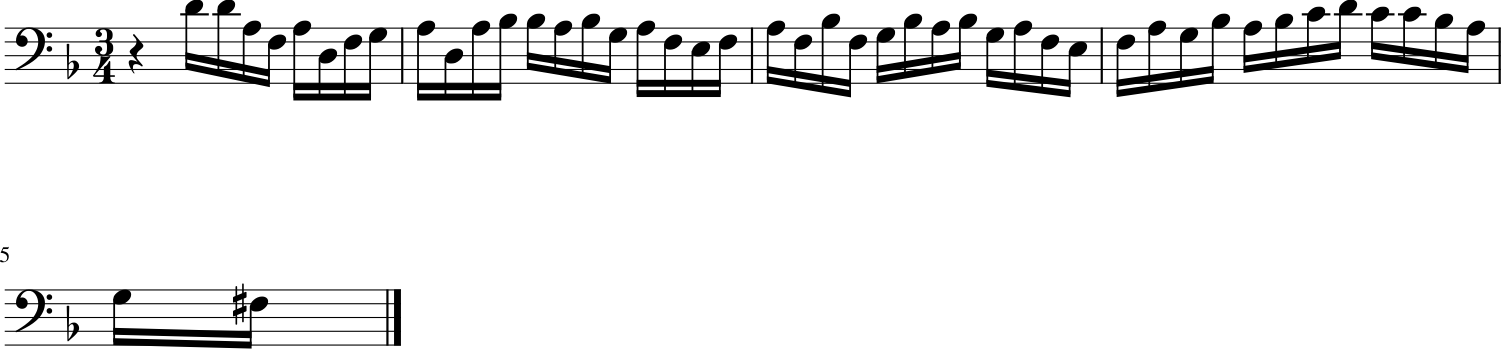

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.5040 - loss: 1.5651 - note_outputs_loss: 1.0611
Epoch 94/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.6071 - loss: 1.5976 - note_outputs_loss: 0.9905[['START', np.str_('E-:major'), np.str_('4/4TS'), np.str_('rest'), np.str_('G3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('G#3'), np.str_('B-3'), np.str_('G3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('B-3'), np.str_('C4'), np.str_('F#3'), np.str_('F3'), np.str_('F#3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('C3'), np.str_('A2'), np.str_('C3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('D3'), np.str_('B-2'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('A2'), np.str_('C3'), np.str_('B-2'), np.str_('D3'), np.s

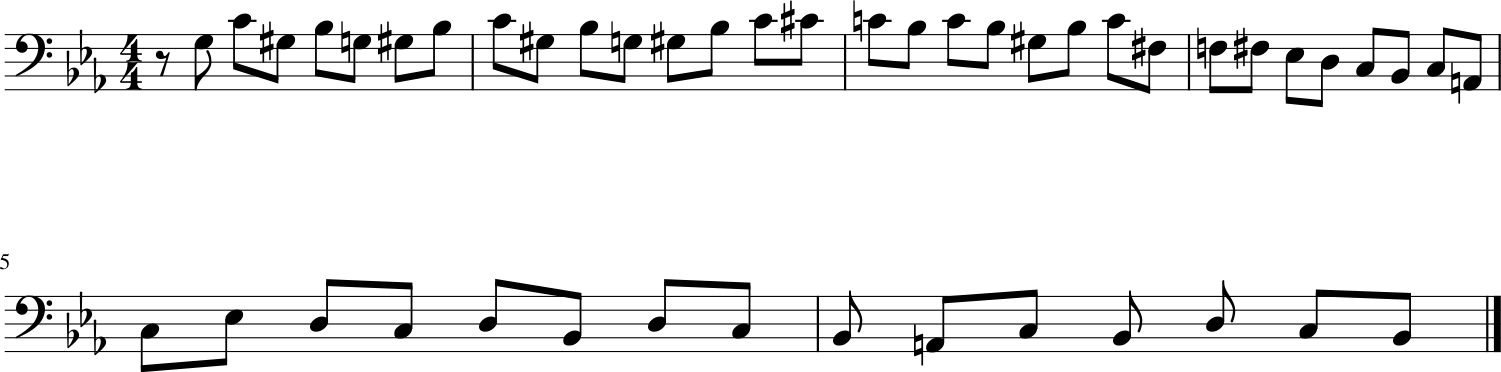

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - duration_outputs_loss: 0.6064 - loss: 1.5974 - note_outputs_loss: 0.9910
Epoch 95/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5273 - loss: 1.5327 - note_outputs_loss: 1.0054[['START', np.str_('G:major'), np.str_('6/8TS'), np.str_('rest'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('D3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('B3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('C#3'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('C#4'), np.str_('D4'), np.str_('E4'), np.str_('A3'), np.str_('G4'), np.str_('D3'), np.str_('G4'), np.str_('F#4'), np.str_('E4'), np.str_('F#4')], ['

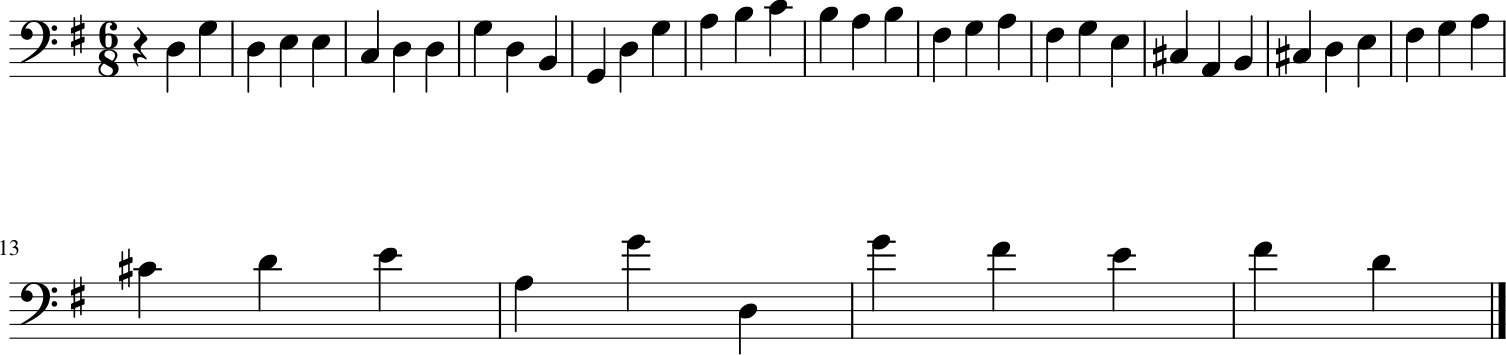

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5273 - loss: 1.5332 - note_outputs_loss: 1.0058
Epoch 96/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5474 - loss: 1.5559 - note_outputs_loss: 1.0085[['START', np.str_('E-:major'), np.str_('3/4TS'), np.str_('B-3'), np.str_('C4'), np.str_('C#4'), np.str_('C#4'), np.str_('B-3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('F2'), np.str_('F3'), np.str_('C4'), np.str_('B-3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('G#3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str_('G#2'), np.str_('E-3'), np.str_('G3'), np.str_('B-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('C3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B-2'), np.str

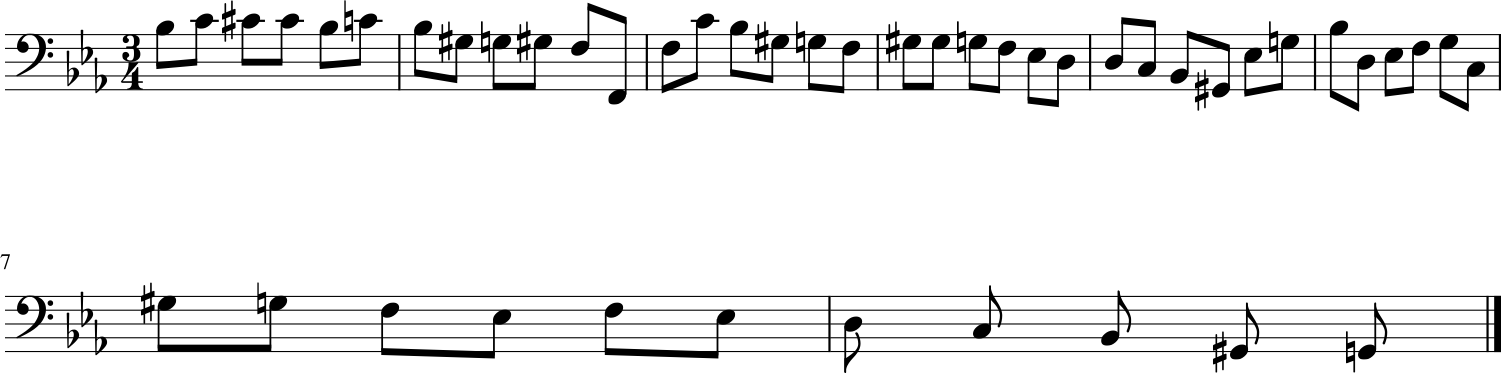

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - duration_outputs_loss: 0.5473 - loss: 1.5561 - note_outputs_loss: 1.0088
Epoch 97/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - duration_outputs_loss: 0.5088 - loss: 1.5318 - note_outputs_loss: 1.0230[['START', np.str_('G:major'), np.str_('3/4TS'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('E3'), np.str_('D4'), np.str_('C4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('E3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('G3'), np.str_('D3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('B3'), np.str_('D3')], ['0.0',

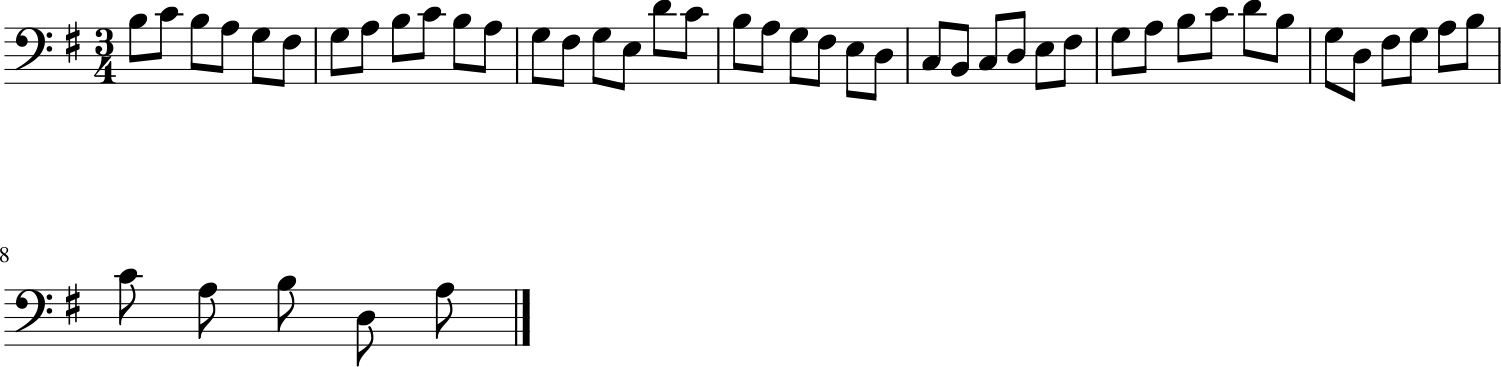

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - duration_outputs_loss: 0.5090 - loss: 1.5323 - note_outputs_loss: 1.0233
Epoch 98/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5368 - loss: 1.5417 - note_outputs_loss: 1.0049[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('A3'), np.str_('F3'), np.str_('A3'), np.str_('D3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('G3'), np.str_('B-3'), np.str_('D3'), np.str_('E-3'), np.str_('C3'), np.str_('E-3'), np.str_('G3'), np.str_('B-3'), np.str_('G3'), np.str_('C4'), np.str_('G#3'), np.str_('G3'), np.str_('G#3'), np.str_('F3'), np.str_('G#3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('G#3'), np.str_('B-3'), np.str_('D3'), np.str_('G#3'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('C3'), np.str_('B2'), np.str_('C3'), np.str_('D3'), np.str_('E-3'), np.str_('D3

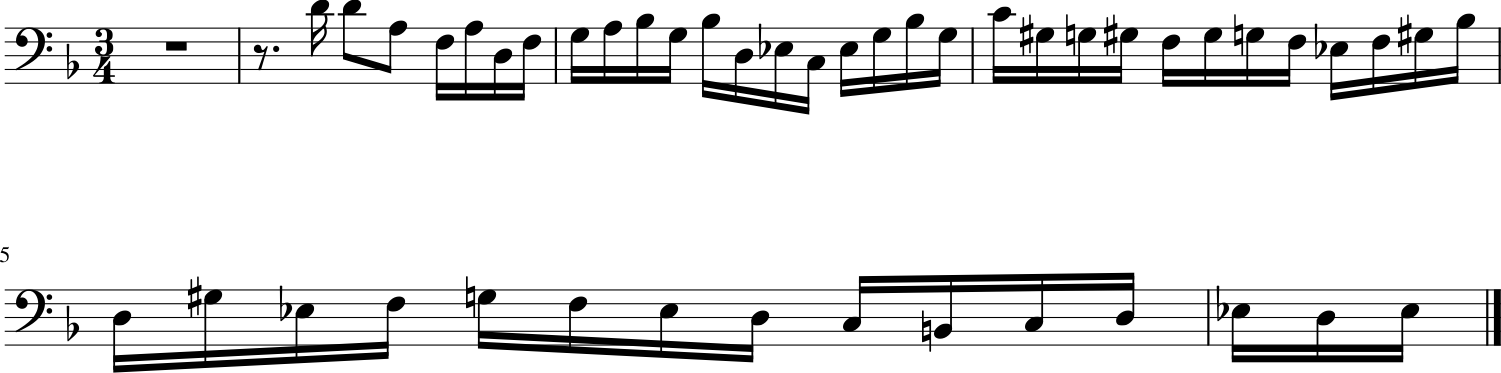

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5367 - loss: 1.5424 - note_outputs_loss: 1.0057
Epoch 99/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - duration_outputs_loss: 0.5299 - loss: 1.5483 - note_outputs_loss: 1.0183[['START', np.str_('G:major'), np.str_('6/8TS'), np.str_('rest'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('E3'), np.str_('C3'), np.str_('D3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('G3'), np.str_('D3'), np.str_('B2'), np.str_('G2'), np.str_('D3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('G3'), np.str_('A3'), np.str_('B3'), np.str_('C4'), np.str_('D4'), np.str_('B3'), np.str_('A3'), np.str_('G3'), np.str_('F#3'), np.str_('G3'), np.str_('D3'), np.str_('E3'), np.str_('C3'), np.str_('A2'), np.str_('C3'), np.str_('E3'), np.str_('A3'), np.str_('C4'), np.str_('A3'), np.str_('F#3'), np.str_('A3'), np.str_('C4'), np.str_('D3'), np.str_('C4')], ['0.0',

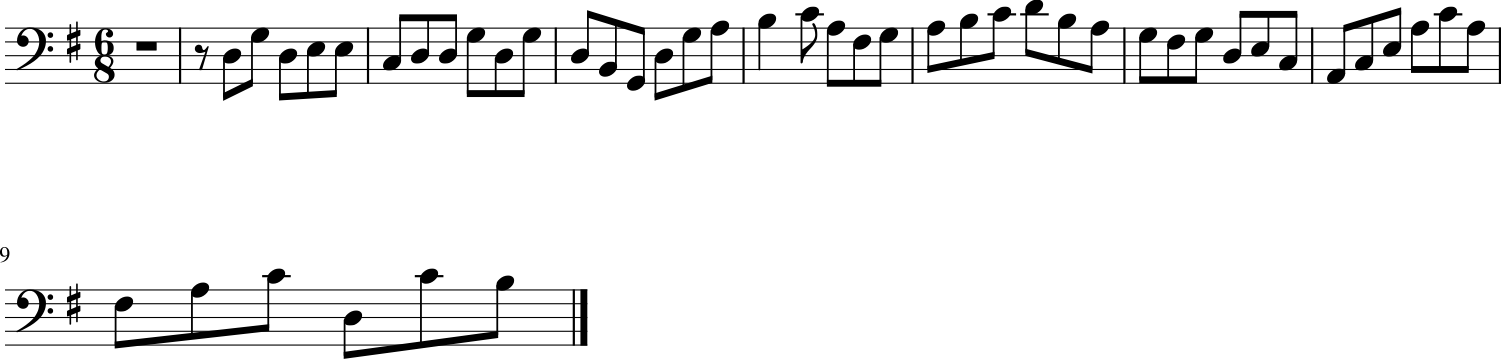

107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - duration_outputs_loss: 0.5300 - loss: 1.5486 - note_outputs_loss: 1.0186
Epoch 100/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - duration_outputs_loss: 0.5473 - loss: 1.5682 - note_outputs_loss: 1.0210[['START', np.str_('F:major'), np.str_('3/4TS'), np.str_('rest'), np.str_('D4'), np.str_('D4'), np.str_('A3'), np.str_('F3'), np.str_('E3'), np.str_('D3'), np.str_('C#3'), np.str_('E3'), np.str_('D3'), np.str_('E3'), np.str_('F3'), np.str_('D3'), np.str_('C#3'), np.str_('B2'), np.str_('A2'), np.str_('B2'), np.str_('C#3'), np.str_('D3'), np.str_('E3'), np.str_('A2'), np.str_('G2'), np.str_('E3'), np.str_('F3'), np.str_('G3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('B-3'), np.str_('A3'), np.str_('G3'), np.str_('F3'), np.str_('E3'), np.str_('F3'), np.str_('A3'), np.str_('G3'), np.str_('B-3'), np.str_('A3'), np.str_('B-3'), np.str_('C4'), np.str_('A3'), np.str_('B-3'), np.str_('C4')], 

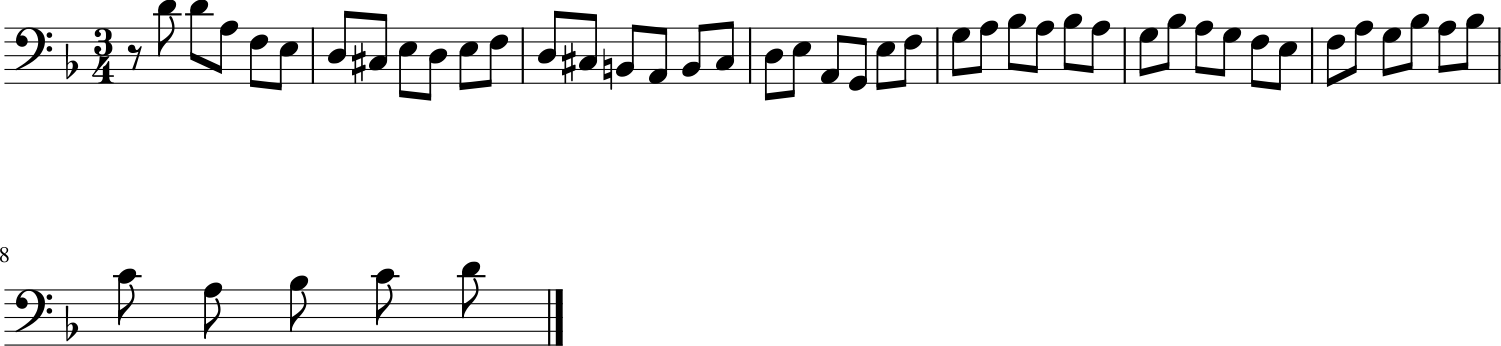

107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 315ms/step - duration_outputs_loss: 0.5470 - loss: 1.5683 - note_outputs_loss: 1.0213


In [41]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

In [44]:
# Save the final model
model.save("models/model.keras")